In [1]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
import re
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [564]:
import pandas as pd
import csv, json, os, math, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2
import sqlite3, thread, urllib, dateparser

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [3]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

In [4]:
pandas.options.display.max_colwidth = 300
pandas.set_option('display.max_columns', 500)

# Read in 2018 US House boundaries

In [11]:
ush_2018 = gpd.read_file('voting/Remedial Plan Shapefile.shp').to_crs(epsg=4326)

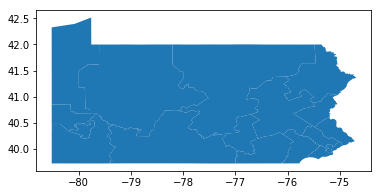

In [12]:
ush_2018.plot()

In [ ]:
ush_2018

In [14]:
# Create a GeoDataFrame that just has DISTRICT and geometry
ush_out_2018 = gpd.GeoDataFrame(ush_2018[['DISTRICT']], geometry=ush_2018.geometry,crs={'init': 'epsg:4326'})

In [ ]:
ush_out_2018

In [16]:
# Write out the 2018 US House geometry as a geojson file
ush_out_2018.to_file('voting/pa_us_house_boundaries_2018.geojson', driver="GeoJSON")

In [17]:
binarize_geojson_outlines('voting/pa_us_house_boundaries_2018.geojson', 
                          'voting/pa_us_house_boundaries_2018.bin')

Read 18 features from voting/pa_us_house_boundaries_2018.geojson
112242 segments
Created voting/pa_us_house_boundaries_2018.bin (112242 segments)


# Read in 2018 PA House boundaries

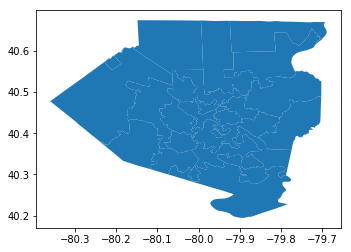

In [456]:
pah_2018 = gpd.read_file('voting/Allegheny_County_Pennsylvania_House_of_Representatives_District_Boundaries.shp').to_crs(epsg=4326)
pah_2018.plot()

In [ ]:
pah_2018

In [458]:
# Write out the 2018 PA House geometry as a geojson file
pah_2018.to_file('voting/ac_pa_house_boundaries_2018.geojson', driver="GeoJSON"
binarize_geojson_outlines('voting/ac_pa_house_boundaries_2018.geojson', 
                          'voting/ac_pa_house_boundaries_2018.bin')

Read 23 features from voting/ac_pa_house_boundaries_2018.geojson
24593 segments
Created voting/ac_pa_house_boundaries_2018.bin (24593 segments)


# Read in 2018 PA Senate boundaries

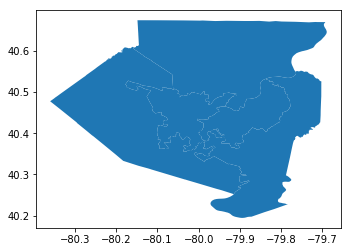

In [459]:
pas_2018 = gpd.read_file('voting/Allegheny_County_Pennsylvania_Senate_District_Boundaries.shp').to_crs(epsg=4326)
pas_2018.plot()

In [ ]:
pas_2018

In [461]:
# Write out the 2018 PA Senate geometry as a geojson file
pas_2018.to_file('voting/ac_pa_senate_boundaries_2018.geojson', driver="GeoJSON")

binarize_geojson_outlines('voting/ac_pa_senate_boundaries_2018.geojson', 
                          'voting/ac_pa_senate_boundaries_2018.bin')

Read 5 features from voting/ac_pa_senate_boundaries_2018.geojson
8906 segments
Created voting/ac_pa_senate_boundaries_2018.bin (8906 segments)


# Polling places

In [116]:
# Get old polling place locations
pp_2017 = gpd.read_file('voting/Polling_Place_Locations_May_2017.shp').to_crs(epsg=4326)

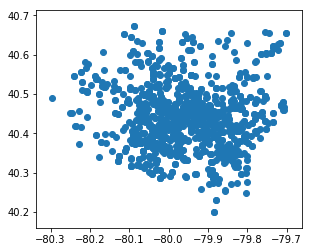

In [41]:
pp_2017.plot()

In [ ]:
pp_2017

In [117]:
pp_2017[pp_2017.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.81808,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.81808,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [120]:
pp_2017[pp_2017.MWD2==1881926]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
618,296,296.0,188,19,26,BROOKLINE U.P. CHURCH HALL,None,1036,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097H00001000000,None,12,7,1.337211e+06,393627.765169,14.0,42.0,22.0,None,PITTSBURGH,1036 BROOKLINE BLVD,1881926,1.337211e+06,393627.765169,1881926,1036 BROOKLINE BLVD,POINT (-80.01663330913114 40.39164418362884)


In [119]:
# Get rid of Brookline terrace based on discussion with David Hoyt
# on 10/25/18
pp_2017 = pp_2017[~(pp_2017.MWD2.duplicated())]

In [124]:
# Get intermediate polling place locations
pp_2018_05 = gpd.read_file('voting/PollingPlaces2018_May.shp').to_crs(epsg=4326)


In [122]:
pp_2018_05[pp_2018_05.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.818078,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.818078,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [125]:
pp_2018_05 = pp_2018_05[~pp_2018_05.MWD2.duplicated()]

In [5]:
# Get new polling place locations
pp_2018_11 = gpd.read_file('voting/Allegheny_County_Polling_Place_Locations_November_2018.shp').to_crs(epsg=4326)


In [127]:
pp_2018_11[pp_2018_11.MWD2.duplicated()]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress,geometry
1235,913,916.0,188,19,26,BROOKLINE TERRACE,None,920,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097D00067000S00,None,12,7,1.336626e+06,393957.818078,14.0,42.0,22.0,None,PITTSBURGH,920 BROOKLINE BLVD,1881926,1.336626e+06,393957.818078,1881926,920 BROOKLINE BLVD,POINT (-80.01876370240662 40.39250864644669)


In [128]:
pp_2018_11 = pp_2018_11[~pp_2018_11.MWD2.duplicated()]

In [129]:
pp_2018_m = pd.merge(pp_2018_11,pp_2018_05[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_11', '_18_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [130]:
pp_2018_2017_m = pd.merge(pp_2018_m,pp_2017[['MWD2','NewAddress']], on='MWD2', suffixes=('_18_m', '_17_05'),left_index=False, right_index=False, sort=False,copy=True, indicator=False,
                         validate=None)

In [135]:
# Rename NewAddress to NewAddress_17_05
pp_2018_2017_m=pp_2018_2017_m.rename(columns={'NewAddress':'NewAddress_17_05'})

In [132]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1881926]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress
618,296,296.0,188,19,26,TREE OF LIFE CHURCH,None,1036,None,BROOKLINE,BLVD,None,PITTSBURGH,None,None,15226-2148,0097H00001000000,None,12,7,1.337211e+06,393627.765169,14.0,42.0,22.0,None,PITTSBURGH,1036 BROOKLINE BLVD,1881926,1.337211e+06,393627.765169,1881926,1036 BROOKLINE BLVD,POINT (-80.01663330913114 40.39164418362884),1036 BROOKLINE BLVD,1036 BROOKLINE BLVD


In [138]:
# Changed since 2017_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05])

59

In [141]:
pp_2018_2017_m['addr_changed_17'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_17_05

In [139]:
# Changed since 2018_05
len(pp_2018_2017_m[pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05])

31

In [142]:
pp_2018_2017_m['addr_changed_18'] = pp_2018_2017_m.NewAddress_18_11!=pp_2018_2017_m.NewAddress_18_05

In [ ]:
pp_2018_2017_m[pp_2018_2017_m.addr_changed_18].sort_values(['MuniName','MWD2'])[['MuniName','MWD2','LocName','NewAddress_18_11','NewAddress_18_05','addr_changed_17','addr_changed_18','geometry']]

In [148]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1660201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
961,MCCANDLESS,1660201,10375 PERRY HWY,10375 PERRY HWY,False,False,POINT (-80.05354114992568 40.60391226742988)


In [149]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==2280201][['MuniName','MWD2','NewAddress_18_05','NewAddress_18_11','addr_changed_17','addr_changed_18','geometry']]

,MuniName,MWD2,NewAddress_18_05,NewAddress_18_11,addr_changed_17,addr_changed_18,geometry
858,WILKINSBURG,2280201,1256 FRANKLIN AVE,1256 FRANKLIN AVE,False,False,POINT (-79.87451573119165 40.43750237177388)


In [156]:
len(pp_2018_2017_m[(pp_2018_2017_m['addr_changed_17']) & ~(pp_2018_2017_m['addr_changed_18'])])

29

In [152]:
# This was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-AW3b-Polling.ipynb, 
# then modified to deal with addition of 18_05 data
def write_pp_csv(df, out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write(",lat,lon,%s\n" % (",".join(map(str,date_range))))
    
    i=0
    for i in range(0,len(df)):
        coords = df['geometry'].iloc[i]
        lon = coords.x
        lat = coords.y
        mwd = df['MWD2'].iloc[i]
        
        # Write size row
        out_data=[mwd, lat, lon]
        for year in date_range:
            out_val = 20
            out_data.append(out_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
        
        # Write color row: Color =1 for changed in 2018, .5 for changed in 2017, 0 for stable
        out_data=[mwd, lat, lon]
        color_val = 0
        if df['addr_changed_18'].iloc[i]:
            color_val=1
        elif df['addr_changed_17'].iloc[i]:
            color_val = 0.5
        
        for year in date_range:
            out_data.append(color_val)
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()

In [153]:
write_pp_csv(pp_2018_2017_m, "voting/pa_ac_polling_places_2018b.csv")

# Deal with voting file from county

# Address mapping

In [5]:
# Key is string canonical address, value is a map: {'canonical_in_census_db': True/False,'canonical_in_google_db': True/False, 'other_addr_strings':Set, 'census_value':str, 'google_value':str
canonical_addr_map={}

In [19]:
def canonicalize_string(text):
    # Remove any leading or trailing whitespace, replace any internal whitespace with single spaces, upcase it all
    ret = re.sub("^\s+|\s+$", "", text)
    ret = re.sub("\s+", " ", ret)
    return ret.upper()

In [717]:
# Try to load canonical_addr_map originally created by 
#  http://localhost:8820/notebooks/projects/demographics/Fixup%20Address%20DB.ipynb
import pickle
pickle_file_path = 'assessments/canonical_addr_map_e.pickle'

In [411]:
# Load in canonical_addr_map
with open(pickle_file_path, 'rb') as handle:
    canonical_addr_map = pickle.load(handle)

In [718]:
# Save out canonical_addr_map
with open(pickle_file_path, 'wb') as handle:
    pickle.dump(canonical_addr_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [454]:
len(canonical_addr_map)

3017691

In [22]:
# From http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb

# assessments/cd/AC Property Assessments_10012017.xls (which is actually TDF) from Amy Gottsegen and Randy Sargent buying a CD from the county assessors office
# assessments/Allegheny_County_Parcel_Boundaries.geojson from https://data.wprdc.org/dataset/allegheny-county-parcel-boundaries
import array, csv, datetime, json, math, numpy, os, random, re 
from dateutil.parser import parse
from shapely.geometry import mapping, shape
from PIL import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas,numbers
from operator import itemgetter, attrgetter
import string
import calendar,time
from IPython.core.display import HTML

# Use geopandas.  Boilerplate from https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#heading=h.f50xoxwmcir
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', 500)

# Built-in time handling fails for times before 1900.  Use arrow instead.  
# See https://arrow.readthedocs.io/en/latest/ for info
import arrow
import dateparser

def LonLatToPixelXY(lonlat):
    (lon, lat) = lonlat
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

# This does the same as above, but takes a GeoJSON point (which is what centroid returns)
def PointToPixelXY(point):
    lon=point.x
    lat=point.y
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def GetCentroid(geometry):
    s = shape(geometry)
    return (s.centroid.x, s.centroid.y)   

def GetEpoch(date):
    return (date - datetime.datetime(1970, 1, 1)).total_seconds()

def HexToRgb(hex_string):
    rgb = colors.hex2color(hex_string)
    r,g,b = tuple([int(255*x) for x in rgb])
    return (r,g,b)

In [23]:
# Google addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
from shapely.geometry import Point
import collections


# Google geocoding API to geocode an address
# Assumes key is in google_api_key.txt
# Use as second level lookup only for those which fail census lookup

re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_google(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    result=None
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['google_value']):
        result = json.loads(canonical_addr_map[caddr]['google_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or google address lookup service
        try:
            geocode_address_google.conn
        except:
            geocode_address_google.conn = sqlite3.connect('geocoding_cache')
            geocode_address_google.cur = geocode_address_google.conn.cursor()
            geocode_address_google.cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                                         ' (key PRIMARY KEY, value)'
                                         ' WITHOUT ROWID;'))
            geocode_address_google.conn.commit()

        geocode_address_google.cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = geocode_address_google.cur.fetchall()
        if rows:
            #print "Google: Found %r in cache" % (caddr)
            gval = rows[0][0]
            result = json.loads(gval)
        else:
            # Not in sqlite, ask google address service
            #print "Google: %r not found in cache, fetching" % (address)

            api_key = open('google-api-key-do-not-commit.txt').read()
            payload = {'address':caddr, 'key':api_key}
            result = json.load(urllib2.urlopen('https://maps.googleapis.com/maps/api/geocode/json?%s' % urllib.urlencode(payload)))
            # Keep the stringified version for the DB/canonical_addr_map
            gval = json.dumps(result)
            geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                         ' VALUES (?, ?);'),
                                         (caddr, gval))
            geocode_address_google.conn.commit()
            
            # If the result succeeded and generated a formatted address, cache under that key too
            try:
                if(result['status']=='OK'):
                    if(len(result['results'])== 1):
                        canonical = result['results'][0]['formatted_address']
                        #print "Google: Storing canonical addr of %r for %r" % (canonical, address)
                        geocode_address_google.cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                                                             ' VALUES (?, ?);'),
                                                             (canonical, gval))
                        geocode_address_google.conn.commit()
                    else:
                        print "Google: Fetch %r seemed to succeed, but results empty or non-unique" % (address)

                else:
                    print "Google: Fetch %r failed" % (address)
                
            except:
                #pass
                raise
                
        # We had to resort to sqlite/google address service.  Add gval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':False,'canonical_in_google_db': True, 
                                       'census_value':None, 'google_value':gval}
        else:
            # Already there, presumably for census.  Add google value 
            canonical_addr_map[caddr]['canonical_in_google_db']=True
            canonical_addr_map[caddr]['google_value']=gval
 
    
    return result

def get_canonical_address_google(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_google(raw_addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            return(result['results'][0]['formatted_address'])
        else:
            return None
    except:
        return None

def get_canonical_zip_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            addr_comps = result['results'][0]['address_components']
            for i in range(0, len(addr_comps)):
                if('postal_code' in addr_comps[i]['types']):
                    return addr_comps[i]['short_name']
        
        return None
    except:
        return None
    
def get_canonical_coords_google(addr):
    if(pandas.isnull(addr) or re_noalnum.match(addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    try:
        result=geocode_address_google(addr)
        if(result['status']=='OK' and len(result['results'])== 1):
            latlon = result['results'][0]['geometry']['location']
            if(latlon):
                return(Point(latlon['lng'], latlon['lat']))
        return None
    except Exception as e:
        print "Exception processing get_canonical_coords_google(%s): %s" % (addr, e)
        return None


In [24]:
# Census addresses with the addition of using canonical_addr_map as cache
# Original version was from 
#  http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#

# Uses Census geocoding API to geocode an address

import sqlite3
import urllib,urllib2
import json
from shapely.geometry import Point
import collections

# Match if the string contains no alphanumerics
re_noalnum = re.compile('^([^\w]+)$')

def geocode_address_census(address):
    if(pandas.isnull(address) or re_noalnum.match(address)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(address)
        return None

    # String canonicalize the address
    caddr = canonicalize_string(address)

    # Check if we already have a value in canonical_addr_map, if so return it
    if(caddr in canonical_addr_map and canonical_addr_map[caddr]['census_value']):
        result = json.loads(canonical_addr_map[caddr]['census_value'])
    else:
        # Not yet in canonical_addr_map, fetch from sqlite DB or census address lookup service
        try:
            geocode_address_census.sqlite
        except:
            geocode_address_census.sqlite = {}

        tpid = '%d.%s' % (os.getpid(), thread.get_ident())
        if not tpid in geocode_address_census.sqlite:
            conn = sqlite3.connect('geocoding_cache_census')
            cur = conn.cursor()
            geocode_address_census.sqlite[tpid] = { 'conn': conn, 'cur': cur }

            cur.execute(('CREATE TABLE IF NOT EXISTS kvs'
                         ' (key PRIMARY KEY, value)'
                         ' WITHOUT ROWID;'))
            conn.commit()
        else:
            conn = geocode_address_census.sqlite[tpid]['conn']
            cur = geocode_address_census.sqlite[tpid]['cur']

        cur.execute('SELECT value FROM kvs WHERE key=?', (caddr,))
        rows = cur.fetchall()
        if rows:
            cval = rows[0][0]
        else:
            payload = {'address':caddr, 'benchmark':4, 'format':'json'}
            result = json.load(urllib2.urlopen('https://geocoding.geo.census.gov/geocoder/locations/onelineaddress?%s' % urllib.urlencode(payload)))
            cval = json.dumps(result)

            cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                         ' VALUES (?, ?);'),
                        (caddr, cval))
            conn.commit()

            if len(result['result']['addressMatches']) == 1:
                canonical = result['result']['addressMatches'][0]['matchedAddress']
                cur.execute(('INSERT OR REPLACE INTO kvs (key, value)'
                             ' VALUES (?, ?);'),
                             (canonical, cval))
                conn.commit()
            
        # We had to resort to sqlite/google address service.  Add cval to canonical_addr_map
        if(caddr not in canonical_addr_map):
            canonical_addr_map[caddr]={'canonical_in_census_db':True,'canonical_in_google_db': False, 
                                       'census_value':cval, 'google_value':None}
        else:
            # Already there, presumably for google.  Add census value 
            canonical_addr_map[caddr]['canonical_in_census_db']=True
            canonical_addr_map[caddr]['census_value']=cval

    
    return result

def cache_canonical_addresses(addrs):
    t = SimpleThreadPoolExecutor(25)
    for addr in addrs:
        if(not (pandas.isnull(addr) or re_noalnum.match(addr))):
            t.submit(geocode_address_census, addr)
        else:
            #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
            pass
    t.shutdown()

def get_canonical_address_census(raw_addr):
    if(pandas.isnull(raw_addr) or re_noalnum.match(raw_addr)):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(raw_addr)
        return None

    try:
        result=geocode_address_census(raw_addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['matchedAddress'])
        else:
            return None
    except:
        return None

def get_canonical_zip_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            return(result['result']['addressMatches'][0]['addressComponents']['zip'])
        else:
            return None
    except:
        return None

    
def get_canonical_coords_census(addr):
    try:
        result=geocode_address_census(addr)
        if len(result['result']['addressMatches']) == 1:
            coords = result['result']['addressMatches'][0]['coordinates']
            return(Point(coords['x'], coords['y']))
        else:
            return None
    except:
        return None

################################################################################################################
# These can handle being passed a map with either census or google in it and dispatch to the right service

# TODO: Think if this is the right behavior: If handed a regular string do census lookup
# If handed a map, return census if non-null, then google if non-null
def get_canonical_address(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None

    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return addr['census']
        elif('google' in addr and not pd.isnull(addr['google'])):
            return addr['google']
    else:
        return(get_canonical_address_census(addr))

def get_canonical_zip(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_zip_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_zip_google(addr['google'])
    else:
        return(get_canonical_zip_census(addr))

def get_canonical_coords(addr):
    if(pandas.isnull(addr) or ((not isinstance(addr, collections.Mapping) and re_noalnum.match(addr)))):
        #print "Skipping address lookup for %r, no alphanumeric characters" %(addr)
        return None
    
    if(isinstance(addr, collections.Mapping)):
        if('census' in addr and not pd.isnull(addr['census'])):
            return get_canonical_coords_census(addr['census'])
        elif('google' in addr and not pd.isnull(addr['google'])):
            return get_canonical_coords_google(addr['google'])
    else:
        return(get_canonical_coords_census(addr))

def canonicalize_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: get_canonical_address_census(' '.join(x)), axis=1)
    
    

In [25]:
# Create 'property_address_raw' and 'owner_address_raw' columns.  Call once per dataframe before calling
# canonicalize_addrs
def merge_addr_colset(df, col_arr, out_colname):
    for  col_name in col_arr:
        df[col_name]=df[col_name].astype(basestring)
        df[col_name].fillna('', inplace=True)

    df[out_colname] = df[col_arr].apply(lambda x: canonicalize_string(' '.join(x)), axis=1)
    # Fix up PGH to be PITTSBURGH
    df[out_colname] = df[out_colname].str.replace('\s*PGH\s*,', ' PITTSBURGH,', regex=True)


# Deal with various versions of the voter DB

In [525]:
voters_addr_cols=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City', 'State','Zip_Code']
voters_dtype={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 'StreetNameComplete':numpy.str ,'City':numpy.str, 
              'State':numpy.str,'Zip_Code':numpy.str,'Dist1':numpy.str}

# 2009-07 is a special case. It was generated by 
#   http://localhost:8820/notebooks/projects/demographics/Import%20Fixed%20Width%20Voter%20Files.ipynb
# from a fixed width file.  City and state were together in a single field.
voters_addr_cols_2009=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City','Zip_Code']
voters_dtype_2009={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 
                   'StreetNameComplete':numpy.str ,'City':numpy.str,'Zip_Code':numpy.str,
                   'Dist1':numpy.str
                  }

# 2005-02 is a special case. It was generated by 
#   http://localhost:8820/notebooks/projects/demographics/Import%20Fixed%20Width%20Voter%20Files%202005-02.ipynb
# from a fixed width file.  City and state were together in a single field.
voters_addr_cols_2009=['House__', 'HouseNoSuffix', 'StreetNameComplete' ,'City','Zip_Code']
voters_dtype_2009={'House__':numpy.str, 'HouseNoSuffix':numpy.str, 
                   'StreetNameComplete':numpy.str ,'City':numpy.str,'Zip_Code':numpy.str,
                   'Dist1':numpy.str,'Vote_History':numpy.str
                  }

voters_info = {
    '2018-10': {'path': 'voters/2018-10-cd/10_16_18VOTERS.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-08': {'path': 'voters/2018-08-cd/VOTERS8_14_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2018-03': {'path': 'voters/2018-03-cd/VOTERS3_5_18.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2017-11': {'path': 'voters/2017-11-cd/VOTERS11_30_2017.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2013-02': {'path': 'voters/2013-02-cd/VOTERS_VH_2013-02-19.TXT', 
                'addr_cols': voters_addr_cols,
                'dtype': voters_dtype
               },
    '2009-07': {'path': "voters/2009-07-cd/VOTERS07_22_2009.TXT", 
                'addr_cols': voters_addr_cols_2009,
                'dtype': voters_dtype_2009
               },
    '2005-02': {'path': "voters/2005-02-cd/VOTERS02_07_2005.TXT", 
                'addr_cols': voters_addr_cols_2009,
                'dtype': voters_dtype_2009
               }

}

In [478]:
monthstr_to_date_map={'2005-02':dateparser.parse("2/7/2005"),
                      '2005-08':dateparser.parse("8/5/2005"),
                      '2009-07':dateparser.parse("7/22/2009"),
                      '2013-02':dateparser.parse("2/19/2013"),
                      '2013-04':dateparser.parse("4/29/2013"),
                      '2014-06':dateparser.parse("6/18/2014"),
                      '2015-09':dateparser.parse("9/11/2015"),
                      '2016-09':dateparser.parse("9/2/2016"),
                      '2017-04':dateparser.parse("4/21/2017"),
                      '2017-10':dateparser.parse("10/16/2017"),
                      '2017-11':dateparser.parse("11/30/2017"),
                      '2018-06':dateparser.parse("6/12/2018"),
                      '2018-03':dateparser.parse("3/5/2018"),
                      '2018-08':dateparser.parse("8/14/2018"), 
                      '2018-10':dateparser.parse("10/16/2018")
                     }

In [12]:
# Hold on to the dataframes associated with each month_str in a map
vdf_map={}

In [13]:
# Do fixup on Pitt addresses
def fixup_pitt_addresses(df):
    df['address_raw'] = df['address_raw'].str.replace('(^.*((PITT TOWERS)|(5TH AVE-MCCORMICK HALL)|(HOLLAND HALL)) PITTSBURGH PA 15213$)', '3990 FIFTH AVE PITTSBURGH PA 15213', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*AMOS HALL PITTSBURGH PA 15213$)', '3959 FIFTH AVE PITTSBURGH PA 15260', regex=True)
    df['address_raw'] = df['address_raw'].str.replace('(^.*SUTHERLAND HALL PITTSBURGH PA 15213$)', '3725 SUTHERLAND DR PITTSBURGH PA 15213', regex=True)
    
    

In [14]:
def load_voters_info(month_str):
    if(not month_str in voters_info):
        print "No entry for %s in voters_info" % (month_str)
    path = voters_info[month_str]['path']
    vdf_map[month_str] = pandas.read_csv(path,sep='\t',dtype=voters_info[month_str]['dtype']).set_index('ID_Number')
    merge_addr_colset(vdf_map[month_str], voters_info[month_str]['addr_cols'], 'address_raw')
    fixup_pitt_addresses(vdf_map[month_str])
    return vdf_map[month_str]

In [17]:
# Key is voter ID, DOB:str, reg_date:str, 
#    reg_info:{month_str: {status: , party: }}, addresses:{month_str:address}}
#    vote_info:{vote_str: {party: , 'how': }}
# vote_str is in the form GN_11_06_12 or PR_05_15_18 or PR_05_17_11
# In the case of vote_info records added from fixed width files,
#    'party' is set to be earliest known party and 'how' is None
# In the case of those added from later files, 'how' is processed directly:
#    'AP' indicates the voter cast their ballot at the polls
#    'AB' indicates the voter cast an absentee ballot
#    'P' indicates that the voter cast a provisional ballot
# Added by voter_process_address_history:
#   'addr_arr':[{'address': , 'date': , 'census_block': , 'latlon': },]
voter_map = {}

In [520]:
# Key is vote_str, value is {'date': datetime, 'month_strs': set(month_str),'date_type': }
# 'date_type' is 'exact' if we actually knew the date, or 'approx' if we're just guessing
# strings generated from fixed width files will be created as 'approx' dates; those
# created by newer files will be 'exact'.  
vote_map = {}
# vote_arr is an ordered list of tuples in time order [(vs1, date1), (vs2, date2)...]
# The invariant is that when an item is added to vote_map, vote_arr must be regenerated
# appropriately
vote_arr = []

In [543]:
# This is an array mapping from the index of Vote_History strings into 
# vote_str strings.  Earlier than the first exact date strings these are just 
# PR_YYYY and GN_YYYY.  After the first exact date strings, these are PR_MM_DD_YY
vote_history_index_to_vote_str=[]

In [654]:
# Any time vote_map is changed in a way that affects dates this should be called
# so we always have a sorted list of votes
def regenerate_vote_arr():
    global vote_arr
    global vote_map
    vote_arr = sorted(vote_map.items(),key=lambda x:x[1]['date'])

# Vote strings are in the form TT_MM_DD_YY, parse the date
def vote_str_to_date(vote_str):
    str_date = datetime.datetime.strptime(vote_str[3:], '%m_%d_%y')
    return(str_date)

# Given a list of column names return a list of vote_str values included in the dataframe
# and populate vote_map with the date if we don't already have it
def columns_to_vote_strs(month_str, column_list):
    global vote_arr
    global vote_map

    # Process any new style column names
    vote_str_list = list(filter(lambda x: ('GN_' in x or 'PR_' in x or 'SP_' in x) and (not '_VM' in x), 
                                column_list))
    
    for vote_str in vote_str_list:
        if not vote_str in vote_map:
            vote_map[vote_str] = {'date': vote_str_to_date(vote_str), 
                                  'month_strs': set([month_str]), 
                                  'date_type':'exact'
                                 }
        else:
            vote_map[vote_str]['month_strs'].add(month_str)
            
    regenerate_vote_arr()
    return(vote_str_list)

# Old style Vote_History from fixed width files start with the primary of 1983 but only have
# 2 bits of info about each election: '0' = not registered, '1' = voted, '2' = didn't vote
# we don't know exact dates or party affiliation.

# Add entries into vote_map for the longest of these, which is currently 2009.
# Before calling this, dadd '2013-02', or whatever the oldest of the new style 
# files are, so vote_map contains exact entries for the earliest dates it can

# See the file VoterThankYou-12Dec2007 in https://drive.google.com/drive/folders/1xVsl029scwhnVnXa-v6XpFufjOavNrhe
# for definitions on the format of the Vote_History string
def add_vote_history_map_entries():
    first_new_style_year = 2004
    last_new_style_year = 2010
    history_month_str = '2005-02'
    new_style_names = list(filter(lambda x: ('GN_' in x or 'PR_' in x),vote_map.keys()))
    
    idx = 0
    for year in range(1983, last_new_style_year):
        pr_name = "PR_%4d"%(year)
        gn_name = "GN_%4d"%(year)
        # Estimate priaries as 5/16/YYYY and general elections as 11/6/YYYY if we don't know 
        # any better
        pr_date = dateparser.parse("5/16/%d"%(year))
        gn_date = dateparser.parse("11/6/%d"%(year))
        pr_type = 'approx'
        gn_type = 'approx'
        if(year>=first_new_style_year):
            # Try to retrieve the exact dates from vote_map
            yy = ("%d"%(year))[2:4]
            pr_names = list(filter(lambda x: bool(re.search('PR_\d\d_\d\d_%s'%(yy), x)), 
                                 new_style_names))
            gn_names = list(filter(lambda x: bool(re.search('GN_\d\d_\d\d_%s'%(yy), x)), 
                                 new_style_names))
            #print "%d: Search for %s: pr=%r, gn=%r" % (idx, yy, pr_names, gn_names)
            if(len(pr_names)==1):
                pr_name = pr_names[0]
                pr_date = vote_map[pr_name]['date']
                pr_type = vote_map[pr_name]['date_type']
            if(len(gn_names)==1):
                gn_name = gn_names[0]
                gn_date = vote_map[gn_name]['date']
                gn_type = vote_map[gn_name]['date_type']
        # Do PR then GN for this year and increment index 
        vote_history_index_to_vote_str.append(pr_name)
        vote_history_index_to_vote_str.append(gn_name)
        idx = idx+2
        
        # Add to vote_map
        if not pr_name in vote_map:
            vote_map[pr_name] = {'date': pr_date, 
                                  'month_strs': set([history_month_str]), 
                                  'date_type':pr_type
                                 }
        else:
            vote_map[pr_name]['month_strs'].add(history_month_str)
            
        if not gn_name in vote_map:
            vote_map[gn_name] = {'date': gn_date, 
                                  'month_strs': set([history_month_str]), 
                                  'date_type':gn_type
                                 }
        else:
            vote_map[gn_name]['month_strs'].add(history_month_str)
            
    # Udpdate vote_arr to make sure new entries are in there and in order
    regenerate_vote_arr()


#####################################################
# Individual voter vote_info support
# Given the existing vote_info_map for a voter, add an entry for 
# a given vote_str, party, and how.  
def add_vote_record(vote_info_map, vote_str, party, how):
    if vote_str in vote_info_map:
        # There's already an entry.  Is this new info better?
        if(how and not vote_info_map[vote_str]['how']):
            # This new info is better, use it
            vote_info_map[vote_str]['how']=how
            vote_info_map[vote_str]['party']=party
        else:
            # This is a duplicate, ignore it
            pass
    else:
        # There's not an entry yet, create one
        vote_info_map[vote_str]={'party': party, 'how':how}
        

# Find all the '1's in the history str, translate those into 
def process_vote_history(vote_info_map, history_str, party):
    idx=0
    while(idx != -1 and idx < len(history_str)):
        # Find the index of the next '1'
        new_idx = history_str.find('1', idx)
        #print "Found %d (%d)"% (new_idx,idx)
        if(new_idx!=-1):
            # Found a vote that this voter participated in
            vote_str = vote_history_index_to_vote_str[new_idx] if new_idx < len(vote_history_index_to_vote_str) else None
            if(vote_str):
                add_vote_record(vote_info_map, vote_str, party, None)
            else:
                print "WARNING: No entry in vote_history_index_to_vote_str for index %d"% (new_idx)
                break
            idx=new_idx+1
        else:
            break

    return(vote_info_map)
                
def process_vote_columns(vote_info_map, df, i):
    vote_strs = columns_to_vote_strs(month_str, list(df))
    for vote_str in vote_strs:
        if not pd.isna(df[vote_str].iloc[i]):
            # They voted in this one, find out how
            party = df[vote_str].iloc[i]
            how = df["%s_VM"%(vote_str)].iloc[i]
            add_vote_record(vote_info_map, vote_str, party, how)

    return(vote_info_map)

def get_next_vote_str_rec_after_date(vote_info_map, cmp_date):
    # Find and return the next item after this one in vote_arr or None if we're past the end 
    return (next((item for item in vote_arr if item[0] in vote_info_map and item[1]["date"] > cmp_date),None))

In [568]:
# Earlist new style column names we have are PR_04_27_04_VM in 2013-02-cd
# Add them to vote_map
columns_to_vote_strs('2013-02', list(vdf_2013_02))

# Add the latest column names.  Happily thise overlap with the earlier ones.
columns_to_vote_strs('2018-10', list(vdf_2018_10))

# Create vote_map entries for old style Vote_History
vote_history_index_to_vote_str=[]
add_vote_history_map_entries()

In [659]:
# Check we have everything
for month_str in (active_month_str_arr):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2009-07: ['path', 'addr_cols', 'dtype']
2017-11: ['path', 'addr_cols', 'dtype']
2018-03: ['path', 'addr_cols', 'dtype']
2018-08: ['path', 'addr_cols', 'dtype']
2018-10: ['path', 'addr_cols', 'dtype']


In [15]:
# Keep track of what month_strs are in the current voter_map
active_month_str_set=set(['2018-10','2018-08','2018-03','2017-11','2009-07'])
active_month_str_arr=sorted(list(active_month_str_set))

In [16]:
# Keep track of the Municipality/Ward/District seen for each address
# Key is address, value is a map from month_str to MWD value seen in that data set
addr_to_mwd_map = {}

In [660]:
def process_voting_record(apd, i, month_str):
    global voter_map

    # Generate set of interesting colnames we have in this data frame
    interesting_colnames=set(['address_raw','Voter_Status','Political_Party','Last_Date_Voted','Date_Last_Changed','Date_Of_Birth','Date_Registered','Dist1','Vote_History'])
    colnames = set(apd.columns) & interesting_colnames

    voter_id = apd.iloc[i].name
        
    if(not voter_id in voter_map):
        # Make sure 'Date_Registered' is legit
        reg_date = None
        try:
            if(apd['Date_Registered'].iloc[i]!='nan'):
                reg_date = dateparser.parse(apd['Date_Registered'].iloc[i])
        except:
            reg_date = None

        if(not reg_date):
            print "Skipping %s, unparsable registration date %s" % (voter_id, apd['Date_Registered'].iloc[i])
            return

        # reg_date is fine, add an entry
        voter_map[voter_id]={'DOB':apd['Date_Of_Birth'].iloc[i], 'reg_date':reg_date, 'reg_info':{}, 'addresses':{}}
    
    this_addr = apd['address_raw'].iloc[i]
    party = apd['Political_Party'].iloc[i]
    voter_map[voter_id]['reg_info'][month_str] = {'status':apd['Voter_Status'].iloc[i],'party':party}
    voter_map[voter_id]['addresses'][month_str] = this_addr
    
    # If Dist1 is set, update addr_to_mwd_map
    if('Dist1' in apd.columns):
        mwd = apd['Dist1'].iloc[i]
        if(not this_addr in addr_to_mwd_map):
            # New address, create entry
            addr_to_mwd_map[this_addr]={}
        addr_to_mwd_map[this_addr][month_str]=mwd
        
    # Deal with voting history
    if(not 'vote_info' in voter_map[voter_id]):
        voter_map[voter_id]['vote_info']={}
        
    if('Vote_History' in colnames):
        # This is one of the older files, process voter records
        process_vote_history(voter_map[voter_id]['vote_info'], apd['Vote_History'].iloc[i], party)
    else:
        # This is a newer file, process columns
        process_vote_columns(voter_map[voter_id]['vote_info'], apd, i)
    
def process_all_voting_records(apd,month_str):
    active_month_str_set.add(month_str)
    active_month_str_arr=sorted(list(active_month_str_set))
    for i in range(0,len(apd)):
        process_voting_record(apd, i, month_str)

In [671]:
active_month_str_arr=sorted(list(active_month_str_set))
active_month_str_arr

['2005-02', '2009-07', '2013-02', '2017-11', '2018-03', '2018-08', '2018-10']

In [59]:
vdf_2018_10 = load_voters_info('2018-10')

In [16]:
vdf_2018_08 = load_voters_info('2018-08')

In [172]:
vdf_2018_03 = load_voters_info('2018-03')

In [23]:
vdf_2017_11 = load_voters_info('2017-11')

/home/rsargent/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (1,44) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [526]:
vdf_2013_02 = load_voters_info('2013-02')

In [45]:
vdf_2009_07 = load_voters_info('2009-07')

In [481]:
vdf_2005_02 = load_voters_info('2005-02')

In [666]:
# Process voting records
#for month_str in (['2018-03','2017-11']):
#for month_str in (['2018-08']):
#for month_str in (['2009-07']):
for month_str in (['2005-02', '2013-02', '2018-10']):
    process_all_voting_records(vdf_map[month_str],month_str)

In [672]:
# Check we have everything
for month_str in (active_month_str_arr):
    print "%s: %s" % (month_str, voters_info[month_str].keys())

2005-02: ['path', 'addr_cols', 'dtype']
2009-07: ['path', 'addr_cols', 'dtype']
2013-02: ['path', 'addr_cols', 'dtype']
2017-11: ['path', 'addr_cols', 'dtype']
2018-03: ['path', 'addr_cols', 'dtype']
2018-08: ['path', 'addr_cols', 'dtype']
2018-10: ['path', 'addr_cols', 'dtype']


In [673]:
len(addr_to_mwd_map)

467505

# Resolve Polling places

In [ ]:
vdf_2018_10

In [273]:
# Get rid of entries from vdf_2018_10 where 'Dist1' is null
vdf_2018_10 = vdf_2018_10[~pd.isna(vdf_2018_10['Dist1'])].copy()

In [274]:
# Create a version of vdf_2018_10 which has one entry per 'Dist1' value
pp_vdf_2018_10 = vdf_2018_10[~vdf_2018_10['Dist1'].duplicated()].copy()

In [277]:
pp_vdf_2018_10['MWD_vdf'] = pp_vdf_2018_10['Dist1'].astype('int')

In [268]:
len(pp_vdf_2018_10)

1322

In [217]:
# Strip white space from ends of 'PollingPlaceDescript'
pp_vdf_2018_10['PollingPlaceDescript']=pp_vdf_2018_10['PollingPlaceDescript'].str.strip()

In [ ]:
pp_vdf_2018_10.sort_values(['City','Dist1'])[0:2]

In [220]:
# Create a subset of pp_2018_2017_m which only keeps one entry per LocName
pp_2018_2017_um = pp_2018_2017_m[~pp_2018_2017_m.LocName.str.strip().duplicated()].copy()

In [221]:
# Strip white space from ends of 'LocName'
pp_2018_2017_um['LocName']=pp_2018_2017_um['LocName'].str.strip()

In [261]:
pp_2018_2017_um.sort_values(['City','LocName'])[0:2]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18
158,1159,1162.0,202,3,1,BURCHFIELD SCH-UPPER LEVEL GYM,None,1500,None,BURCHFIELD,RD,None,ALLISON PARK,None,None,15101-4000,0522B00280000000,None,41,3,1.359077e+06,449837.715134,4.0,40.0,30.0,None,SHALER,1500 BURCHFIELD RD,2020301,1.359077e+06,449837.715134,2020301,1500 BURCHFIELD RD,POINT (-79.943167976415 40.54740573937607),1500 BURCHFIELD RD,1500 BURCHFIELD RD,False,False
918,596,597.0,150,0,8,HAMPTON TWP. COMMUNITY CENTER,None,3101,None,MCCULLY,RD,None,ALLISON PARK,None,None,15101,0950S00244000000,None,41,3,1.358629e+06,464788.012606,4.0,40.0,30.0,None,HAMPTON,4589 SCHOOL DR,1500008,1.358629e+06,464788.012606,1500008,3101 MCCULLY RD,POINT (-79.93435755673711 40.58193219038682),3101 MCCULLY RD,3101 MCCULLY RD,False,False


In [197]:
pp_2018_2017_um[pp_2018_2017_um.NewAddress_18_11.str.contains("MCKEE")]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18
568,246,246.0,188,4,5,Engine Company No. 14,None,259,None,MCKEE,PL,None,PITTSBURGH,None,None,15213-3902,0028G00025000000,None,02,2,1.354085e+06,410369.000485,14.0,42.0,23.0,None,PITTSBURGH,259 MCKEE PL,1880405,1.354085e+06,410369.000485,1880405,259 MCKEE PL,POINT (-79.9575775827585 40.43875746943852),259 MCKEE PL,259 MCKEE PL,False,False


In [222]:
len(pp_2018_2017_m.LocName.unique())

943

In [291]:
pp_2018_2017_m[pp_2018_2017_m.MWD2==1370700]

,OBJECTID_1,OBJECTID,Muni,Ward,District,LocName,Prefix,House,Fraction,Street,Suffix1,Suffix2,City,UnitDesc,UnitNumber,Zip,Parcel,Accessible,Leadman,Region,Coordinate,Coordina_1,DistrictCO,DistrictSE,DistrictLE,EditDate,MuniName,OrigAddres,MWD,POINT_X,POINT_Y,MWD2,NewAddress_18_11,geometry,NewAddress_18_05,NewAddress_17_05,addr_changed_17,addr_changed_18


In [292]:
pp_vdf_2018_10[pp_vdf_2018_10.MWD_vdf==1370700]

,Title,Last_Name,First_Name,Middle_Name,Suffix,Sex,Date_Of_Birth,Date_Registered,Voter_Status,StatusChangeDate,Political_Party,House__,HouseNoSuffix,StreetNameComplete,Apt__,Address_Line_2,City,State,Zip_Code,MAddress_Line_1,MAddress_Line_2,MCity,MState,MZip_Code,PollingPlaceDescript,PollPlaceAdd,PollPlaceCSZ,Last_Date_Voted,Dist1,Dist2,Dist3,Dist4,Dist5,Dist6,Dist7,Dist8,Dist9,Dist10,Dist11,Dist12,Dist13,Dist14,Dist15,CustomData1,Date_Last_Changed,PhoneNumHome,PR_05_15_18,PR_05_15_18_VM,SP_03_13_18,SP_03_13_18_VM,SP_03_06_18,SP_03_06_18_VM,SP_01_23_18,SP_01_23_18_VM,GN_11_07_17,GN_11_07_17_VM,PR_05_16_17,PR_05_16_17_VM,GN_11_08_16,GN_11_08_16_VM,PR_04_26_16,PR_04_26_16_VM,GN_11_03_15,GN_11_03_15_VM,PR_05_19_15,PR_05_19_15_VM,GN_11_04_14,GN_11_04_14_VM,PR_05_20_14,PR_05_20_14_VM,GN_11_05_13,GN_11_05_13_VM,PR_05_21_13,PR_05_21_13_VM,GN_11_06_12,GN_11_06_12_VM,SP_08_07_12,SP_08_07_12_VM,PR_04_24_12,PR_04_24_12_VM,GN_11_08_11,GN_11_08_11_VM,PR_05_17_11,PR_05_17_11_VM,GN_11_02_10,GN_11_02_10_VM,address_raw,MWD_vdf
ID_Number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002894558-02,NaN,ABELS,LYNDA,M,NaN,F,12/10/1955,12/1/1984,A,12/1/1984 0:0:0,R,510,,OAK AVE,NaN,NaN,ELIZABETH,PA,15037,NaN,NaN,NaN,NaN,NaN,BLAINE HILL VOL FIRE CO,409 OXFORD AVE,"ELIZABETH, PA 15037",3/13/2018,1370700.0,NaN,SC24,MN137,MD226,LG39,SN45,CG18,CPC00,CAC09,2.0,NaN,1370700-1,NaN,NaN,116109448,2/7/2003 0:0:0,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,R,AP,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,NaN,NaN,NaN,NaN,R,AP,NaN,NaN,510 OAK AVE ELIZABETH PA 15037,1370700


In [223]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_um, left_on='PollingPlaceDescript', right_on='LocName',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [285]:
pp_vdf_2018_um = pd.merge(pp_vdf_2018_10.reset_index(), pp_2018_2017_m, left_on='MWD_vdf', right_on='MWD2',
                          left_index=False, right_index=False, sort=False,
                          suffixes=('_vdf', '_pp'), copy=True, indicator=False,
                          validate=None, how='outer')

In [ ]:
pp_vdf_2018_um

In [ ]:
pp_vdf_2018_um[pp_vdf_2018_um.District==0.0]

In [ ]:
pp_vdf_2018_um[['ID_Number','City_vdf','StreetNameComplete','House__','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[pd.isna(pp_vdf_2018_um.MWD_vdf) | pd.isna(pp_vdf_2018_um.MWD2)][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MWD_vdf','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript')

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['addr_changed_18'].fillna(False))&~(pd.isna(pp_vdf_2018_um.StreetNameComplete))&(pp_vdf_2018_um.PollPlaceAdd.str.strip()!=pp_vdf_2018_um.NewAddress_18_11.str.strip())][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('ARARAT')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('ARARAT'))]

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['ID_Number'].fillna('').str.contains('002177240-02')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('BURCHFIELD '))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [ ]:
pp_vdf_2018_um[(pp_vdf_2018_um['PollingPlaceDescript'].fillna('').str.contains('#4')) | (pp_vdf_2018_um['LocName'].fillna('').str.contains('#4'))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2'])

In [234]:
len(pp_vdf_2018_um[(~pd.isna(pp_vdf_2018_um['LocName'])&~(pd.isna(pp_vdf_2018_um['PollingPlaceDescript'])))][['ID_Number','City_vdf','StreetNameComplete','House__','Zip_Code','MuniName','MWD2','addr_changed_18','LocName','PollingPlaceDescript','PollPlaceCSZ','PollPlaceAdd','NewAddress_18_11','NewAddress_18_05']].sort_values('PollingPlaceDescript').sort_values(['MuniName','MWD2']))

517

# Resolve polling places for Jala

In [30]:
path_jala1="partners/jala/SECROSTER (00000003).xlsx"
xls_jala1 = pd.ExcelFile(path_jala1, header=None, index_col=None)
xls_jala1.sheet_names

[u'HOODS', u'UNIT&SIZE', u'ROSTER', u'PHASE I', u'UNDER 7']

In [256]:
df_jala1=pd.read_excel(xls_jala1, 'UNDER 7', index_col=None, header=None,skiprows=1, names=['Last_Name','First_Name','House__','Apt','StreetNameComplete','Zip_Code','Under_7','Open','Unit','Size','c11','c12','c13'],dtype=str)

In [257]:
df_jala1['Zip_Code'] = df_jala1['Zip_Code'].str.replace('-','',regex=True)
df_jala1['CSZ']='PITTSBURGH PA'

In [261]:
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('LAMONT WAY','LAMONT ST',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('MORRISON ST','MORRISON AVE',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('KUNKLE WAY','KUNKLE AVE',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('MARQUIS WAY','MARQUIS ST',regex=True)
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('N. CHARLES ST','CHARLES ST N')
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('N. TAYLOR AVE','TAYLOR AVE N')
df_jala1['StreetNameComplete']=df_jala1['StreetNameComplete'].str.replace('W. JEFFERSON ST','JEFFERSON ST W')
if(not 'orig_house' in df_jala1.columns):
    df_jala1['orig_house']=df_jala1['House__']

df_jala1['House__']=df_jala1['House__'].str.replace('\.5$','')

In [291]:
df_jala1['Apt']=df_jala1['Apt'].str.replace('#','')

In [262]:
merge_addr_colset(df_jala1, ['House__','StreetNameComplete','CSZ','Zip_Code'], 'address_raw')

In [265]:
df_jala1['address_raw']=df_jala1['address_raw'].str.replace('\. IVES ST',' IVES ST',regex=True)

In [ ]:
df_jala1[df_jala1['StreetNameComplete'].str.contains('IVES',regex=True)]

In [ ]:
df_jala1[df_jala1.orig_house!=df_jala1.House__]

In [ ]:
df_jala1[df_jala1.Apt!='nan']

In [ ]:
out_path = "partners/jala/SECROSTER_VOTING_ARW.csv"
out = open(out_path, 'w')
# Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
out.write("Last Name,First Name,House #,Apt,Street Name,Zip Code,Unit,Size,Reg Voter LN,Reg Voter FN,DOB,Polling Place Name,Polling Place Address, Registered at\n")

fail_set=set()
for i in range(0,len(df_jala1)):
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    out.write("%s,%s,%s,%s,%s,%s,%s,%s,,,,,,\n"%(ln,fn,df_jala1['orig_house'].iloc[i],
                                                df_jala1['Apt'].iloc[i].replace('nan',''),df_jala1['StreetNameComplete'].iloc[i],
                                                df_jala1['Zip_Code'].iloc[i],df_jala1['Unit'].iloc[i],df_jala1['Size'].iloc[i]))

    if(ln == 'VACANT' or fn == 'VACANT'):
        continue
    
    if(addr in addr_to_mwd_map):
        mwd_rec = addr_to_mwd_map[addr]
        # Special case people with .5 house numbers
        vdf = vdf_2018_10[vdf_2018_10.address_raw==addr].sort_values(['Last_Name','First_Name'])
        if(df_jala1['House__'].iloc[i]!=df_jala1['orig_house'].iloc[i]):
            vdf = vdf[vdf.HouseNoSuffix=='1/2']
            orig_addr = addr.replace(df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i])
            print "1/2 addr: %s %s '%s'"% (df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i],orig_addr)
        elif(df_jala1['Apt'].iloc[i]!='nan'):
            apt=df_jala1['Apt'].iloc[i]
            vdf = vdf[vdf['Apt__']==apt]
            print "Apt: %s"% (df_jala1['Apt'].iloc[i])
        else:
            orig_addr=addr
        print "SUCCESS: %d: %s %s '%s' = %s" % (i,fn,ln,orig_addr,mwd_rec['2018-10'])
        for j in range(0,len(vdf)):
            print "  %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j])
            out.write(",,,,,,,,\"%s\",\"%s\",\"%s\",\"%s\",\"%s\",\n"%(vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j]))
    else:
        print "FAILED:  %d: %s %s '%s'" % (i,fn,ln,addr)
        if(not addr in special_cases):
            out.write(",,,,,,,,\"NONE\",,,,\n")
        fail_set.add(addr)
    
    if(addr in special_cases):
        vdf = special_cases[addr]['vdf']
        for j in range(0,len(vdf)):
            print "  %s %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                           vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j])
            out.write(",,,,,,,,\"%s\",\"%s\",\"%s\",\"%s\",\"%s\",\"%s\"\n"%(vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                                                             vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j]))


In [303]:
ri_arr=[16, 23, 24, 27, 28, 32, 44, 45, 47, 50, 51, 52, 56, 57, 59, 60, 61,
        66, 67, 68, 69, 72, 76, 79, 82, 83, 97, 101, 104, 106, 109, 115, 117,
        119, 126, 130, 134, 135, 136, 137, 139, 140, 146, 147, 152, 153, 155,
        157, 158, 159, 162, 164, 165, 167, 176, 177, 178, 179, 182, 188, 193,
        200, 201, 202, 207, 210, 211, 213, 214, 215, 216, 220, 221, 225, 227,
        229, 232, 233, 236, 239, 242, 243, 245, 247, 252, 253, 255, 256, 258,
        259, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 275, 277, 281,
        283, 284, 285, 289, 291, 292, 293, 296, 297, 298, 300, 301, 302, 304,
        305, 306, 309, 311, 316, 319, 320, 321, 322]

In [316]:
name_not_good_enough_arr=[23, 24, 56, 60, 72, 82, 83, 97, 101, 106, 117, 119, 126, 135,
                          137, 139, 140, 147, 157, 158, 162, 167, 200, 213, 221, 227, 229,
                          233, 236, 258, 263, 268, 275, 281, 292, 302, 316, 320, 321]

In [ ]:
for i in ri_arr:
    if i in name_not_good_enough_arr:
        continue
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    #if(addr in special_cases):
    #    continue
    print "%d: %s %s '%s'" % (i,fn,ln,addr)

    vdf = vdf_2018_10[(vdf_2018_10.Last_Name==ln)&(vdf_2018_10.First_Name==fn)].sort_values(['Last_Name','First_Name'])
    special_cases[addr]={'vdf':vdf}
    for j in range(0,len(vdf)):
        print "  %s %s %s %s %s %s" % (vdf.Last_Name.iloc[j], vdf.First_Name.iloc[j],vdf.Date_Of_Birth.iloc[j],
                                       vdf.PollingPlaceDescript.iloc[j], vdf.PollPlaceAdd.iloc[j], vdf.address_raw.iloc[j])


In [ ]:
for i in name_not_good_enough_arr:
    addr=df_jala1['address_raw'].iloc[i]
    fn = df_jala1['First_Name'].iloc[i]
    ln = df_jala1['Last_Name'].iloc[i]
    
    if(addr in special_cases):
        continue
    print "%d: %s %s '%s'" % (i,fn,ln,addr)

In [297]:
df_jala1.iloc[253]

Last_Name                                             KLEIN
First_Name                                           STACEY
House__                                                2503
Apt                                                     nan
StreetNameComplete                             CHARLES ST N
Zip_Code                                              15214
Under_7                                                   2
Open                                                    nan
Unit                                                 04-114
Size                                                     3T
c11                                                     nan
c12                                                     nan
c13                                                     nan
CSZ                                           PITTSBURGH PA
orig_house                                           2503.5
address_raw           2503 CHARLES ST N PITTSBURGH PA 15214
Name: 253, dtype: object

In [300]:
i=253
addr='2503 CHARLES ST N PITTSBURGH PA 15214'
orig_addr = addr.replace(df_jala1['House__'].iloc[i],df_jala1['orig_house'].iloc[i])
orig_addr

'2503.5 CHARLES ST N PITTSBURGH PA 15214'

In [287]:
fail_set

{'1005 LAMONT ST PITTSBURGH PA 15212',
 '1006 LAMONT ST PITTSBURGH PA 15212',
 '1008 MORRISON AVE PITTSBURGH PA 15212',
 '1202 KUNKLE AVE PITTSBURGH PA 15212',
 '1504 ARCH ST PITTSBURGH PA 15212',
 '1522 MARQUIS ST PITTSBURGH PA 15212',
 '1608 MONTEREY ST PITTSBURGH PA 15212',
 '1701 BRIGHTON PL PITTSBURGH PA 15212',
 '214 JACKSONIA ST PITTSBURGH PA 15212',
 '623 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '631 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '637 CHAUTAUQUA ST PITTSBURGH PA 15214',
 '941 LAMONT ST PITTSBURGH PA 15212'}

In [165]:
addr_to_mwd_map['401 JEFFERSON ST W PITTSBURGH PA 15212']

{'2018-10': '1882502'}

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw=='2521 CHARLES ST N PITTSBURGH PA 15214')]

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw.str.contains('QUA'))&(vdf_2018_10.address_raw.str.contains('15214'))&(vdf_2018_10.Last_Name.str.contains('MORRIS'))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name =='VALERIE')&(vdf_2018_10.First_Name.str.contains('F'))]

In [ ]:
vdf_2018_10[(vdf_2018_10.address_raw.str.contains("918 FIRST AVE CORAOPOLIS PA"))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WOOD'))&(vdf_2018_10.First_Name.str.contains('^S',regex=True))&(vdf_2018_10.address_raw.str.contains('15212'))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('^WOOD'))&(vdf_2018_10.First_Name.str.contains('^S',regex=True))&(vdf_2018_10.Date_Of_Birth.str.contains('1992'))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('DROPP',regex=True))&(vdf_2018_10.First_Name.str.contains('^JESS',regex=True)))|((vdf_2018_10.Last_Name.str.contains('FARROW',regex=True))&(vdf_2018_10.First_Name.str.contains('^EUGENE',regex=True)))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('FREEMAN',regex=True))&((vdf_2018_10.First_Name.str.contains('^BRE LYN',regex=True))))|((vdf_2018_10.Last_Name.str.contains('COPELAND',regex=True))&((vdf_2018_10.First_Name.str.contains('^TAYLOR',regex=True))))]

In [ ]:
vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('TAYLOR',regex=True))&((vdf_2018_10.First_Name.str.contains('^LATOYA',regex=True))))|((vdf_2018_10.Last_Name.str.contains('THORNTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^RALPH',regex=True))))]

In [ ]:
vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WASHINGTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^TRAC',regex=True)))]

In [401]:
# Special case people who are registered at other places
special_cases={'1008 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MORRIS')&(vdf_2018_10.First_Name.str.contains('DANIEAL'))]},
               '521 ALPINE AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MATTHEWS')&(vdf_2018_10.First_Name.str.contains('TYONIA'))]},
               '1011 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.address_raw=='2521 CHARLES ST N PITTSBURGH PA 15214')]},
               '2209 WILSON AVE PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='SALTER')&(vdf_2018_10.First_Name.str.contains('^MA',regex=True))]},
               '1504 ARCH ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='SALTER')&(vdf_2018_10.First_Name.str.contains('^MA',regex=True))]},
               '521 ARMANDALE ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='WILLIAMS')&(vdf_2018_10.First_Name.str.contains('SONYA',regex=True))&(vdf_2018_10.address_raw.str.contains('15212'))]},
               '1704 BRIGHTON PL PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='WOODRUFF')&(vdf_2018_10.First_Name.str.contains('JOURDAN'))]},
               '1740 BRIGHTON PL PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='HEARD')&(vdf_2018_10.First_Name.str.contains('^RAYCHEL',regex=True))]},
               '850 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='KLINGER')&(vdf_2018_10.First_Name.str.contains('^B',regex=True))]},
               '854 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='CRAVEN')&(vdf_2018_10.First_Name.str.contains('^TAN',regex=True))]},
               '862 BRIGHTRIDGE ST PITTSBURGH PA 15214':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name =='JENNINGS')&(vdf_2018_10.First_Name.str.contains('^TYRONE',regex=True)))|((vdf_2018_10.Last_Name =='NEAL')&(vdf_2018_10.First_Name.str.contains('^N',regex=True))&(vdf_2018_10.address_raw.str.contains('15208')))]},
               '842 CALIFORNIA AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name =='MCFARLAND')&(vdf_2018_10.First_Name.str.contains('^SHENIKA',regex=True))]},               
               '112 HEMLOCK ST PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('SMITH',regex=True))&(vdf_2018_10.First_Name.str.contains('^RAYNELL',regex=True))]},              
               '1011 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('CHAMBERLISS',regex=True))&(vdf_2018_10.First_Name.str.contains('^[RA]',regex=True))]},
               '1025 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('DROPP',regex=True))&(vdf_2018_10.First_Name.str.contains('^JESS',regex=True)))|((vdf_2018_10.Last_Name.str.contains('FARROW',regex=True))&(vdf_2018_10.First_Name.str.contains('^EUGENE',regex=True)))]},
               '1121 MORRISON AVE PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('EVANS',regex=True))&((vdf_2018_10.First_Name.str.contains('^WESLEY',regex=True))| (vdf_2018_10.First_Name.str.contains('^MACON',regex=True)))]},
               '411 TAYLOR AVE N PITTSBURGH PA 15212':{'vdf':vdf_2018_10[((vdf_2018_10.Last_Name.str.contains('TAYLOR',regex=True))&((vdf_2018_10.First_Name.str.contains('^LATOYA',regex=True))))|((vdf_2018_10.Last_Name.str.contains('THORNTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^RALPH',regex=True))))]},
               '401 JEFFERSON ST W PITTSBURGH PA 15212':{'vdf':vdf_2018_10[(vdf_2018_10.Last_Name.str.contains('WASHINGTON',regex=True))&((vdf_2018_10.First_Name.str.contains('^TRAC',regex=True)))]},              }

In [402]:
special_cases.keys()

['411 TAYLOR AVE N PITTSBURGH PA 15212',
 '521 ARMANDALE ST PITTSBURGH PA 15212',
 '1740 BRIGHTON PL PITTSBURGH PA 15212',
 '1011 MORRISON AVE PITTSBURGH PA 15212',
 '1025 MORRISON AVE PITTSBURGH PA 15212',
 '1504 ARCH ST PITTSBURGH PA 15212',
 '850 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '112 HEMLOCK ST PITTSBURGH PA 15212',
 '862 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '1121 MORRISON AVE PITTSBURGH PA 15212',
 '854 BRIGHTRIDGE ST PITTSBURGH PA 15214',
 '521 ALPINE AVE PITTSBURGH PA 15212',
 '2209 WILSON AVE PITTSBURGH PA 15214',
 '1008 MORRISON AVE PITTSBURGH PA 15212',
 '401 JEFFERSON ST W PITTSBURGH PA 15212',
 '842 CALIFORNIA AVE PITTSBURGH PA 15212',
 '1704 BRIGHTON PL PITTSBURGH PA 15212']

# Debug

In [470]:
voter_map['001402317-02']

KeyError: '001402317-02'

In [178]:
voter_map['002171843-02']

{'DOB': '8/19/1944',
 'addresses': {'2017-11': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-03': '137 WILTSHIRE CIR MONROEVILLE PA 15146',
  '2018-08': '137 WILTSHIRE CIR MONROEVILLE PA 15146'},
 'reg_date': '10/1/1974',
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [ ]:
# Find voters who changed affilliation
changed_vids = []
for vid in voter_map:
    vrec = voter_map[vid]
    if('2018-08' in vrec['addresses'] and not '15213' in vrec['addresses']['2018-08']):
        continue
    affil_changed = False
    month_strs = sorted(vrec['reg_info'].keys())
    affil_init = vrec['reg_info'][month_strs[0]]
    for i in range(1,len(month_strs)):
        if(vrec['reg_info'][month_strs[i]]!=affil_init):
            changed_vids.append(vid)
            print "%s changed: [%s]=%r -> [%s]=%r\n\t%s\n\t%s" % (vid, month_strs[0],affil_init, 
                                                                  month_strs[i],vrec['reg_info'][month_strs[i]],
                                                                  vrec['addresses'][month_strs[0]],
                                                                  vrec['addresses'][month_strs[i]])

In [17]:
colnames_2018 = list(vdf_2018_08)

In [ ]:
colnames_2018

In [ ]:
vdf_2018_08[0:10]

In [24]:
colnames_2017 = list(vdf_2017_11)

In [ ]:
colnames_2017

In [39]:
945667*3

2837001

# Save/load voter_map

In [721]:
# Try to load voter_map 
#   voter_map_17_18_18.pickle has 'reg_date' as a string
#   voter_map_17_18_18_b.pickle has 'reg_date' converted to datetime
#   voter_map_09_17_18_18_c.pickle has data from 2009-07
#   voter_map_09_17_18_18_d.pickle has census_block info (full for 15213, partial for all, need to do TODO addresses)
#   voter_map_09_17_18_18_e.pickle has census_block info for all
#   voter_map_09_17_18_18_f.pickle has census_block latlon info for all
#   voter_map_09_17_18_18_g.pickle has fixups from processing of 2005-02 (delete pre-1900 DOB, deal with Date_Registered < DOB+18yrs)
#   voter_map_05_09_13_17_18_18_18_h.pickle has voter history
#   voter_map_05_09_13_17_18_18_18_i.pickle has census_block addresses resolutions for 2005-02 and 2013-02

import pickle
voter_map_file_path = 'voters/voter_map_05_09_13_17_18_18_18_i.pickle'

In [722]:
# Save out voter_map
with open(voter_map_file_path, 'wb') as handle:
    pickle.dump(voter_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [480]:
# Load in voter_map
with open(voter_map_file_path, 'rb') as handle:
    voter_map = pickle.load(handle)

In [723]:
len(voter_map)

1379040

# Census Blocks

In [676]:
# The following was copied from http://localhost:8820/notebooks/projects/demographics/Voting-2018-obsolete-CB-proc.ipynb
# and has not been tested here yet
def addr_to_coords(caddr):
    #caddr = canonicalize_string(addr)
    # Try coords from census first
    coords = get_canonical_coords(caddr)
    if(not coords):
        # Didn't work, try google
        coords = get_canonical_coords_google(caddr)
    #if(coords):
    #    print "%s: %s" % (caddr,coords)
    return coords

In [51]:
# Create a GeoDataFrame that just has voter id and raw_address and has addr_to_coords as geometry
vdf_2018_08_gj = gpd.GeoDataFrame(vdf_2018_08['address_raw'], geometry=vdf_2018_08['address_raw'].apply(addr_to_coords),crs={'init': 'epsg:4326'})

NameError: name 'vdf_2018_08' is not defined

In [693]:
# Load geojson for census blocks in Allegheny County, find census block for each voter
ac_cb_gj = gpd.read_file('allegheny_county/tl_2010_42003_tabblock10.geojson')

In [ ]:
# Get just the ones that geolocate successfully and do a spatial join with the census blocks
vdf_ok_2018_08_gj = vdf_2018_08_gj[(~pd.isna(vdf_2018_08_gj.geometry))]
vdf_ok_cb_2018_08_gj = gpd.sjoin(vdf_ok_2018_08_gj, ac_cb_gj, how="inner", op='within')

In [ ]:
# Keep only the index, 'address_raw', 'GEOID10', and geometry 
vdf_ok_cb_2018_08_out_gj = gpd.GeoDataFrame(vdf_ok_cb_2018_08_gj[['address_raw','GEOID10']], geometry=vdf_ok_cb_2018_08_gj.geometry, crs={'init': 'epsg:4326'})

In [ ]:
# Save to file
vdf_ok_cb_2018_08_out_gj.to_file('voters/vdf_ok_cb_2018_08_out_gj.geojson', driver="GeoJSON")

In [50]:
# Load geojson for vdf_ok_cb_2018_08_out_gj
vdf_ok_cb_2018_08_out_gj = gpd.read_file('voters/vdf_ok_cb_2018_08_out_gj.geojson')

In [ ]:
# Save the ones that do not geolocate successfully 
non_geolocatable_addrs = vdf_2018_08_gj[(pd.isna(vdf_2018_08_gj.geometry))].address_raw.unique()
numpy.save("voters/non_geolocatable_addrs.npy",non_geolocatable_addrs)

In [53]:
# Load the ones that do not geolocate successfully 
non_geolocatable_addrs = numpy.load("voters/non_geolocatable_addrs.npy")

In [54]:
len(non_geolocatable_addrs)

9258

In [51]:
list(vdf_ok_cb_2018_08_out_gj)

[u'address_raw', u'GEOID10', 'geometry']

In [62]:
# Get rid of duplicates
addrs_to_cb_2018 = vdf_ok_cb_2018_08_out_gj[~vdf_ok_cb_2018_08_out_gj['address_raw'].duplicated()].reset_index().copy()

In [55]:
len(addrs_to_cb_2018)

410370

In [ ]:
addrs_to_cb_2018[0:10]

In [698]:
def process_addrs_to_cb_into_cam(df):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=1000

    for i in range(0,len(df)):
        addr = df['address_raw'].iloc[i]
        cb = df['GEOID10'].iloc[i]
        latlon = df.geometry[i]
        
        if(not addr in canonical_addr_map):
            # This is a new entry to this canonical_addr_map
            canonical_addr_map[addr]={'canonical_in_census_db':False,'canonical_in_google_db': False, 
                                       'census_value':None, 'google_value':None}

            
        canonical_addr_map[addr]['census_block']=cb
        canonical_addr_map[addr]['latlon']=latlon
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %s time elapsed" %(i-(chunk_size-1), i, addr, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(df))


In [ ]:
process_addrs_to_cb_into_cam(addrs_to_cb_2018)

In [ ]:
canonical_addr_map[canonical_addr_map.keys()[0]]

# Process voter address events

In [56]:
# Copied from http://localhost:8820/notebooks/projects/demographics/Allegheny%20County%20Property%20Assessments-AW9.ipynb#
# As of 10/23/18, this isn't used yet.

# find_event_by_date takes a list of maps containg 'date' fields and looks for one the the last one that's before
# search_date or the first which is simultaneous (in case of multiple simultaneous records).  
# Returns -1 if the search_date is earlier than any existing item.  It assumes that each map in the event list 
# contains a 'date' field and that they're in sorted order from earliest to latest.
def find_event_index_by_date(event_list, search_date):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            # This is the first exact match, return i
            return(i)
        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

def find_event_index_by_date_and_asofdate(event_list, search_date, asofdate):
    match_index=-1
    for i in range(0,len(event_list)):
        if(event_list[i]['date']<search_date):
            # This happened before the date we're looking for, update match_index
            match_index=i
        elif(event_list[i]['date']==search_date):
            if(event_list[i]['asofdate']==asofdate):
                # This is an exact match, return i
                return(i)
            elif(event_list[i]['asofdate']<asofdate):
                # This happened on the same search_date and before the asoifdate 
                # we're looking for, update match_index
                match_index=i

        else:
            # This happened after the date we're looking for, return match_index
            return match_index
    # If we get to here, there is no event after this date.  Return match_index
    return match_index

# This takes an existing event list and either inserts a given event_map and returns True, or 
# decides that the event is a duplicate and returns false
def insert_event(event_list, event_map):
    # Find the index of the element already in the list which precedes the date in event_map.  
    # If not found, match_index is -1, so we should insert it at the beginning of event_list and return True
    # If found, check if the record matches what we already have (TODO: see if we need something
    # more sophisticated than ==).  If it matches what we already have, return False and do not modify the list.
    # If it doesn't match what we have insert it.  Note that list.insert takes the arg of the element to insert
    # before, so we use match_index+1
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1):
        #print "No match, insert at beginning"
        # No match.  Insert at the beginning, return True
        event_list.insert(0, event_map)
        return True
    # We've got a matching or preceeding event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            # This is a duplicate, ignore it
            #print "Found duplicate match at %d (%r)" % (i,event_list[i])
            return False
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, but it doesn't match exactly.
            # Have the new event supercede the old one.  Return true.
            #print "Found superceded version at %d (%r -> %r)" % (i,event_list[i], event_map)
            event_list[i]=event_map
            return True
        elif(event_map['date']<event_list[i]['date'] or ((event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] < event_list[i]['asofdate']))):
            # We're past any simultaneous events that might have matched, continue
            # Note that this version only works if the asofdates within a given sale date 
            # are always kept sorted
            #print "Hit a later item at %d (%r)" % (i,match_index)
            break
        #print "Didn't match at %d (%r), keep trying" % (i,event_list[i])
        match_index=i
    # We've got a preceeding or simultaneous event that doesnt match.  Insert this 
    # new item just past match_index
    #print "Inserting after %d" % (match_index)
    event_list.insert(match_index+1, event_map)
    return True

# This takes an existing event list and either deletes a given event_map and returns True, or 
# decides that the event is not there and returns False
def delete_event(event_list, event_map):
    # Find the index of the element already in the list which matches or precedes the date in event_map.  
    # If not found, match_index is -1, so we should return False
    # If found, check if the record matches what we already have.  If it matches, delete and return True
    match_index = find_event_index_by_date(event_list, event_map['date'])
    if(match_index==-1 or event_map['date']>event_list[match_index]['date']):
        #print "No match"        
        return False
    # We've got a matching date for this event, compare it with this and any other potentially 
    # simultaneous events
    #print "Time match at %d" % (match_index)
    for i in range(match_index, len(event_list)):
        if(event_map == event_list[i]):
            #print "Found match at %d (%r), deleting" % (i,event_list[i])
            del event_list[i]
            return True
        elif(event_map['date'] == event_list[i]['date'] and 'asofdate' in event_map and 'asofdate' in event_list[i] and event_map['asofdate'] == event_list[i]['asofdate']):
            # This is an event from the same sale date and asofdate, delete and return true.
            #print "Found matching date and asofdate at %d, deleting" % (i)
            del event_list[i]
            return True
        elif(event_map['date']<event_list[i]['date']):
            # We're past any simultaneous events that might have matched, break and return False
            break
    #print "No match"
    return True


In [679]:
# Keep track of what addresses are in use but don't yet have a computed blockgroup
addrs_to_blocks_todo_set=set()
# These two arrays should both be added to at the same time, and only when an address both geolocates and isn't already in addrs_to_blocks_todo_set
addrs_to_blocks=[]
coords_to_blocks=[]
# Keep track of which voter ID's need updating when a given address is mapped
# Key is address, value is set of voter ID's
addrs_to_blocks_update_map={}


In [75]:
# Keep track of what addresses are non-geolocatable.  Initialize this from the saved list from 
# processing all of 2018-08 if it is reset.
non_geolocatable_addrs_set=set(list(non_geolocatable_addrs))

In [238]:
# Keep track of what addresses are geolocatable but fail to resolve into census blocks when spatially joined with the 
# Census block geojson.  This is updated by the TODO resolution steps below
uncomputable_census_block_addrs_set=set()

In [719]:
# Set up paths to save/restore sets accumulating what addresses fail for 
# geolocation and/or census block computation
import pickle
pickle_failset_path_t = 'assessments/fail_addr_{}_set.pickle'

In [720]:
# Save out fail addr sets
with open(pickle_failset_path_t.format('geo'), 'wb') as handle:
    pickle.dump(non_geolocatable_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(pickle_failset_path_t.format('cb'), 'wb') as handle:
    pickle.dump(uncomputable_census_block_addrs_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [681]:
# Load in fail addr sets
with open(pickle_failset_path_t.format('geo'), 'rb') as handle:
    non_geolocatable_addrs_set = pickle.load(handle)
with open(pickle_failset_path_t.format('cb'), 'rb') as handle:
    uncomputable_census_block_addrs_set = pickle.load(handle)

In [682]:
len(non_geolocatable_addrs_set)

10752

In [407]:
len(uncomputable_census_block_addrs_set)

268

In [684]:
# Only call this for addreses that are already known to be geolocatable.
# This will add the addr to be processed into census block.
def queue_todo_addr(vid, this_addr, coords):
    # Check if we really need to geolocate this address
    if(this_addr in non_geolocatable_addrs_set or this_addr in uncomputable_census_block_addrs_set or not coords):
        # We already know it can't be geolocated
        return False

    # If addr is not already in addrs_to_blocks_todo_set, 
    # add to addrs_to_blocks_todo_set, addrs_to_blocks, and coords_to_blocks
    # Either way, add vid to addrs_to_blocks_update_map
    if(not this_addr in addrs_to_blocks_todo_set):
        # Don't have this one yet
        addrs_to_blocks_todo_set.add(this_addr)
        addrs_to_blocks.append(this_addr)
        coords_to_blocks.append(coords)
        addrs_to_blocks_update_map[this_addr]=set([vid])

    # We've got this one queued up to process later, add entry in addrs_to_blocks_update_map
    addrs_to_blocks_update_map[this_addr].add(vid)
    
    return True

# Check if this voter moved away, meaning that they were present in an earlier
# version of the DB and disappeared in later versions

def check_voter_moved_away(vid):
    if(not vid in voter_map):
        print "WARNING: %s not in voter_map" % (vid)
        return None
    
    vrec = voter_map[vid]
    
    # Get the month_str values in sorted order for this voter
    month_strs = sorted(vrec['reg_info'].keys())
    last_ms = month_str[-1]
    
    # Find the index of the last month we have info on this voter
    # in the active_month_str_arr listing in order all the 
    # datasets we have incorporated into voter_map
    last_ms = month_strs[-1]
    last_idx = active_month_str_arr.index(last_ms)
    moved_ms=None
    if(last_idx<len(active_month_str_arr)-1):
        moved_ms=active_month_str_arr[last_idx+1]
    return(moved_ms)

def voter_process_address_history(vid, force_update):
    # Given a voter ID, process the adresses into an order list of start date -> addr
    # The start date for the first address is 'reg_date'.
    # The start date of subsequent addresses is monthstr_to_date_map[month_str] if the address changed
    # from before.
    # This needs to be recomputed by force after the import of a new voter DB instance.  In that case, 
    # pass in true for force_update.  For subsequent runs it can be false and just used the cached version
    if(not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(not force_update and 'addr_arr' in vrec):
        return vrec['addr_arr']

    # Need to compute addr_arr
    addr_arr=[]
    
    # Get the month_str values in sorted order for this voter
    month_strs = sorted(vrec['reg_info'].keys())
    last_addr = None
    
    # Check if this voter moved away, meaning that they were present in an earlier
    # version of the DB and disappeared in later versions
    
    
    for j in range(0,len(month_strs)):
        month_str = month_strs[j]

        # By default, use the date of the first dataset as the start date, 
        # and get the address for this month for comparing and potentially 
        # creating a new addr_arr entry
        start_date = monthstr_to_date_map[month_str]
        this_addr = vrec['addresses'][month_str]
        
        # The first address is special because it uses reg_date and the 
        # address is always used.  After that, if the address hasn't changed
        # we just skip to the next month.
        if(j==0):
            start_date = vrec['reg_date']
        else:
            if(this_addr == last_addr):
                # Address hasn't changed, skip to the next month_str
                continue
                
        # Set last_addr to this_addr for comparison next time through loop
        last_addr = this_addr
                
        # We need to create a new entry
        addr_event={'date': start_date, 'address':this_addr}
        
        # Check if we need to geolocate this address
        if(this_addr in non_geolocatable_addrs_set or this_addr in uncomputable_census_block_addrs_set):
            # We already know it can't be geolocated
            addr_event['census_block']=None
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in addrs_to_blocks_todo_set):
            # We've already got this one queued up, add entry in addrs_to_blocks_update_map
            addrs_to_blocks_update_map[this_addr].add(vid)
            # We're done with this address now, record and go on to the next one
            addr_arr.append(addr_event)
            continue
        elif(this_addr in canonical_addr_map):
            # We have an entry in canonical_addr_map, see if we know the census block ID
            if('census_block' in canonical_addr_map[this_addr]):
                addr_event['census_block']=canonical_addr_map[this_addr]['census_block']
                # We're done with this address now, record and go on to the next one
                addr_arr.append(addr_event)
                continue
            # If we don't already know the census block ID, fall through to 
            # dealing with it after this if/else section
        else:
            # We don't have an entry in canonical_addr_map yet.  Create one and fall through
            canonical_addr_map[this_addr]={'canonical_in_census_db':False,'canonical_in_google_db': False,
                                           'census_value':None, 'google_value':None}

        # At this point, we know there is an entry in canonical_addr_map (which we may)
        # have just created, and this address doesn't have a census block recorded for 
        # it yet.  Set up to calculate the census block.
        coords = addr_to_coords(this_addr)
        if(coords):
            # It is geolocatable, add to addrs_to_blocks_todo_set, 
            # addrs_to_blocks, coords_to_blocks, and addrs_to_blocks_update_map
            addrs_to_blocks_todo_set.add(this_addr)
            addrs_to_blocks.append(this_addr)
            coords_to_blocks.append(coords)
            addrs_to_blocks_update_map[this_addr]=set([vid])
            # addr_event['census_block'] will get updated later 
        else:
            # It is not geolocatable, add to non_geolocatable_addrs_set
            # and update canonical_addr_map to have census_block = None
            non_geolocatable_addrs_set.add(this_addr)
            canonical_addr_map[this_addr]['census_block']=None
            canonical_addr_map[this_addr]['latlon']=None
            addr_event['census_block']=None
                    
        addr_arr.append(addr_event)

    # Done with month_str loop, add addr_arr to vrec and return
    vrec['addr_arr']=addr_arr
    return addr_arr

# Find entries in addr_arr and make sure ones that are missing
# 'census_block' are properly recorded in 
# addrs_to_blocks_update_map={} and friends
def voter_crosscheck_address_history_array(vid_arr):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000
    num_added = 0
    
    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        if(not vid in voter_map):
            print "WARNING: %s not in voter_map" % (vid)
            continue
        vrec = voter_map[vid]
        if(not 'addr_arr' in vrec):
            print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
            continue
            
        
        addr_arr = vrec['addr_arr']
        for j in range(0,len(addr_arr)):
            addr_rec = vrec['addr_arr'][j]
            if(not 'census_block' in addr_rec):
                # Add this entry to the queue to compute census block
                this_addr = addr_rec['address']
                coords = addr_to_coords(this_addr)
                if(queue_todo_addr(vid, this_addr, coords)):
                    num_added=num_added + 1
                else:
                    print "WARNING %s: '%s' lacks 'census_block' but queue_todo_addr fails, setting to None" % (vid, this_addr)
                    addr_rec['census_block']=None
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d added, %s time elapsed" %(i-(chunk_size-1), i, vid, num_added, arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses, %d added to addrs_to_blocks_update_map" % (str(end-start), len(vid_arr), num_added)

def voter_process_address_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        voter_process_address_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d in todo set, %d non-geolocatable, %s time elapsed" %(i-(chunk_size-1), i, vid, 
                                                                                                 len(addrs_to_blocks_todo_set), len(non_geolocatable_addrs_set),
                                                                                                 arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [685]:
all_vids=sorted(voter_map.keys())

In [ ]:
voter_process_address_history_array(all_vids,True)

1-10000: processing '001908201-02', 411 in todo set, 10752 non-geolocatable, 0:06:14.797653 time elapsed
Google: Fetch '1019 2ND ST JEFFERSON HILLS PA 15025' seemed to succeed, but results empty or non-unique
10001-20000: processing '001924282-02', 1414 in todo set, 10753 non-geolocatable, 0:16:42.424307 time elapsed
Google: Fetch '348 FOURTH ST RANKIN BRADDOCK PA 15104' seemed to succeed, but results empty or non-unique
20001-30000: processing '001938512-02', 2217 in todo set, 10754 non-geolocatable, 0:12:56.487006 time elapsed
Google: Fetch '501 5 INDIANA AVE GLASSPORT PA 15045' seemed to succeed, but results empty or non-unique
Google: Fetch '3 A OAKDALE P O R D 1 BOX OAKDALE PA 15071' seemed to succeed, but results empty or non-unique
30001-40000: processing '001952522-02', 3028 in todo set, 10756 non-geolocatable, 0:14:47.079852 time elapsed
Google: Fetch '118 FOURTH ST RANKIN BRADDOCK PA 15104' seemed to succeed, but results empty or non-unique
Google: Fetch '1380 THIRD ST CLAIRT

Google: Fetch '2837 5 MULBERRY WAY PITTSBURGH PA 15222' seemed to succeed, but results empty or non-unique
210001-220000: processing '002223815-02', 18034 in todo set, 10812 non-geolocatable, 0:12:45.793031 time elapsed
Google: Fetch '215 5 ELIZABETH ST E PITTSBURGH PA 15207' seemed to succeed, but results empty or non-unique
Google: Fetch '259 STATE RTE 908 NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Google: Fetch '407 A HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213' seemed to succeed, but results empty or non-unique
Google: Fetch '612 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213' seemed to succeed, but results empty or non-unique
Google: Fetch '610 MC CORMICK HALL 3990 5TH PITTSBURGH PA 15213' seemed to succeed, but results empty or non-unique
Google: Fetch '62 5 NATRONA ST NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Google: Fetch '333 FIFTH ST VERONA PA 15147' seemed to succeed, but results empty or non-unique
Google: 

Google: Fetch '305 A CALAMITY HOLLOW RD4 BOX FINLEYVILLE PA 15332' seemed to succeed, but results empty or non-unique
400001-410000: processing '002499194-02', 31069 in todo set, 10876 non-geolocatable, 0:10:49.940283 time elapsed
Google: Fetch '1780 BROADHEAD RD MOON TWP PA 15108' seemed to succeed, but results empty or non-unique
Google: Fetch 'RITTER RD SEWICKLEY PA 15143' seemed to succeed, but results empty or non-unique
Google: Fetch '2 BALSINGER RD MCDONALD PA 15057' seemed to succeed, but results empty or non-unique
Google: Fetch '42 STEUBEN ST E PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
410001-420000: processing '002514999-02', 31578 in todo set, 10880 non-geolocatable, 0:07:15.720837 time elapsed
Google: Fetch '6 Q HOMESTEAD APTS BLDG HOMESTEAD PA 15120' seemed to succeed, but results empty or non-unique
Google: Fetch '450 HIGHBURY RD RD2 CHESWICK PA 15024' seemed to succeed, but results empty or non-unique
Google: Fetch '201 STATE RTE 837 P O BO

Google: Fetch '309 FIFTH ST VERONA PA 15147' seemed to succeed, but results empty or non-unique
Google: Fetch '349 EVANSFORD TR CT BOX BUNOLA PA 15020' seemed to succeed, but results empty or non-unique
Google: Fetch '407 ROUTH ST WILMERDING PA 15148' seemed to succeed, but results empty or non-unique
Google: Fetch '709 PENNSBURY BLVD S PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
600001-610000: processing '002798564-02', 41933 in todo set, 10940 non-geolocatable, 0:09:18.316657 time elapsed
610001-620000: processing '002814561-02', 42476 in todo set, 10940 non-geolocatable, 0:09:53.052260 time elapsed
Google: Fetch '1015 A HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213' seemed to succeed, but results empty or non-unique
Google: Fetch '429 HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213' seemed to succeed, but results empty or non-unique
620001-630000: processing '002828420-02', 43033 in todo set, 10942 non-geolocatable, 0:10:20.956568 time elapsed
Google: Fetch

In [112]:
voter_crosscheck_address_history_array(all_vids)

1-10000: processing '001910531-02', 0 added, 0:00:00.062748 time elapsed
10001-20000: processing '001931879-02', 0 added, 0:00:00.035705 time elapsed
20001-30000: processing '001946646-02', 0 added, 0:00:00.035301 time elapsed
30001-40000: processing '001964389-02', 0 added, 0:00:00.035057 time elapsed
40001-50000: processing '001985312-02', 0 added, 0:00:00.029339 time elapsed
50001-60000: processing '002002989-02', 0 added, 0:00:00.028754 time elapsed
60001-70000: processing '002018307-02', 0 added, 0:00:00.027497 time elapsed
70001-80000: processing '002035528-02', 0 added, 0:00:00.026337 time elapsed
80001-90000: processing '002054354-02', 0 added, 0:00:00.026995 time elapsed
90001-100000: processing '002069700-02', 0 added, 0:00:00.024217 time elapsed
100001-110000: processing '002089750-02', 0 added, 0:00:00.024080 time elapsed
110001-120000: processing '002108945-02', 0 added, 0:00:00.025752 time elapsed
120001-130000: processing '002126236-02', 0 added, 0:00:00.024891 time elap

Processing took 0:00:02.786353 for 1217523 addresses, 0 added to addrs_to_blocks_update_map


In [687]:
len(addrs_to_blocks_todo_set)

57924

In [688]:
len(addrs_to_blocks)

57924

In [76]:
addrs_to_blocks

['5847 MERIDIAN RD GIBSONIA PA 15044']

In [79]:
canonical_addr_map['5847 MERIDIAN RD GIBSONIA PA 15044']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': u'420034080012051',
 'census_value': u'{"result": {"addressMatches": [{"tigerLine": {"tigerLineId": "630042568", "side": "R"}, "coordinates": {"y": 40.65425, "x": -79.960495}, "matchedAddress": "5847 MERIDIAN RD, GIBSONIA, PA, 15044", "addressComponents": {"suffixType": "RD", "zip": "15044", "toAddress": "5829", "preQualifier": "", "preDirection": "", "city": "GIBSONIA", "preType": "", "state": "PA", "suffixQualifier": "", "fromAddress": "5849", "streetName": "MERIDIAN", "suffixDirection": ""}}], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "5847 MERIDIAN RD GIBSONIA PA 15044"}}}}',
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location_type": "ROOFTOP", "bounds": {"northeast": {"lat": 40.6541931, "lng": -79.96048669999999}, "southwest": {"lat": 40.

In [80]:
all_vids[0:1]

['001002451-02']

In [84]:
'census_block' in voter_map['001002451-02']['addr_arr'][0]

True

In [23]:
voter_map['109188400-02']

{'DOB': '4/15/1986',
 'addr_arr': [{'address': '807 BEACON CIR OAKDALE PA 15071',
   'census_block': u'420034580002086',
   'date': datetime.datetime(2018, 8, 24, 0, 0)}],
 'addresses': {'2018-08': '807 BEACON CIR OAKDALE PA 15071'},
 'reg_date': datetime.datetime(2018, 8, 24, 0, 0),
 'reg_info': {'2018-08': {'party': 'NF', 'status': 'A'}}}

In [24]:
'807 BEACON CIR OAKDALE PA 15071' in non_geolocatable_addrs_set

True

In [25]:
'807 BEACON CIR OAKDALE PA 15071' in uncomputable_census_block_addrs_set

False

In [50]:
geocode_address_google('807 BEACON CIR OAKDALE PA 15071')

{u'results': [{u'address_components': [{u'long_name': u'807',
     u'short_name': u'807',
     u'types': [u'street_number']},
    {u'long_name': u'Beacon Circle',
     u'short_name': u'Beacon Cir',
     u'types': [u'route']},
    {u'long_name': u'Oakdale',
     u'short_name': u'Oakdale',
     u'types': [u'locality', u'political']},
    {u'long_name': u'Collier Township',
     u'short_name': u'Collier Township',
     u'types': [u'administrative_area_level_3', u'political']},
    {u'long_name': u'Allegheny County',
     u'short_name': u'Allegheny County',
     u'types': [u'administrative_area_level_2', u'political']},
    {u'long_name': u'Pennsylvania',
     u'short_name': u'PA',
     u'types': [u'administrative_area_level_1', u'political']},
    {u'long_name': u'United States',
     u'short_name': u'US',
     u'types': [u'country', u'political']},
    {u'long_name': u'15071',
     u'short_name': u'15071',
     u'types': [u'postal_code']}],
   u'formatted_address': u'807 Beacon Cir, Oakd

In [37]:
get_canonical_coords('807 BEACON CIR OAKDALE PA 15071')

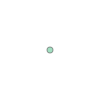

In [41]:
get_canonical_coords_google('807 BEACON CIR OAKDALE PA 15071')

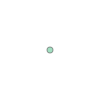

In [53]:
addr_to_coords('807 BEACON CIR OAKDALE PA 15071')

In [51]:
canonical_addr_map['807 BEACON CIR OAKDALE PA 15071']

{'canonical_in_census_db': False,
 'canonical_in_google_db': True,
 'census_block': u'420034580002086',
 'census_value': None,
 'google_value': u'{"status": "OK", "results": [{"geometry": {"location_type": "ROOFTOP", "bounds": {"northeast": {"lat": 40.3930951, "lng": -80.1582646}, "southwest": {"lat": 40.3929375, "lng": -80.1584087}}, "viewport": {"northeast": {"lat": 40.39436528029149, "lng": -80.1569876697085}, "southwest": {"lat": 40.3916673197085, "lng": -80.1596856302915}}, "location": {"lat": 40.393051, "lng": -80.15833959999999}}, "address_components": [{"long_name": "807", "types": ["street_number"], "short_name": "807"}, {"long_name": "Beacon Circle", "types": ["route"], "short_name": "Beacon Cir"}, {"long_name": "Oakdale", "types": ["locality", "political"], "short_name": "Oakdale"}, {"long_name": "Collier Township", "types": ["administrative_area_level_3", "political"], "short_name": "Collier Township"}, {"long_name": "Allegheny County", "types": ["administrative_area_level_

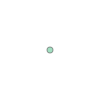

In [28]:
addr_to_coords('807 BEACON CIR OAKDALE PA 15071')

In [29]:
voter_map['109188400-02']

{'DOB': '4/15/1986',
 'addr_arr': [{'address': '807 BEACON CIR OAKDALE PA 15071',
   'census_block': u'420034580002086',
   'date': datetime.datetime(2018, 8, 24, 0, 0)}],
 'addresses': {'2018-08': '807 BEACON CIR OAKDALE PA 15071'},
 'reg_date': datetime.datetime(2018, 8, 24, 0, 0),
 'reg_info': {'2018-08': {'party': 'NF', 'status': 'A'}}}

In [52]:
# Reset
canonical_addr_map['807 BEACON CIR OAKDALE PA 15071']={'canonical_in_census_db': False,
 'canonical_in_google_db': False,
 'census_block': u'420034580002086',
 'census_value': None,
 'google_value': None}


# Process addrs_to_blocks_todo_set

In [689]:
# Construct GeoDataFrame from addrs_to_blocks and coords_to_blocks
todo_addrs_df = pd.DataFrame(addrs_to_blocks, columns=['address_raw'])
todo_geom_df = pd.Series(coords_to_blocks)

In [690]:
todo_gj = gpd.GeoDataFrame(todo_addrs_df, geometry=todo_geom_df,crs={'init': 'epsg:4326'})

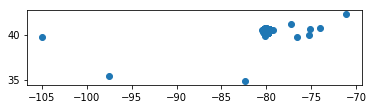

In [691]:
todo_gj.plot()

In [694]:
# Do spatial join to get census block for each address 
# Example from:
#    http://localhost:8820/notebooks/projects/demographics/Census-Planning-DB-2018.ipynb
# mob_blkgroups_gj = gpd.sjoin(blkgrps_cent_gj, mob_gj, how="inner", op='within')
todo_cb_gj = gpd.sjoin(todo_gj, ac_cb_gj, how="inner", op='within')

In [695]:
todo_cb_gj=todo_cb_gj.reset_index()

In [ ]:
todo_cb_gj

In [699]:
# Process all the newly processed census blocks into canonical_addr_map
process_addrs_to_cb_into_cam(todo_cb_gj)

1-1000: processing '438 FORTY-FOURTH ST PITTSBURGH PA 15201', 0:00:00.132714 time elapsed
1001-2000: processing '262 5 MC KEE PL PITTSBURGH PA 15213', 0:00:00.099588 time elapsed
2001-3000: processing '6102 LANDING LN MOON TWP PA 151084657', 0:00:00.100604 time elapsed
3001-4000: processing '159 B VICTORIA DR PITTSBURGH PA 15227', 0:00:00.114433 time elapsed
4001-5000: processing '5264 BECKY DR & RD PITTSBURGH PA 15236', 0:00:00.117148 time elapsed
5001-6000: processing '79 RIDGE RD RD4 BOX FINLEYVILLE PA 15332', 0:00:00.117216 time elapsed
6001-7000: processing '6 D BURNS HGTS DUQUESNE PA 15110', 0:00:00.113186 time elapsed
7001-8000: processing '47 MC KINLEY DR MC KEES ROCKS PA 15136', 0:00:00.116650 time elapsed
8001-9000: processing '939 MC COY RD MC KEES ROCKS PA 15136', 0:00:00.113068 time elapsed
9001-10000: processing '436 TENTH AVE E HOMESTEAD PA 15120', 0:00:00.115528 time elapsed
10001-11000: processing '1436 GRANT AVE BRADDOCK PA 15104', 0:00:00.103041 time elapsed
11001-12

In [229]:
list(todo_cb_gj.address_raw)

['205 BROOK ST MC DONALD PA 15057']

In [700]:
# Make a copy of addrs_to_blocks_todo_set to keep track of what addresses are left
# after we process the ones that came back with valid census blocks
failed_census_block_addrs = addrs_to_blocks_todo_set

# Remove all the elements that successfully generated census blocks
map(failed_census_block_addrs.remove, list(todo_cb_gj.address_raw))

# Update the vids in addrs_to_blocks_update_map={}
for addr in addrs_to_blocks_update_map:
    census_block = None
    # Check if this is a failed address
    if addr in failed_census_block_addrs:
        # Record 'census_block'=None in canonical_addr_map if not already recorded
        if(not 'census_block' in canonical_addr_map[addr]):
            canonical_addr_map[addr]['census_block']=None
    else:
        # Make sure addr is in canonical_addr_map
        if(not addr in canonical_addr_map or not 'census_block' in canonical_addr_map[addr]):
            print "ERROR: Trying to find census block for %s, but missing from canonical_addr_map" % (addr)
            continue
        # It is in canonical_addr_map, record the census block
        census_block = canonical_addr_map[addr]['census_block']
        
    # census_block should either be None or set to a valid value, record it in the relevant voter IDs.
    for vid in addrs_to_blocks_update_map[addr]:
        # Make sure vid is in voter_map
        if(not vid in voter_map):
            print "ERROR: Trying to update %s with census block %s, but missing from voter_map " % (vid, census_block)
            continue
        vrec = voter_map[vid]
        if(not 'addr_arr' in vrec):
            print "ERROR: Trying to update %s with census block %s, but 'addr_arr' missing from voter_map " % (vid, census_block)
            continue
        # Find the entry in addr_arr matching this address
        for i in range(0,len(voter_map[vid]['addr_arr'])):
            if(addr == voter_map[vid]['addr_arr'][i]['address']):
                # Matches! Update census block
                voter_map[vid]['addr_arr'][i]['census_block'] = census_block

In [233]:
'1741 BRODHEAD RD MOON TWP PA 15108' in addrs_to_blocks_update_map

True

In [701]:
failed_census_block_addrs

{'0 WARRENDALE AMBRIDGE RD2 WEXFORD PA 15090',
 '1000 RAILROAD ST MC DONALD PA 15057',
 '101 MONTROSE AVE FREEPORT PA 16229',
 '103 BARKING RD R D BOX NEW KENSINGTON PA 15068',
 '104 STATE RTE 8 BOX VALENCIA PA 16059',
 '105 GRANT ST MC DONALD PA 15057',
 '1050 GROVE CT W GIBSONIA PA 150446068',
 '1057 MC MONAGLE AVE FINLEYVILLE PA 15332',
 '106 MAIN RD BUNOLA PA 15020',
 '1136 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
 '116 G STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
 '117 G STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
 '119 G STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
 '119 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
 '121 FIRST ST E WEST MIFFLIN PA 15122',
 '122 G STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
 '123 ROBINSON RUN RD RD6 MCDONALD PA 15057',
 '1239 A STATE RTE 30 CLINTON PA 15026',
 '1239 STATE RTE 30 CLINTON PA 15026',
 '124 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
 '126 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
 '1268 A STATE RTE 30 CLINTON PA 15026',
 '

In [76]:
canonical_addr_map['620 TULLAMORE TRAIL MARS PA 16046']

{'canonical_in_census_db': True,
 'canonical_in_google_db': True,
 'census_block': None,
 'census_value': '{"result": {"addressMatches": [], "input": {"benchmark": {"benchmarkName": "Public_AR_Current", "id": "4", "isDefault": false, "benchmarkDescription": "Public Address Ranges - Current Benchmark"}, "address": {"address": "620 TULLAMORE TRAIL MARS PA 16046"}}}}',
 'google_value': '{"status": "OK", "results": [{"geometry": {"location_type": "APPROXIMATE", "bounds": {"northeast": {"lat": 40.702338, "lng": -80.00406799999999}, "southwest": {"lat": 40.6913781, "lng": -80.0243249}}, "viewport": {"northeast": {"lat": 40.702338, "lng": -80.00406799999999}, "southwest": {"lat": 40.6913781, "lng": -80.0243249}}, "location": {"lat": 40.6958996, "lng": -80.0117254}}, "formatted_address": "Mars, PA 16046, USA", "place_id": "ChIJ_VcUBgaGNIgRYWufKCeQGg0", "address_components": [{"long_name": "Mars", "types": ["locality", "political"], "short_name": "Mars"}, {"long_name": "Adams Township", "types"

In [79]:
coords = addr_to_coords('9441 NOBLESTOWN RD MC DONALD PA 15057')
print "%f %f" % (coords.y, coords.x)

40.366776 -80.284990


In [702]:
# Add failed_census_block_addrs to uncomputable_census_block_addrs_set
uncomputable_census_block_addrs_set = uncomputable_census_block_addrs_set.union(failed_census_block_addrs)
print "Added %d addrs to uncomputable_census_block_addrs_set, size now %d" % (len(failed_census_block_addrs), len(uncomputable_census_block_addrs_set))

Added 222 addrs to uncomputable_census_block_addrs_set, size now 493


In [703]:
# Reset TODO related variables to be empty
addrs_to_blocks_todo_set=set()
addrs_to_blocks=[]
coords_to_blocks=[]
addrs_to_blocks_update_map={}


In [196]:
# From ~/education/earthtime/voting/update_vids_in_addrs_to_blocks_update_map_out.txt
# These appear to be addresses that did not match to any of the census blocks
reprocess_addrs = ['14 BEECH ST AMBRIDGE PA 15003',
'245 ERMA ST RD1 MONONGAHELA PA 15063',
'915 INDIANA AVE GLASSPORT PA 15045',
'234 CENTER AVE CECIL PA 15321',
'896 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1036 OLD ORCHARD CT GIBSONIA PA 15044',
'1268 US ROUTE 30 CLINTON PA 15026',
'124 FINLEYVILLE R D 4 BOX FINLEYVILLE PA 15332',
'501 EASTVIEW DR IRWIN PA 15642',
'491 EASTVIEW DR IRWIN PA 15642',
'320 MILLERS-HILL RD RD2 BOX NEW KENSINGTON PA 15068',
'78 BEECH ST AMBRIDGE PA 15003',
'131 MAIN ST PO BOX RUSSELLTON PA 15076',
'277 STATE RTE 30 CLINTON PA 15026',
'1171 CAMBIER DR CRESCENT PA 15046',
'187 AIRPORT RD BELLE VERNON PA 15012',
'170 OLD JACKS RUN RD IRWIN PA 15642',
'106 DAVIS LN SEWICKLEY PA 15143',
'LOGANS FERRY RD NEW KENSINGTON PA 15068',
'405 PATRICKS PL MARS PA 16046',
'100 RIDGE RD RD1 MARS PA 16046',
'14 BEAVER ST AMBRIDGE PA 15003',
'2734 MILFORD DR BETHEL PARK PA 15102',
'961 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'205 BROOK ST MC DONALD PA 15057',
'101 PLEASANT RISE DR MCDONALD PA 15057',
'6 BEECH ST AMBRIDGE PA 15003',
'110 HIMALAYA RD MONROEVILLE PA 15146',
'337 COAL ST MCDONALD PA 15057',
'513 TUSCARORA RD MARS PA 16046',
'302 STATE RTE 8 BOX BAKERSTOWN PA 15007',
'162 RICHLAND MOBILE HOME PARK GIBSONIA PA 15044',
'FOX HILL BLACKBURN RD SEWICKLEY PA 15143',
'648 MILLERS RUN RD CECIL PA 15321',
'257 COLLINS AVE P O BOX CLAIRTON PA 15025',
'533 5TH ST TRAFFORD PA 15085',
'139 CHRISTY RD BOX TARENTUM PA 15084',
'STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1963 LINCOLN HWY NORTH VERSAILLES PA 15137',
'2100 SHORT ST FINLEYVILLE PA 15332',
'147 STATE RTE 30 CLINTON PA 15026',
'206 STATE RTE 51 RD4 BOX ELIZABETH PA 15037',
'500 BEAGLE CLUB RD MCDONALD PA 15057',
'1252 STATE RTE 30 CLINTON PA 15026',
'126 WOODLAWN AVE CECIL PA 15321',
'81 RIDGE RD MONONGAHELA PA 15063',
'224 RIDGE RD RD1 MARS PA 16046',
'22 FORBES RD TRAFFORD PA 15085',
'105 GRANT ST MCDONALD PA 15057',
'51 CHARLES ST CECIL PA 15321',
'4117 WINTERBURN AVE PITTSBURGH PA 15207',
'476 BEAGLE CLUB RD MC DONALD PA 15057',
'3780 FAIRVIEW DR MURRYSVILLE PA 15668',
'128 WOODLAWN AVE CECIL PA 15321',
'4 KRISTOFF LN MCDONALD PA 15057',
'145 RIDGE RD MONONGAHELA PA 15063',
'1385 STATE RTE 30 CLINTON PA 15026',
'979 CLINTON FRANKFORT RD BOX CLINTON PA 15026',
'1248 US ROUTE 30 CLINTON PA 15026',
'4305 WINTERBURN AVE PITTSBURGH PA 15207',
'5066 IMPALA DR PITTSBURGH PA 15239',
'172 CANNON HILL RD SAXONBURG PA 16056',
'1285 STATE RTE 30 CLINTON PA 15026',
'404 PATRICKS PL MARS PA 16046',
'119 RIDGE RD MONONGAHELA PA 15063',
'8 BEECH ST AMBRIDGE PA 15003',
'3401 LOGANS FERRY RD MURRYSVILLE PA 15668',
'590 OLD JACKS RUN RD IRWIN PA 15642',
'1971 GREENSBURG RD NEW KENSINGTON PA 15068',
'678 PRINCETON BLVD PITTSBURGH PA 15221',
'1297 STATE RTE 30 CLINTON PA 15026',
'1281 STATE RTE 30 CLINTON PA 15026',
'4 BEECH ST AMBRIDGE PA 15003',
'114 RIDGE RD MONONGAHELA PA 15063',
'1282 STATE RTE 30 CLINTON PA 15026',
'131 RIDGE RD MONONGAHELA PA 15063',
'1368 STATE RTE 30 CLINTON PA 15026',
'2 CENTER AVE RD1 BOX MONONGAHELA PA 15063',
'138 HIGH ST MC DONALD PA 15057',
'1035 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'123 RIDGE RD MONONGAHELA PA 15063',
'218 MONONGAHELA R D MONONGAHELA PA 15063',
'2900 COULTERVILLE RD MCKEESPORT PA 15131',
'476 BEAGLE CLUB RD MCDONALD PA 15057',
'181 ROBINSON RUN RD RD6 MCDONALD PA 15057',
'242 BLYTHE RD BOX MCDONALD PA 15057',
'185 GAYDOS LN SEWICKLEY PA 15143',
'490 OLD JACKS RUN RD IRWIN PA 15642',
'864 HILL ST NEW KENSINGTON PA 15068',
'54 CHARLES ST CECIL PA 15321',
'106 HIMALAYA RD MONROEVILLE PA 15146',
'230 CENTER AVE CECIL PA 15321',
'MANOWN RD PO BOX MONONGAHELA PA 15063',
'2104 SHORT ST FINLEYVILLE PA 15332',
'527 5TH ST TRAFFORD PA 15085',
'1039 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'44 ROBINSON RUN RD MC DONALD PA 15057',
'347 CENTER AVE MCDONALD PA 15057',
'116 RIDGE RD MONONGAHELA PA 15063',
'715 SCHOOL ST MC KEES ROCKS PA 15136',
'188 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 WARRENDALE RD MARS PA 16046',
'339 COAL ST MCDONALD PA 15057',
'1005 CONOVER DR NEW KENSINGTON PA 15068',
'225 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'215 KIRKWOOD DR PITTSBURGH PA 15215',
'142 CHRISTY RD TARENTUM PA 15084',
'236 CENTER AVE CECIL PA 15321',
'135 RIDGE RD MONONGAHELA PA 15063',
'164 CANNON HILL RD SAXONBURG PA 16056',
'10 NOBLESTOWN RD OAKDALE PA 15071',
'1360 US ROUTE 30 CLINTON PA 15026',
'337 CENTER AVE MC DONALD PA 15057',
'116 GRANT ST MC DONALD PA 15057',
'134 CHRISTY RD BOX TARENTUM PA 15084',
'113 RIDGE RD MONONGAHELA PA 15063',
'122 WOODLAWN AVE CECIL PA 15321',
'1285 US ROUTE 30 CLINTON PA 15026',
'1927 DIXIE LN MONONGAHELA PA 15063',
'118 RIDGE RD MONONGAHELA PA 15063',
'2 KRISTOFF LN MC DONALD PA 15057',
'491 OLD JACKS RUN RD IRWIN PA 15642',
'110 GRANT ST MCDONALD PA 15057',
'4218 LOGANS FERRY RD MURRYSVILLE PA 15668',
'145 STATE RTE 8 BOX VALENCIA PA 16059',
'343 COAL ST MCDONALD PA 15057',
'65 RIDGE RD MONONGAHELA PA 15063',
'118 WOODLAWN AVE CECIL PA 15321',
'WARRENDALE AMBRIDGE RD BADEN PA 15005',
'102 MONTROSE AVE FREEPORT PA 16229',
'116 HIMALAYA RD MONROEVILLE PA 15146',
'330 DEER CREEK RD GIBSONIA PA 15044',
'814 WETTACH ST PITTSBURGH PA 15212',
'120 WOODLAWN AVE CECIL PA 15321',
'325 COAL ST MCDONALD PA 15057',
'500 BEAGLE CLUB RD MC DONALD PA 15057',
'115 GRANT ST MCDONALD PA 15057',
'178 AIRPORT RD BELLE VERNON PA 15012',
'219 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'1132 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'67 ROBINSON RUN RD MC DONALD PA 15057',
'109 RIDGE RD MONONGAHELA PA 15063',
'144 CENTER AVE CECIL PA 15321',
'238 STATE RTE 51 FINLEYVILLE PA 15332',
'95 GLASGOW RD RD1 BOX VALENCIA PA 16059',
'1787 SILLVIEW DR PITTSBURGH PA 15243',
'1272 US ROUTE 30 CLINTON PA 15026',
'208 TECH RD PITTSBURGH PA 15205',
'327 COAL ST MC DONALD PA 15057',
'226 CENTER AVE CECIL PA 15321',
'1109 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'2821 BEECHWOOD BLVD PITTSBURGH PA 15217',
'WALKER RD RD MCDONALD PA 15057',
'60 CHARLES ST CECIL PA 15321',
'150 WILDFLOWER LN MARS PA 16046',
'36 BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'1370 STEWART RD MC DONALD PA 15057',
'184 ALDER ST RD3 BOX TARENTUM PA 15084',
'1270 STATE RTE 30 CLINTON PA 15026',
'404 MARBLE DR CRESCENT PA 15046',
'450 OLD JACKS RUN RD IRWIN PA 15642',
'71 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'236 STATE RTE 51 FINLEYVILLE PA 15332',
'196 WILMOT ST DUQUESNE PA 15110',
'126 RIDGE RD MONONGAHELA PA 15063',
'1081 BIG SEWICKLEY CREEK RD SEWICKLEY PA 15143',
'298 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'16 BEAVER ST AMBRIDGE PA 15003',
'100 RIDGE RD MONONGAHELA PA 15063',
'1929 DIXIE LN MONONGAHELA PA 15063',
'1360 STEWART RD MCDONALD PA 15057',
'2020 SNOWDEN RD FINLEYVILLE PA 15332',
'BLYTHEDALE (BAD ADD) BLYTHDALE PA 15013',
'245 KRAMER RD SOUTH PARK PA 15129',
'335 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'3629 LOGANS FERRY RD MURRYSVILLE PA 15668',
'52 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'245 SPRING ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MC DONALD PA 15057',
'1469 STATE RTE 30 CLINTON PA 15026',
'BROADHEAD TR CT LOT CORAOPOLIS PA 15108',
'PARK RD CECIL PA 15321',
'400 OLD JACKS RUN RD IRWIN PA 15642',
'1282 US ROUTE 30 CLINTON PA 15026',
'1926 DIXIE LN MONONGAHELA PA 15063',
'1963 BLYTHEDALE RD BUENA VISTA PA 15018',
'27 MAIN ST MCDONALD PA 15057',
'538 BEAGLE CLUB RD MCDONALD PA 15057',
'351 STATE RTE 30 CLINTON PA 15026',
'43 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'403 PATRICKS PL MARS PA 16046',
'104 RIDGE RD MONONGAHELA PA 15063',
'204 CRESCENT GARDEN DR PITTSBURGH PA 15235',
'228 CENTER AVE CECIL PA 15321',
'67 STATE RTE 8 BOX VALENCIA PA 16059',
'2020 HOOKSTOWN GRADE RD CLINTON PA 15026',
'203 WARRENDALE RD MARS PA 16046',
'60 DODDS AVE VALENCIA PA 16059',
'4 KRISTOFF LN MC DONALD PA 15057',
'1557 STATE RTE 30 CLINTON PA 15026',
'421 OLD JACKS RUN RD IRWIN PA 15642',
'139 STATE RTE 906 RD ELIZABETH PA 15037',
'543 5TH ST TRAFFORD PA 15085',
'345 SUNSET DR BADEN PA 15005',
'7536 MELROSE ST PITTSBURGH PA 15218',
'114 HIMALAYA RD MONROEVILLE PA 15146',
'2955 COULTERVILLE RD MCKEESPORT PA 15131',
'24 BEECH ST AMBRIDGE PA 15003',
'1270 US ROUTE 30 CLINTON PA 15026',
'1281 US ROUTE 30 CLINTON PA 15026',
'500 CENTER AVE CECIL PA 15321',
'234 RIDGE RD RD1 MARS PA 16046',
'1360 STATE RTE 30 CLINTON PA 15026',
'1223 COLLINS AVE JEFFERSON HILLS PA 15025',
'204 WARRENDALE RD MARS PA 16046',
'451 OLD JACKS RUN RD IRWIN PA 15642',
'323 COAL ST MCDONALD PA 15057',
'51 DEER CREEK RD GIBSONIA PA 15044',
'551 5TH ST TRAFFORD PA 15085',
'392 MILLERS RUN RD MORGAN PA 15064',
'508 TUSCARORA RD MARS PA 16046',
'130 RIDGE RD MONONGAHELA PA 15063',
'53 RIDGE RD MONONGAHELA PA 15063',
'57 RIDGE RD VALENCIA PA 16059',
'112 HIMALAYA RD MONROEVILLE PA 15146',
'289 CHARLES ST CECIL PA 15321',
'330 CENTER AVE MCDONALD PA 15057',
'101 PLEASANT RISE DR MC DONALD PA 15057',
'1403 STATE RTE 30 CLINTON PA 15026',
'78 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'97 BOCKTOWN RD RD1 BOX CLINTON PA 15026',
'369 OLD JACKS RUN RD IRWIN PA 15642',
'67 ROBINSON RUN RD MCDONALD PA 15057',
'1213 COLLINS AVE JEFFERSON HILLS PA 15025',
'8 CLINTON BOCKTOWN RD CLINTON PA 15026',
'1477 STATE RTE 30 CLINTON PA 15026',
'481 EASTVIEW DR IRWIN PA 15642',
'101 HILL ST MC DONALD PA 15057',
'200 WARRENDALE RD MARS PA 16046',
'1283 STATE RTE 30 CLINTON PA 15026',
'440 OLD JACKS RUN RD IRWIN PA 15642',
'202 WARRENDALE RD MARS PA 16046',
'2 KRISTOFF LN MCDONALD PA 15057',
'101 HILL ST MCDONALD PA 15057',
'212 CRAWFORD CT MARS PA 16046',
'508 SCENIC RIDGE DR FINLEYVILLE PA 15332',
'715 SCHOOL ST MCKEES ROCKS PA 15136',
'330 CENTER AVE MC DONALD PA 15057',
'10 RIDGE RD RD1 MARS PA 16046',
'123 STATE RTE 30 CLINTON PA 15026',
'44 ROBINSON RUN RD MCDONALD PA 15057',
'2 BEECH ST AMBRIDGE PA 15003',
'114 GRANT ST MCDONALD PA 15057',
'337 CENTER AVE MCDONALD PA 15057',
'232 CENTER AVE CECIL PA 15321',
'1136 US ROUTE 30 CLINTON PA 15026',
'402 SOUTHPOINT CT MCDONALD PA 15057',
'7 2ND ST PITTSBURGH PA 15215',
'535 5TH ST TRAFFORD PA 15085',
'1268 STATE RTE 30 CLINTON PA 15026',
'240 BLYTHE RD BOX MCDONALD PA 15057',
'499 CENTER AVE CECIL PA 15321',
'10 BEECH ST AMBRIDGE PA 15003',
'273 BOCKTOWN RD PO BOX CRESCENT PA 15046',
'215 STATE RTE 136 RD3 BOX MONONGAHELA PA 15063',
'201 MURRYSVILLE RD NEW KENSINGTON PA 15068',
'CHRISTY COR NEW KENSINGTON PA 15068',
'101 RIDGE RD MONONGAHELA PA 15063',
'1280 US ROUTE 30 CLINTON PA 15026']


In [200]:
reprocess_vids = set()

In [208]:
for this_addr in reprocess_addrs:
    map(reprocess_vids.add,addrs_to_blocks_update_map[this_addr])

In [210]:
len(reprocess_vids)

474

In [212]:
voter_process_address_history_array(list(reprocess_vids),True)

Processing took 0:00:00.038317 for 474 addresses


# Test voter_process_address_history_array components

In [86]:
voter_map[voter_map.keys()[0]]={'DOB': '1/8/1944',
 'addresses': {'2009-07': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2017-11': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-03': '415 CHESTNUT ST SPRINGDALE PA 15144',
  '2018-08': '415 CHESTNUT ST SPRINGDALE PA 15144'},
 'reg_date': datetime.datetime(1993, 4, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'D', 'status': 'A'},
  '2017-11': {'party': 'D', 'status': 'A'},
  '2018-03': {'party': 'D', 'status': 'A'},
  '2018-08': {'party': 'D', 'status': 'A'}}}

In [119]:
voter_map[voter_map.keys()[3]]={'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [120]:
i=3
voter_map[voter_map.keys()[i]]

{'DOB': '8/29/1972',
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [127]:
voter_process_address_history(voter_map.keys()[i], True)

[{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  'census_block': u'420035263012005',
  'date': datetime.datetime(1990, 10, 1, 0, 0)},
 {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  'date': datetime.datetime(2017, 11, 30, 0, 0)},
 {'address': '509 OCTOBER CT PLUM PA 15239',
  'census_block': None,
  'date': datetime.datetime(2018, 8, 14, 0, 0)}]

In [153]:
voter_map[voter_map.keys()[3]]

{'DOB': '8/29/1972',
 'addr_arr': [{'address': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
   'census_block': u'420035263012005',
   'date': datetime.datetime(1990, 10, 1, 0, 0)},
  {'address': '3014 SETTLERS CT MURRYSVILLE PA 15668',
   'census_block': u'420035263011014',
   'date': datetime.datetime(2017, 11, 30, 0, 0)},
  {'address': '509 OCTOBER CT PLUM PA 15239',
   'census_block': None,
   'date': datetime.datetime(2018, 8, 14, 0, 0)}],
 'addresses': {'2009-07': '1500 SUGARLOAF DR PITTSBURGH PA 15239',
  '2017-11': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-03': '3014 SETTLERS CT MURRYSVILLE PA 15668',
  '2018-08': '509 OCTOBER CT PLUM PA 15239'},
 'reg_date': datetime.datetime(1990, 10, 1, 0, 0),
 'reg_info': {'2009-07': {'party': 'R', 'status': 'A'},
  '2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [129]:
addrs_to_blocks_todo_set

{'3014 SETTLERS CT MURRYSVILLE PA 15668'}

In [130]:
addrs_to_blocks

['3014 SETTLERS CT MURRYSVILLE PA 15668']

In [131]:
coords_to_blocks

In [132]:
addrs_to_blocks_update_map

{'3014 SETTLERS CT MURRYSVILLE PA 15668': {'002323758-02'}}

# Generate random points in census blocks

In [704]:
# From http://localhost:8820/notebooks/projects/demographics/Get%20random%20census%20block%20points%20from%20prototiles.ipynb
import numpy as np
numpy_record_type = [('x','<f4'), ('y','<f4'), ('blockIdx', '<i4'), ('subIdx', '<i4')]
all_pts = np.memmap('prototiles/master-sorted-by-block.bin', dtype=numpy_record_type)

def find_point_idx(block_idx):
    min_idx = 0
    max_idx = len(all_pts) - 1
    while min_idx <= max_idx:
        test_idx = int((min_idx + max_idx) / 2)
        if block_idx > all_pts[test_idx][2]:
            min_idx = test_idx + 1
        elif block_idx < all_pts[test_idx][2] or all_pts[test_idx][3] != 0:
            max_idx = test_idx - 1
        else:
            return test_idx
    return [min_idx, max_idx]

        
def block_points(block_idx):
    ret = []
    idx = find_point_idx(block_idx)
    assert all_pts[idx][2] == block_idx and all_pts[idx][3] == 0
    while idx < len(all_pts):
        if all_pts[idx][2] == block_idx:
            ret.append({'x':all_pts[idx][0], 'y':all_pts[idx][1]})
        else:
            break
        idx += 1
    return ret

In [705]:
import json
block_geoids_2010 = json.load(open('block_geoids_2010.json'))

geoid2idx = {}
for i in range(0, len(block_geoids_2010)):
    geoid2idx[block_geoids_2010[i]] = i+1

In [706]:
# For each census block, keep track of what voter each index has been assigned to
# Top level key is census block number, secondary key is 'next' for keeping track of the next index to be assigned,
# 'points' for the value returned by block_points, and voter ID: index for other entries
block_id_use_map={}

In [707]:
# Keep track of which census blocks overflowed the number of points
block_id_overflow_set=set()

In [708]:
def block_get_voter_coords(census_block, vid):
    if(not census_block in block_id_use_map):
        # Need to create an entry, set 'next' to 0, initialize points
        # First convert from GEOID10 to the index into the block_idx
        block_idx = geoid2idx[census_block]
        point_arr = block_points(block_idx)
        block_id_use_map[census_block]={'next':0, 'points':point_arr, 'numpoints':len(point_arr)}
    # We know census_block is in block_id_use_map (which we may have just added)
    # Check if this voter ID is already registered
    if(vid in block_id_use_map[census_block]):
        # Already assigned, just use the same index as before
        point_idx=block_id_use_map[census_block][vid]
    else:
        # Not yet assigned, take the next available 
        # and increment 'next'
        point_idx = block_id_use_map[census_block]['next']
        if(point_idx>block_id_use_map[census_block]['numpoints']-1):
            # Overflow
            if(not census_block in block_id_overflow_set):
                block_id_overflow_set.add(census_block)
                print "WARNING: overflow in census block %s" % (census_block)
            # For now, just start reassigning numbers back at 0
            point_idx=0
            block_id_use_map[census_block]['next']=0
        block_id_use_map[census_block]['next'] = point_idx + 1
        block_id_use_map[census_block][vid] = point_idx
        
    # Retrieve the webmercator point from the points array.
    # Convert it to lat lon and create a Point to return.
    # Note that WebMercatorToLonLat(x,y) returns [lon, lat]
    # the args to create a Point are also (lon, lat)
    point_xy = block_id_use_map[census_block]['points'][point_idx]
    ll_arr = WebMercatorToLonLat(point_xy['x'],point_xy['y'])
    return Point(ll_arr[0], ll_arr[1])

In [709]:
def voter_get_coords_for_addr_history(vid, force_update):
    if(not vid in voter_map):
        print "WARNING: %s not in voter_map" % (vid)
        return
    vrec = voter_map[vid]
    if(not 'addr_arr' in vrec):
        print "WARNING: %s missing addr_arr in voter_map, re-run voter_process_address_history_array" % (vid)
        return

    addr_arr = vrec['addr_arr']
    for j in range(0,len(addr_arr)):
        addr_rec = vrec['addr_arr'][j]
        if(not 'census_block' in addr_rec):
            print "WARNING %s: '%s' lacks 'census_block', skipping" % (vid, this_addr)
            continue
        # census_block might be None, in which case don't get coords
        if(addr_rec['census_block']==None):
            continue
        try:
            coords = block_get_voter_coords(addr_rec['census_block'], vid)
            #print "Assigning %r to %s[%d]='%s'"%(coords, vid,j,addr_rec['census_block'])
            #voter_map[vid]['addr_arr'][j]['latlon'] = coords
            addr_rec['latlon'] = coords
        except Exception as e:
            print "ERROR: Exception getting coords for %s[%d]='%s': %s"%(vid,j,addr_rec['census_block'],e)

def voter_get_coords_for_addr_history_array(vid_arr, force_update):
    start=arrow.now()
    chunk_start_time=start
    chunk_size=10000

    for i in range(0,len(vid_arr)):
        vid = vid_arr[i]
        voter_get_coords_for_addr_history(vid, force_update)
        
        # Handle periodic debug message
        if((i%chunk_size)==0 and i>0):
            print "%d-%d: processing %r, %d in todo set, %d non-geolocatable, %s time elapsed" %(i-(chunk_size-1), i, vid, 
                                                                                                 len(addrs_to_blocks_todo_set), len(non_geolocatable_addrs_set),
                                                                                                 arrow.now()-chunk_start_time)
            addcnt=0
            chunk_start_time=arrow.now()

    end=arrow.now()
    print "Processing took %s for %d addresses" % (str(end-start), len(vid_arr))

In [710]:
voter_get_coords_for_addr_history_array(all_vids, False)

1-10000: processing '001908201-02', 0 in todo set, 11035 non-geolocatable, 0:00:20.375302 time elapsed
10001-20000: processing '001924282-02', 0 in todo set, 11035 non-geolocatable, 0:00:09.191062 time elapsed
20001-30000: processing '001938512-02', 0 in todo set, 11035 non-geolocatable, 0:00:05.504573 time elapsed
30001-40000: processing '001952522-02', 0 in todo set, 11035 non-geolocatable, 0:00:04.063262 time elapsed
40001-50000: processing '001970251-02', 0 in todo set, 11035 non-geolocatable, 0:00:02.949879 time elapsed
50001-60000: processing '001987383-02', 0 in todo set, 11035 non-geolocatable, 0:00:02.274451 time elapsed
60001-70000: processing '002002255-02', 0 in todo set, 11035 non-geolocatable, 0:00:01.944459 time elapsed
70001-80000: processing '002014747-02', 0 in todo set, 11035 non-geolocatable, 0:00:01.584972 time elapsed
80001-90000: processing '002026578-02', 0 in todo set, 11035 non-geolocatable, 0:00:01.217445 time elapsed
90001-100000: processing '002042794-02', 

620001-630000: processing '002828420-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.554493 time elapsed
630001-640000: processing '002840250-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.563908 time elapsed
640001-650000: processing '002854272-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.496904 time elapsed
650001-660000: processing '002870044-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.429611 time elapsed
660001-670000: processing '002883186-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.467964 time elapsed
670001-680000: processing '002898669-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.501610 time elapsed
680001-690000: processing '002917224-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.519041 time elapsed
690001-700000: processing '002933002-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.531844 time elapsed
700001-710000: processing '002946655-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.535224 time elapsed
710001-720000: proc

1100001-1110000: processing '102617556-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.471336 time elapsed
1110001-1120000: processing '102798362-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.421727 time elapsed
1120001-1130000: processing '102927532-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.415312 time elapsed
1130001-1140000: processing '103086375-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.415376 time elapsed
1140001-1150000: processing '103226775-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.423064 time elapsed
1150001-1160000: processing '103360382-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.430121 time elapsed
1160001-1170000: processing '103479048-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.426683 time elapsed
1170001-1180000: processing '103579895-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.430602 time elapsed
1180001-1190000: processing '103669302-02', 0 in todo set, 11035 non-geolocatable, 0:00:00.410025 time elapsed
1

In [711]:
len(block_id_overflow_set)

186

In [712]:
overflow_block_ids=list(block_id_overflow_set)
numpoints = map(lambda x: block_id_use_map[x]['numpoints'], overflow_block_ids)
numvoters = map(lambda x: len(block_id_use_map[x])-3, overflow_block_ids)

In [714]:
overflow_blocks_df=pd.DataFrame(zip(numpoints,numvoters),columns=['numpoints','numvoters'],index=overflow_block_ids)

In [715]:
overflow_blocks_df

,numpoints,numvoters
420031702001043,112,185
420031609002009,76,100
420031702001044,60,135
420030405002008,676,904
420030807002001,474,478
420030807002000,468,520
420034644003034,112,133
420030201006017,318,411
420034742022025,375,539
420030201005050,75,429


In [716]:
overflow_blocks_df.to_csv('voters/overflow_blocks_df.csv')

## Debug census block dots

In [378]:
voter_map[all_vids[1]]

{'DOB': '9/29/1926',
 'addr_arr': [{'address': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
   'census_block': None,
   'date': datetime.datetime(1956, 1, 1, 0, 0)},
  {'address': '1094 FOX CHAPEL RD PITTSBURGH PA 15238',
   'census_block': u'420034220001019',
   'date': datetime.datetime(2018, 8, 14, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4babaa1e90>}],
 'addresses': {'2017-11': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-03': '500 CHAPEL HARBOR DR PITTSBURGH PA 15238',
  '2018-08': '1094 FOX CHAPEL RD PITTSBURGH PA 15238'},
 'reg_date': datetime.datetime(1956, 1, 1, 0, 0),
 'reg_info': {'2017-11': {'party': 'R', 'status': 'A'},
  '2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [326]:
census_block = voter_map[all_vids[1]]['addr_arr'][1]['census_block']
census_block

u'420034220001019'

In [330]:
str(block_get_voter_coords(census_block, all_vids[1]))

'POINT (-79.86298799514771 40.53353520356066)'

In [345]:
len(block_id_use_map['420030201001005']['points'])

60

In [347]:
block_id_use_map['420030201001005']['next']

184

In [327]:
block_idx = geoid2idx[census_block]
block_idx

8118177

# Write out dots files

In [415]:
def color_from_floats(r,g,b):
    return r + g * 256.0 + b * 256.0 * 256.0

def pack_color(color):
    return color['r'] + color['g'] * 256.0 + color['b'] * 256.0 * 256.0;

def parse_color(color):
    color = color.strip()
    c = color
    try:
        if c[0] == '#':
            c = c[1:]
        if len(c) == 3:
            return pack_color({'r': 17 * int(c[0:1], 16),
                               'g': 17 * int(c[1:2], 16),
                               'b': 17 * int(c[2:3], 16)})
        if len(c) == 6:
            return pack_color({'r': int(c[0:2], 16),
                               'g': int(c[2:4], 16),
                               'b': int(c[4:6], 16)})
    except:
        pass
    raise InvalidUsage('Cannot parse color <code><b>%s</b></code> from spreadsheet.<br><br>Color must be in standard web form, <code><b>#RRGGBB</b></code>, where RR, GG, and BB are each two-digit hexadecimal numbers between 00 and FF.<br><br>See <a href="https://www.w3schools.com/colors/colors_picker.asp">HTML Color Picker</a>' % color)

def parse_colors(colors):
    packed = [parse_color(color) for color in colors]
    return numpy.array(packed, dtype = numpy.float32)

In [416]:
out_suffix="09_17_18_18_18"

In [417]:
max_datetime = dateparser.parse('12/31/3000')

In [ ]:
next((i for i in range(0,len(vote_arr) if vote_arr in vote_info_map and item[1]["date"] > cmp_date),None))


In [451]:

start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
#other_color = '#decc64'
other_color = '#505050'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)
vol_colors = ['#a50026','#cd2827','#e75436','#f7804b','#fdad61','#fed788','#ffffbf','#b9e0ed','#8dc0db','#699fca','#4d7db9','#3e5aa7','#313695']
def num_moves_to_color(vid, color_date):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    
    color = unknown_color
    addr_index=None
    
    # Find the index of the first address with addr_end_date > color_date
    for a_i in range(0,len(vrec['addr_arr'])):
        addr_rec = vrec['addr_arr'][a_i]

        # Get the start time for this address.
        addr_start_date = vrec['addr_arr'][a_i]['date']

        # Find the end time for this address.
        # If this is the last address 
        # and the voter hasn't moved away, set end_date to max
        addr_end_date=max_datetime
        if(a_i<len(vrec['addr_arr'])-1):
            # There's another address after this one, set end_date
            # to the start of the next address
            addr_end_date = vrec['addr_arr'][a_i+1]['date']
        else:
            # Check if they moved away
            moved_ms = check_voter_moved_away(vid)
            if(moved_ms):
                addr_end_date = monthstr_to_date_map[moved_ms]
        if(addr_end_date>color_date):
            addr_index=a_i
            break
            
    if(not addr_index==None):
        # We have a valid value, get the color
    
        if (addr_index < 1):
            color = vol_colors[0]
        #elif (volume < 3):
        #    return parse_color(vol_colors[1]) 
        #elif (volume < 4):
        #    return parse_color(vol_colors[2]) 
        #elif (volume < 5):
        #    return parse_color(vol_colors[3]) 
        elif (addr_index < 2):
            color = vol_colors[4]
        #elif (volume < 20):
        #    return parse_color(vol_colors[5]) 
        #elif (addr_index < 3):
        #    color = vol_colors[6]
        elif (addr_index < 3):
            color = vol_colors[7] 
        #elif (addr_index < 5):
        #    return parse_color(vol_colors[8]) 
        elif (addr_index < 4):
            color = vol_colors[9]
        #elif (volume < 300):
        #    return parse_color(vol_colors[10]) 
        #elif (volume < 500):
        #    return parse_color(vol_colors[11]) 
        else:
            color = vol_colors[12]
        
    return(color,addr_end_date)


# Takes the Voter ID and a date to generate a color for; 
# returns a tuple of (color,next_date)
vol_colors = ['#a50026','#cd2827','#e75436','#f7804b','#fdad61','#fed788','#ffffbf','#b9e0ed','#8dc0db','#699fca','#4d7db9','#3e5aa7','#313695']
# Keep track of the last color index and start date
# for each voter ID
# Key is vid, value is (last_vote_rec, next_vote_rec)
last_vr_color_state_map = {}

def get_vote_str_rec_on_or_after_date(vote_info_map, cmp_date):
    # Find and return the next item after this one in vote_arr or None if we're past the end 
    return (next((item for item in vote_arr if item[0] in vote_info_map and item[1]["date"] >= cmp_date),None))

def voting_recency_vid_to_color(vid, color_date):
    if (not vid in voter_map or not 'vote_info' in voter_map[vid]):
        return unknown_color
    vrec = voter_map[vid]
    vote_info_map=voter_map[vid]['vote_info']
    
    last_vote_date=None
    next_vote_date=None

    # Check if we remember an earlier vote
    reset_color_idx=True
    if(vid in last_vr_color_state_map):
        # We have a record, but it might be from a previous run
        (last_vote_rec,next_vote_rec) = last_vr_color_state_map[vid]
        if(last_vote_rec and ast_vote_rec['date']<=color_date):
            # It's from this run, keep it
            reset_color_idx=False
            if(last_vote_rec):
                last_vote_date =last_vote_rec[1]['date']
            if(next_vote_rec):
                next_vote_date =next_vote_rec[1]['date']
            
    if(reset_color_idx):
        # Start from scratch
        last_color_idx=None
        last_vote_rec=get_vote_str_rec_on_or_after_date(vote_info_map, color_date)
        if(last_vote_rec):
            last_vote_date =last_vote_rec[1]['date']
        next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
        if(next_vote_rec):
            next_vote_date =next_vote_rec[1]['date']
            
    # If last_vote_rec is None, that means we've run out of votes, return unknown_color and end of time
    if(not last_vote_rec):
        return(unknown_color, max_datetime)
    
    # We have a last_vote_rec, see if we need to update to the next one
    while(next_vote_rec and next_vote_date<=color_date):
        last_vote_rec = next_vote_rec
        last_vote_date= next_vote_date
        next_vote_rec=get_next_vote_str_rec_after_date(vote_info_map, last_vote_date)
        if(next_vote_rec):
                next_vote_date =next_vote_rec[1]['date']
        
    # last_vote_rec is the last available at or before color_date
    timedelta_since_last_vote = color_date-last_vote_date
    years_since_last_vote=int(timedelta_since_last_vote.days/365)
    
    print "%s: last=%s (%s), next=%s (%s), %d years since last vote" % (color_date, last_vote_date, last_vote_rec[0],
                                                                        next_vote_date, 
                                                                        next_vote_rec[0] if next_vote_rec else 'None',
                                                                        years_since_last_vote
                                                                       )
    # Save state for next time
    last_vr_color_state_map[vid]=(last_vote_rec, next_vote_rec)
        
    # vol_colors[len(vol_colors)-1] when < 1 year since last vote, vol_colors[0] if longer ago
    color_idx = math.max(len(vol_colors)-(1+years_since_last_vote),0)
    color=vol_colors[color_idx]
    
    # Compute the end time for this color.  If next_vote_date and it's < 1 from color_date, then use that.
    # Otherwise use color_date+1 year
    next_date = next_vote_date
    td_1yr = timedelta(days=365)
    next_year = color_date+td_1yr
    if(next_year<next_date):
        next_date = next_year
        
    print "  color = %s (%d), next_date=%s"% (color, color_idx, next_date)
    return(color, next_date)

# color_func(vid, color_date) returns (color, next_date)

def output_voter_reg_dots_f(vid_arr, color_func, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=10000
    dot_cnt=0
    
    for v_i in range(0,len(vid_arr)):
        try:
            vid = vid_arr[v_i]
            if(not vid in voter_map):
                continue
            vrec = voter_map[vid]

            if(not 'addr_arr' in vrec):
                continue

            # Get the month_str values in sorted order for this voter
            month_strs = sorted(vrec['reg_info'].keys())

            # Keep track of the date of the last datapoint. 
            # Initialize last_date to be the registration date for this voter

            last_date = vrec['reg_date']
            last_color=0


            # Keep track of the index of the next month_str
            next_month_str_i=0

            # Iterate over the addresses in addr_arr
            for a_i in range(0,len(vrec['addr_arr'])):
                addr_rec = vrec['addr_arr'][a_i]
                # If addr_rec is not plottable, skip it
                if(not 'latlon' in addr_rec):
                    continue

                # We have lat/lon for this address, continue
                centroid = addr_rec['latlon']
                if(not centroid):
                    continue

                # Get the start time for this address.
                addr_start_date = vrec['addr_arr'][a_i]['date']

                # Find the end time for this address.
                # If this is the last address 
                # and the voter hasn't moved away, set end_date to max
                addr_end_date=max_datetime
                if(a_i<len(vrec['addr_arr'])-1):
                    # There's another address after this one, set end_date
                    # to the start of the next address
                    addr_end_date = vrec['addr_arr'][a_i+1]['date']
                else:
                    # Check if they moved away
                    moved_ms = check_voter_moved_away(vid)
                    if(moved_ms):
                        addr_end_date = monthstr_to_date_map[moved_ms]
                        if((v_i%chunk_size)==0):
                            print "%s moved away by %s (%s)" % (vid, moved_ms,addr_end_date)

                if((v_i%chunk_size)==0):
                    print "%s[%d]: %s - %s [%s]" % (vid, a_i, addr_start_date, addr_end_date, last_date)

                # Call color_func and output dots until the date returned by color_func goes past the end of this address
                while(last_date<=addr_end_date):                    
                    did_output_dot=False

                    # Get color for this next chunk of time
                    (color, next_start_date) = color_func(vid, last_date)
                    
                    # Get range of dates for this color
                    startdate_epoch = GetEpoch(last_date)
                    enddate_epoch = GetEpoch(next_start_date)
                    if(color != None):
                        points += PointToPixelXY(centroid)     
                        points.append(parse_color(color))
                        points.append(float(startdate_epoch))
                        points.append(float(enddate_epoch))
                        if((v_i%chunk_size)==0):
                            print "  %s[%s]: %s - %s = %s" % (vid, a_i, last_date, next_start_date, color)
                    else:
                        print "Color of %s is None"

                    # Set last_date and last_color for next loop
                    last_date = next_start_date
                    last_color= color
                    did_output_dot=True
                    dot_cnt=dot_cnt+1
                    # Special case when next_start_date==addr_end_date
                    # to break out of the loop 
                    if(next_start_date>=addr_end_date):
                        break
                    # End of inner color_func loop
                # End of middle address_loop
            # End of try block at level of vid
        except:
            print "Unexpected error processing [%d] %s:" % (v_i, vid), sys.exc_info()[0]
            raise

        # Handle periodic debug message
        if((v_i%chunk_size)==0 and v_i>0):
            print "%d-%d: processing %r, %s time elapsed" %(v_i-(chunk_size-1), v_i, vid, arrow.now()-chunk_start_time)
            chunk_start_time=arrow.now()
                
    array.array('f', points).tofile(open(('voting/voter_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), dot_cnt)
    

In [441]:
start_date=dateparser.parse('1990-12-01')
(color, next_start_date) = num_moves_to_color('002015745-02', start_date)
print "%s, %s" % (color, next_start_date)

#a50026, 2017-11-30 00:00:00


In [439]:
start_date=dateparser.parse('2017-11-30')
num_moves_to_color('002015745-02', start_date)

('#fdad61', datetime.datetime(2018, 8, 14, 0, 0))

In [440]:
start_date=dateparser.parse('2018-08-14')
num_moves_to_color('002015745-02', start_date)

('#ffffbf', datetime.datetime(3000, 12, 31, 0, 0))

In [437]:
voter_map['002015745-02']

{'DOB': '3/17/1967',
 'addr_arr': [{'address': '210 SUNCREST ST PITTSBURGH PA 15210',
   'census_block': u'420033001005011',
   'date': datetime.datetime(1990, 12, 1, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f11df36a910>},
  {'address': '1922 WEBSTER AVE PITTSBURGH PA 15219',
   'census_block': u'420030305001006',
   'date': datetime.datetime(2017, 11, 30, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f11df36a990>},
  {'address': '35 ST JOHN ST MC KEES ROCKS PA 15136',
   'census_block': u'420034639003016',
   'date': datetime.datetime(2018, 8, 14, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f11df36a4d0>}],
 'addresses': {'2009-07': '210 SUNCREST ST PITTSBURGH PA 15210',
  '2017-11': '1922 WEBSTER AVE PITTSBURGH PA 15219',
  '2018-03': '1922 WEBSTER AVE PITTSBURGH PA 15219',
  '2018-08': '35 ST JOHN ST MC KEES ROCKS PA 15136',
  '2018-10': '35 ST JOHN ST MC KEES ROCKS PA 15136'},
 'reg_date': datetime.datetime(1990, 12, 1, 0, 0),
 'reg_info': {'2009

In [447]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_10[vdf_2018_10['Zip_Code']=='15213'].index)

In [448]:
output_voter_reg_dots_f(vids_15213[0:1000], num_moves_to_color, "09_17_18_18_18_15213_f1")

102892955-02[0]: 2010-09-28 00:00:00 - 3000-12-31 00:00:00 [2010-09-28 00:00:00]
  102892955-02[0]: 2010-09-28 00:00:00 - 3000-12-31 00:00:00 = #a50026
Processing took 0:00:00.079568 for 1086 dots


In [452]:
# Output all the voter dots for Allegheny County
# 17_18_18_18_c is all census_block points with independents in yellow
# 17_18_18_18_d is all census_block points with independents in dark grey
# 09_17_18_18_18_e is all census_block points with independents in dark grey and moved away checking
output_voter_reg_dots_f(all_vids, num_moves_to_color, "num_moves_09_17_18_18_18_f1")

001002451-02 moved away by 2017-11 (2017-11-30 00:00:00)
001002451-02[0]: 1951-01-01 00:00:00 - 2017-11-30 00:00:00 [1951-01-01 00:00:00]
  001002451-02[0]: 1951-01-01 00:00:00 - 2017-11-30 00:00:00 = #a50026
001910531-02[0]: 1959-08-01 00:00:00 - 3000-12-31 00:00:00 [1959-08-01 00:00:00]
  001910531-02[0]: 1959-08-01 00:00:00 - 3000-12-31 00:00:00 = #a50026
1-10000: processing '001910531-02', 0:00:00.640700 time elapsed
001931879-02 moved away by 2017-11 (2017-11-30 00:00:00)
001931879-02[0]: 1960-09-01 00:00:00 - 2017-11-30 00:00:00 [1960-09-01 00:00:00]
  001931879-02[0]: 1960-09-01 00:00:00 - 2017-11-30 00:00:00 = #a50026
10001-20000: processing '001931879-02', 0:00:00.550420 time elapsed
001946646-02 moved away by 2017-11 (2017-11-30 00:00:00)
001946646-02[0]: 1980-10-01 00:00:00 - 2017-11-30 00:00:00 [1980-10-01 00:00:00]
  001946646-02[0]: 1980-10-01 00:00:00 - 2017-11-30 00:00:00 = #a50026
20001-30000: processing '001946646-02', 0:00:00.585405 time elapsed
001964389-02[0]: 1988

002389748-02 moved away by 2017-11 (2017-11-30 00:00:00)
002389748-02[0]: 1955-08-01 00:00:00 - 2017-11-30 00:00:00 [1955-08-01 00:00:00]
  002389748-02[0]: 1955-08-01 00:00:00 - 2017-11-30 00:00:00 = #a50026
270001-280000: processing '002389748-02', 0:00:00.553863 time elapsed
002407419-02[0]: 1976-08-01 00:00:00 - 3000-12-31 00:00:00 [1976-08-01 00:00:00]
  002407419-02[0]: 1976-08-01 00:00:00 - 3000-12-31 00:00:00 = #a50026
280001-290000: processing '002407419-02', 0:00:00.542553 time elapsed
002423355-02[0]: 1984-09-01 00:00:00 - 2017-11-30 00:00:00 [1984-09-01 00:00:00]
  002423355-02[0]: 1984-09-01 00:00:00 - 2017-11-30 00:00:00 = #a50026
002423355-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [2017-11-30 00:00:00]
  002423355-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 = #fdad61
290001-300000: processing '002423355-02', 0:00:00.573070 time elapsed
002443761-02[0]: 1991-12-01 00:00:00 - 2017-11-30 00:00:00 [1991-12-01 00:00:00]
  002443761-02[0]: 1991-12-01 00:00:00 - 201

002901369-02[0]: 1988-07-01 00:00:00 - 3000-12-31 00:00:00 [1988-07-01 00:00:00]
  002901369-02[0]: 1988-07-01 00:00:00 - 3000-12-31 00:00:00 = #a50026
560001-570000: processing '002901369-02', 0:00:00.610146 time elapsed
002922116-02[0]: 1993-08-01 00:00:00 - 2017-11-30 00:00:00 [1993-08-01 00:00:00]
  002922116-02[0]: 1993-08-01 00:00:00 - 2017-11-30 00:00:00 = #a50026
002922116-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [2017-11-30 00:00:00]
  002922116-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 = #fdad61
570001-580000: processing '002922116-02', 0:00:00.613571 time elapsed
002939854-02[0]: 1998-03-01 00:00:00 - 3000-12-31 00:00:00 [1998-03-01 00:00:00]
  002939854-02[0]: 1998-03-01 00:00:00 - 3000-12-31 00:00:00 = #a50026
580001-590000: processing '002939854-02', 0:00:00.635752 time elapsed
002955305-02[0]: 2001-12-01 00:00:00 - 3000-12-31 00:00:00 [2001-12-01 00:00:00]
  002955305-02[0]: 2001-12-01 00:00:00 - 3000-12-31 00:00:00 = #a50026
590001-600000: processing '002

021047106-02[0]: 2007-07-28 00:00:00 - 2017-11-30 00:00:00 [2007-07-28 00:00:00]
  021047106-02[0]: 2007-07-28 00:00:00 - 2017-11-30 00:00:00 = #a50026
021047106-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 [2017-11-30 00:00:00]
  021047106-02[1]: 2017-11-30 00:00:00 - 3000-12-31 00:00:00 = #fdad61
850001-860000: processing '021047106-02', 0:00:00.635366 time elapsed
021141104-02[0]: 2007-12-23 00:00:00 - 3000-12-31 00:00:00 [2007-12-23 00:00:00]
  021141104-02[0]: 2007-12-23 00:00:00 - 3000-12-31 00:00:00 = #a50026
860001-870000: processing '021141104-02', 0:00:00.645392 time elapsed
021237030-02 moved away by 2017-11 (2017-11-30 00:00:00)
021237030-02[0]: 2008-03-01 00:00:00 - 2017-11-30 00:00:00 [2008-03-01 00:00:00]
  021237030-02[0]: 2008-03-01 00:00:00 - 2017-11-30 00:00:00 = #a50026
870001-880000: processing '021237030-02', 0:00:00.645395 time elapsed
021332932-02 moved away by 2017-11 (2017-11-30 00:00:00)
021332932-02[0]: 2008-04-01 00:00:00 - 2017-11-30 00:00:00 [2008-04-

Processing took 0:01:10.259761 for 1474456 dots


In [432]:
output_voter_reg_dots_c(vids_15213[0:1000], "1810_15213_c")

102892955-02[0]: 2010-09-28 00:00:00 - 3000-12-31 00:00:00 [2017-11 at 0]
  102892955-02[0][2017-11]: 2010-09-28 00:00:00 - 2017-11-26 00:00:00 = #decc64 (len 5)
  102892955-02[0][2018-03]: 2017-11-26 00:00:00 - 2018-03-26 00:00:00 = #decc64 (len 10)
  102892955-02[0][2018-08]: 2018-03-26 00:00:00 - 3000-12-31 00:00:00 = #decc64 (len 15)
Processing took 0:00:05.014690 for 3005 dots


In [429]:
voter_map[all_vids[26]]

{'DOB': '3/6/1968',
 'addr_arr': [{'address': '206 QUAIL CT BADEN PA 15005',
   'census_block': u'420034110003006',
   'date': datetime.datetime(1996, 12, 30, 0, 0),
   'latlon': <shapely.geometry.point.Point at 0x7f4bf71fdd10>}],
 'addresses': {'2018-03': '206 QUAIL CT BADEN PA 15005',
  '2018-08': '206 QUAIL CT BADEN PA 15005'},
 'reg_date': datetime.datetime(1996, 12, 30, 0, 0),
 'reg_info': {'2018-03': {'party': 'R', 'status': 'A'},
  '2018-08': {'party': 'R', 'status': 'A'}}}

In [427]:
monthstr_to_date_map

{'2009-07': datetime.datetime(2009, 7, 22, 0, 0),
 '2017-11': datetime.datetime(2017, 11, 30, 0, 0),
 '2018-03': datetime.datetime(2018, 3, 5, 0, 0),
 '2018-08': datetime.datetime(2018, 8, 14, 0, 0),
 '2018-10': datetime.datetime(2018, 10, 16, 0, 0)}

In [414]:
# This is an old version before adding addr_arr and census block handling
start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        
        # Initially, 'reg_date' was a string.  The conversion here was taking 
        # too long, so I converted it to be output from dateparser.parse(vrec['reg_date']) 
        # at ~9am 10/22/18 (_b.pickle and later).  Double check here
        # that the stored type isn't a string and skip if it is.
        if(isinstance(vrec['reg_date'], basestring)):
            print "Unconverted reg_date for %s: %s, skipping" % (vid, vrec['reg_date'])
            continue
            
        last_date = vrec['reg_date']
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    

In [54]:
all_vids=sorted(voter_map.keys())

In [160]:
len(all_vids)

1196866

In [ ]:
# Output all the voter dots for Allegheny County
output_voter_reg_dots(all_vids, "17_18_18_b")

  001004817-02: 2017-11 = #db0404
Cannot compute coords for 001008094-02, 2017-11 = '2453 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 001022781-02, 2017-11 = '332 INDIAN RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 001039005-02, 2017-11 = '126 JACKSON AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 001057292-02, 2017-11 = '412 GREEN ST MUNHALL PA 15120', skipping
Cannot compute coords for 001065524-02, 2017-11 = '1604 JEFFERSON RIDGE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001067337-02, 2017-11 = '148 OAKVILLE DR PITTSBURGH PA 15220', skipping
Cannot compute coords for 001233910-02, 2017-11 = '102 GRAHAM ST S PITTSBURGH PA 15206', skipping
1-1000: processing '001303897-02', 0:00:48.397881 time elapsed
  001303897-02: 2018-08 = #decc64
Cannot compute coords for 001307339-02, 2017-11 = '2031 BROAD HILL FARMS RD MOON TWP PA 15108', skipping
Cannot compute coords for 001309404-02, 2017-11 = '1509 STAUNTON DR 

Cannot compute coords for 001376037-02, 2017-11 = '138 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376398-02, 2017-11 = '123 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376473-02, 2017-11 = '309 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376491-02, 2017-11 = '178 CIMARRON DR MOON TWP PA 15108', skipping
Cannot compute coords for 001376789-02, 2017-11 = '1156 QUEENS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001377373-02, 2017-11 = '915 TALISMAN LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001377423-02, 2017-11 = '1522 VENTANA DR CORAOPOLIS PA 15108', skipping
Cannot compute coords for 001377539-02, 2017-11 = '1030 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001377593-02, 2017-11 = '217 TIMBERYOKE DR MOON TWP PA 15108', skipping
Cannot compute coords for 001378928-02, 2017-11 = '114 BOGGS AVE MOON TWP PA 15108', skipping
Cannot compute coords f

Cannot compute coords for 001562160-02, 2017-11 = '271 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 001562996-02, 2018-08 = '2321 MASONIC DR SEWICKLEY PA 15143', skipping
14001-15000: processing '001574128-02', 0:00:51.060807 time elapsed
  001574128-02: 2018-08 = #db0404
Google: Fetch '225 STATE RTE 908 NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Cannot compute coords for 001574448-02, 2017-11 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001574448-02, 2018-03 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001574448-02, 2018-08 = '225 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001578630-02, 2017-11 = '319 CEDAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 001579300-02, 2017-11 = '8720 BARKHURST DR E PITTSBURGH PA 15237', skipping
Cannot compute coords for 001581457-02, 2017-11 = '25 HARRISON AVE N PITTSBURGH PA 1520

Cannot compute coords for 001915443-02, 2017-11 = '156 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915452-02, 2017-11 = '114 LYCOMING DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915469-02, 2017-11 = '613 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915470-02, 2017-11 = '5004 STAGS LEAP LN MOON TWP PA 15108', skipping
Cannot compute coords for 001915471-02, 2017-11 = '1432 ROSEDALE ST MOON TWP PA 15108', skipping
Cannot compute coords for 001915475-02, 2017-11 = '1889 BEECHFORD AVE MOON TWP PA 15108', skipping
Cannot compute coords for 001915478-02, 2017-11 = '1500 WOODCREST AVE MOON TWP PA 15108', skipping
Cannot compute coords for 001915515-02, 2017-11 = '234 MCCARTNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915523-02, 2017-11 = '215 SNYDER DR MOON TWP PA 15108', skipping
Cannot compute coords for 001915540-02, 2017-11 = '254 LYTTON RD MOON TWP PA 15108', skipping
24001-25000: processing '0019

Cannot compute coords for 001933672-02, 2017-11 = '123 MILLER AVE W MUNHALL PA 15120', skipping
39001-40000: processing '001933821-02', 0:00:30.411112 time elapsed
  001933821-02: 2017-11 = #0000fb
Cannot compute coords for 001933917-02, 2017-11 = '198 MEADOWFIELD LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001933985-02, 2017-11 = '3421 WASHINGTON RD CLINTON PA 15026', skipping
Cannot compute coords for 001934003-02, 2017-11 = '1204 BRIERLY LN MUNHALL PA 15120', skipping
Cannot compute coords for 001934082-02, 2017-11 = '194 MEADOWFIELD LN JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001934098-02, 2017-11 = '140 TORY RD MOON TWP PA 15108', skipping
Cannot compute coords for 001934118-02, 2017-11 = '103 HAZELNUT ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001934241-02, 2017-11 = '317 SMALLWOOD DR MOON TWP PA 15108', skipping
Cannot compute coords for 001934350-02, 2017-11 = '1612 GLENBROOK AVE MOON TWP PA 15108', skipping
40001-

Cannot compute coords for 001938975-02, 2017-11 = '929 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 001939052-02, 2017-11 = '427 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
48001-49000: processing '001939096-02', 0:00:36.968745 time elapsed
  001939096-02: 2018-03 = #decc64
Cannot compute coords for 001939120-02, 2017-11 = '123 SCHUCHERT ST PITTSBURGH PA 15210', skipping
Cannot compute coords for 001939341-02, 2017-11 = '4364 BRIGHTVIEW AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 001939417-02, 2017-11 = '301 VINE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001939595-02, 2017-11 = '3413 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
49001-50000: processing '001939689-02', 0:00:27.327783 time elapsed
  001939689-02: 2018-08 = #db0404
Cannot compute coords for 001939697-02, 2018-08 = '2207 LINDALON DR MC KEESPORT PA 15135', skipping
Cannot compute coords for 001940115-02, 2017-11 = '118 DARNLEY DR MOON TWP PA 15108', skippi

Cannot compute coords for 001947715-02, 2017-11 = '207 LARKSPUR ST E MUNHALL PA 15120', skipping
Cannot compute coords for 001947882-02, 2017-11 = '533 9TH AVE W TARENTUM PA 15084', skipping
62001-63000: processing '001948027-02', 0:00:31.341650 time elapsed
  001948027-02: 2017-11 = #0000fb
Cannot compute coords for 001948296-02, 2017-11 = '123 COTTONWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 001948400-02, 2017-11 = '5005 STAGS LEAP LN MOON TWP PA 15108', skipping
Cannot compute coords for 001948415-02, 2017-11 = '115 4TH ST S DUQUESNE PA 15110', skipping
Cannot compute coords for 001948573-02, 2017-11 = '203 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 001948698-02, 2017-11 = '202 12TH AVE E HOMESTEAD PA 15120', skipping
63001-64000: processing '001948725-02', 0:00:39.562924 time elapsed
  001948725-02: 2018-03 = #db0404
Cannot compute coords for 001948819-02, 2017-11 = '204 PINE ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 

Cannot compute coords for 001957136-02, 2017-11 = '63 HOWARD AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 001957178-02, 2017-11 = '4629 LAWNVIEW DR W PITTSBURGH PA 15227', skipping
75001-76000: processing '001957223-02', 0:00:41.174075 time elapsed
  001957223-02: 2018-08 = #0000fb
Cannot compute coords for 001957226-02, 2017-11 = '208 ANDREW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001957389-02, 2017-11 = '128 GRAHAM ST S PITTSBURGH PA 15206', skipping
Cannot compute coords for 001957465-02, 2017-11 = '18 FOSTER SQ PITTSBURGH PA 15212', skipping
Cannot compute coords for 001957594-02, 2017-11 = '320 D GATEWAY TRS FT DUKE BLVD PITTSBURGH PA 15222', skipping
Cannot compute coords for 001957662-02, 2017-11 = '217 HOMEWOOD AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 001957821-02, 2017-11 = '3361 WOODWIND DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001957918-02, 2017-11 = '122 MARZOLF RD PITTSBURGH PA 15209',

87001-88000: processing '001967252-02', 0:00:37.104592 time elapsed
  001967252-02: 2018-03 = #0000fb
Cannot compute coords for 001967391-02, 2017-11 = '330 BROADWAY EXT NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 001967451-02, 2017-11 = '44 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 001967895-02, 2017-11 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001967895-02, 2018-03 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001967895-02, 2018-08 = '2093 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Google: Fetch '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065' seemed to succeed, but results empty or non-unique
Cannot compute coords for 001968003-02, 2017-11 = '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001968003-02, 2018-03 = '1116 STATE RTE 908 NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 001968003-02, 2018-08 = '1116 

Cannot compute coords for 001975487-02, 2017-11 = '925 FOSTER RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001975512-02, 2017-11 = '125 JAMESTOWN RD S MOON TWP PA 15108', skipping
Cannot compute coords for 001975608-02, 2017-11 = '78 RIDGE RD RD1 CARNEGIE PA 15106', skipping
Cannot compute coords for 001975614-02, 2017-11 = '131 HONEYCRISP LN PITTSBURGH PA 15201', skipping
Cannot compute coords for 001975760-02, 2017-11 = '401 DAYS RUN RD TARENTUM PA 15084', skipping
Cannot compute coords for 001976104-02, 2017-11 = '1150 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001976217-02, 2017-11 = '7507 ELLELMERE ST SWISSVALE PA 15218', skipping
97001-98000: processing '001976261-02', 0:00:31.134675 time elapsed
  001976261-02: 2018-08 = #decc64
Cannot compute coords for 001976348-02, 2017-11 = '409 HOMEWOOD AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 001976490-02, 2017-11 = '103 CRANSTON DR MOON TWP PA 15108', skipping
Cann

Cannot compute coords for 001985490-02, 2017-11 = '1213 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 001985682-02, 2017-11 = '1376 4TH ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001985727-02, 2017-11 = '13224 CLUB HOUSE RD PRESTO PA 15142', skipping
Cannot compute coords for 001985745-02, 2017-11 = '313 STETTLER DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001985773-02, 2018-08 = '150 MUIRFIELD DR PITTSBURGH PA 15229', skipping
Cannot compute coords for 001985821-02, 2017-11 = '139 RIVER CREST DR MOON TWP PA 15108', skipping
109001-110000: processing '001986003-02', 0:00:29.842858 time elapsed
  001986003-02: 2018-08 = #0000fb
Cannot compute coords for 001986053-02, 2017-11 = '7609 ROSLYN ST SWISSVALE PA 15218', skipping
Cannot compute coords for 001986105-02, 2017-11 = '96 BRYANT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 001986263-02, 2017-11 = '524 ST GEORGE DR NORTH VERSAILLES PA 15137', skippin

Cannot compute coords for 001993265-02, 2017-11 = '16 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 001993354-02, 2017-11 = '217 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 001993361-02, 2017-11 = '203 7TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 001993463-02, 2017-11 = '204 LARKSPUR ST E MUNHALL PA 15120', skipping
119001-120000: processing '001993584-02', 0:00:52.265463 time elapsed
  001993584-02: 2017-11 = #0000fb
Cannot compute coords for 001993753-02, 2018-03 = '49 BELLECREST AVE W PITTSBURGH PA 15227', skipping
Cannot compute coords for 001993899-02, 2017-11 = '1043 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 001994251-02, 2017-11 = '305 MORAY DR MOON TWP PA 15108', skipping
Cannot compute coords for 001994271-02, 2017-11 = '112 NEY DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 001994285-02, 2017-11 = '122 LYCOMING DR MOON TWP PA 15108', skipping
Cannot compute

Cannot compute coords for 002000684-02, 2017-11 = '1001 THORN RUN RD MOON TWP PA 15108', skipping
Cannot compute coords for 002000774-02, 2017-11 = '126 MARIGOLD ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002000905-02, 2017-11 = '400 CUMBERLAND WOODS DR ALLISON PARK PA 15101', skipping
Cannot compute coords for 002001151-02, 2017-11 = '334 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002001217-02, 2017-11 = '332 COLLEGE PARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002001224-02, 2017-11 = '2017 STILLEY RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002001226-02, 2017-11 = '123 GARDEN RD W PITTSBURGH PA 15227', skipping
129001-130000: processing '002001259-02', 0:00:42.806994 time elapsed
  002001259-02: 2017-11 = #db0404
Cannot compute coords for 002001266-02, 2017-11 = '2202 TEE CT PRESTO PA 15142', skipping
Cannot compute coords for 002001267-02, 2017-11 = '1207 HARROW HILL CT MOON TWP PA 15108', skipping
Ca

Cannot compute coords for 002008987-02, 2017-11 = '37 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002009032-02, 2017-11 = '122 FRANCIS AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 002009061-02, 2017-11 = '1350 EVERS DR PITTSBURGH PA 15206', skipping
Cannot compute coords for 002009260-02, 2017-11 = '314 8TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002009291-02, 2017-11 = '1028 SANDHURST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002009333-02, 2017-11 = '21 BRYANT AVE N PITTSBURGH PA 15202', skipping
Cannot compute coords for 002009341-02, 2017-11 = '35 HOWARD AVE S PITTSBURGH PA 15202', skipping
140001-141000: processing '002009449-02', 0:00:33.871621 time elapsed
  002009449-02: 2018-08 = #db0404
Cannot compute coords for 002009638-02, 2017-11 = '116 NIKE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002009721-02, 2017-11 = '2302 MEADOW VUE DR MOON TWP PA 15108', skipping
Cannot compute coords f

Cannot compute coords for 002016942-02, 2017-11 = '148 MANILLA AVE W PITTSBURGH PA 15220', skipping
Cannot compute coords for 002017041-02, 2017-11 = '268 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002017252-02, 2017-11 = '117 13TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002017275-02, 2017-11 = '805 MONROE CIR E PITTSBURGH PA 15229', skipping
151001-152000: processing '002017327-02', 0:00:45.531035 time elapsed
  002017327-02: 2018-03 = #decc64
Cannot compute coords for 002017427-02, 2017-11 = '3027 CHESTNUT RIDGE DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 002017610-02, 2017-11 = '816 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 002017676-02, 2017-11 = '154 JAMESTOWN RD S MOON TWP PA 15108', skipping
Cannot compute coords for 002017679-02, 2017-11 = '81 HARRISON AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002017681-02, 2017-11 = '303 FILLY CIR CLINTON PA 15026', skipping
Can

Cannot compute coords for 002022820-02, 2017-11 = '1840 STATE RTE 885 CLAIRTON RD WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002022913-02, 2017-11 = '528 MURTLAND ST S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002023037-02, 2017-11 = '118 LANSDOWNE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002023068-02, 2017-11 = '13202 CLUB HOUSE RD PRESTO PA 15142', skipping
Cannot compute coords for 002023114-02, 2017-11 = '106 GILLCREST DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002023211-02, 2017-11 = '17 C MIDWAY DR APT BLDG C WEST MIFFLIN PA 15122', skipping
160001-161000: processing '002023308-02', 0:00:57.467203 time elapsed
  002023308-02: 2018-08 = #decc64
Cannot compute coords for 002023380-02, 2017-11 = '112 BRYANT AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002023559-02, 2017-11 = '1145 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002023565-02, 2017-11 = '111 STEVENS RIDG

Cannot compute coords for 002032304-02, 2017-11 = '3005 NOTTINGHILL DR MOON TWP PA 15108', skipping
Cannot compute coords for 002032321-02, 2017-11 = '259 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002032324-02, 2017-11 = '456 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002032336-02, 2017-11 = '223 MCCARTNEY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002032359-02, 2017-11 = '231 WYNGATE RD MOON TWP PA 15108', skipping
Google: Fetch '434 MONROE CT PITTSBURGH PA 15243' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002032652-02, 2017-11 = '434 MONROE CT PITTSBURGH PA 15243', skipping
Cannot compute coords for 002033040-02, 2017-11 = '20 MEYERS ST W PITTSBURGH PA 15210', skipping
Cannot compute coords for 002033145-02, 2017-11 = '179 LARKSPUR ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002033161-02, 2017-11 = '130 VIRGINIA AVE E MUNHALL PA 15120', skipping
Cannot compute coor

Cannot compute coords for 002050108-02, 2017-11 = '535 ELMER WILLIAMS SQ PITTSBURGH PA 15206', skipping
181001-182000: processing '002050138-02', 0:00:32.015082 time elapsed
  002050138-02: 2018-08 = #0000fb
Google: Fetch '715 PENNSBURY BLVD S PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002050249-02, 2017-11 = '715 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002050249-02, 2018-03 = '715 PENNSBURY BLVD S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002050294-02, 2017-11 = '207 FAIRMOUNT ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002050309-02, 2017-11 = '314 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002050337-02, 2018-08 = '321 DUPONT DR MC DONALD PA 15057', skipping
Cannot compute coords for 002050452-02, 2017-11 = '104 RED CLIFFE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002050551-02, 2017-11 = '1614 GLENBROOK AVE MOON TWP PA 

Cannot compute coords for 002056609-02, 2017-11 = '1101 RIVER FRONT DR PITTSBURGH PA 15238', skipping
192001-193000: processing '002056609-02', 0:00:27.645700 time elapsed
  002056609-02: 2018-08 = #0000fb
Cannot compute coords for 002056683-02, 2017-11 = '8744 BARKHURST DR W PITTSBURGH PA 15237', skipping
Cannot compute coords for 002056722-02, 2017-11 = '403 CRIDERS LN PITTSBURGH PA 15237', skipping
Cannot compute coords for 002056813-02, 2017-11 = '9 FERN CIR PITTSBURGH PA 15224', skipping
Cannot compute coords for 002056835-02, 2017-11 = '267 FOSTER RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002056997-02, 2017-11 = '311 MAIN ST S SHARPSBURG PA 15215', skipping
Cannot compute coords for 002057038-02, 2017-11 = '400 MEADE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002057151-02, 2018-08 = '5214 RIVERFRONT DR PITTSBURGH PA 15238', skipping
193001-194000: processing '002057199-02', 0:00:24.979266 time elapsed
  002057199-02: 2018-08 = #0000fb
Cannot

Cannot compute coords for 002063520-02, 2017-11 = '121 BON HIGHLAND DR MOON TWP PA 15108', skipping
Cannot compute coords for 002063611-02, 2017-11 = '923 A NEGLEY AVE N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002063762-02, 2017-11 = '313 BLAKE CT MOON TWP PA 15108', skipping
Cannot compute coords for 002063806-02, 2017-11 = '320 MOON CLINTON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002064021-02, 2017-11 = '2 A NORTH BRADDOCK HTS BRADDOCK PA 15104', skipping
Cannot compute coords for 002064063-02, 2017-11 = '1209 SEIDEL ST PITTSBURGH PA 15212', skipping
204001-205000: processing '002064086-02', 0:00:34.710673 time elapsed
  002064086-02: 2018-03 = #0000fb
Cannot compute coords for 002064096-02, 2017-11 = '123 EUCLID AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002064125-02, 2017-11 = '190 A UPPER HECKMAN RD NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002064149-02, 2017-11 = '153 16TH AVE W HOMESTEAD PA 15120', skipp

Cannot compute coords for 002072376-02, 2017-11 = '210 THORNWOOD CT MOON TWP PA 15108', skipping
Cannot compute coords for 002072379-02, 2017-11 = '116 RED CLIFFE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002072669-02, 2017-11 = '516 RIDERS WAY MOON TWP PA 15108', skipping
Cannot compute coords for 002072845-02, 2017-11 = '419 POPLAR CT MOON TWP PA 15108', skipping
217001-218000: processing '002072969-02', 0:00:32.593155 time elapsed
  002072969-02: 2017-11 = #0000fb
Cannot compute coords for 002073033-02, 2017-11 = '80 EMILY ST N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002073242-02, 2017-11 = '527 WARRINGTON AVE E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002073298-02, 2017-11 = '101 LEE RIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002073627-02, 2017-11 = '314 1ST ST BOX WEST ELIZABETH PA 15088', skipping
218001-219000: processing '002073699-02', 0:00:36.443816 time elapsed
  002073699-02: 2017-11 = #decc64
Cann

Cannot compute coords for 002083368-02, 2017-11 = '171 DIX DR NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002083433-02, 2017-11 = '7512 ELLELMERE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002083457-02, 2017-11 = '51 BOYDS RUN RD OAKDALE PA 15071', skipping
Cannot compute coords for 002083692-02, 2017-11 = '3404 WARWICK CT MOON TWP PA 15108', skipping
230001-231000: processing '002083709-02', 0:00:42.535835 time elapsed
  002083709-02: 2018-03 = #decc64
Cannot compute coords for 002083798-02, 2017-11 = '1816 CLARK ST PITTSBURGH PA 15221', skipping
Cannot compute coords for 002083978-02, 2017-11 = '185 SHAFER RD MOON TWP PA 15108', skipping
Cannot compute coords for 002084344-02, 2017-11 = '7227 BEACON HILL DR PITTSBURGH PA 15221', skipping
Cannot compute coords for 002084436-02, 2017-11 = '9257 A PINE ST PITTSBURGH PA 15239', skipping
Cannot compute coords for 002084483-02, 2017-11 = '922 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords

Cannot compute coords for 002093905-02, 2017-11 = '1202 ELECTRIC AVE EAST PITTSBURGH PA 15112', skipping
Cannot compute coords for 002093975-02, 2017-11 = '125 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002094567-02, 2017-11 = '200 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002094599-02, 2017-11 = '125 GLENGARRY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002094617-02, 2017-11 = '314 MAC NAB DR MOON TWP PA 15108', skipping
242001-243000: processing '002094705-02', 0:00:42.375987 time elapsed
  002094705-02: 2017-11 = #0000fb
Cannot compute coords for 002094925-02, 2017-11 = '3100 STILLEY ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002094984-02, 2017-11 = '505 GEORGETOWN CT WEXFORD PA 15090', skipping
Cannot compute coords for 002095079-02, 2017-11 = '7 WELLINGTON DR PITTSBURGH PA 15229', skipping
Cannot compute coords for 002095079-02, 2018-03 = '7 WELLINGTON DR PITTSBURGH PA 15229', skipping
Can

Cannot compute coords for 002104117-02, 2017-11 = '311 11TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002104197-02, 2017-11 = '1038 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002104331-02, 2017-11 = '224 CLUBSIDE DR MOON TWP PA 15108', skipping
254001-255000: processing '002104345-02', 0:00:27.886329 time elapsed
  002104345-02: 2018-03 = #0000fb
Cannot compute coords for 002104635-02, 2017-11 = '1156 ALICE AVE JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002105107-02, 2017-11 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002105107-02, 2018-03 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
Cannot compute coords for 002105107-02, 2018-08 = '40 STEUBEN ST E PITTSBURGH PA 15205', skipping
255001-256000: processing '002105136-02', 0:00:26.583164 time elapsed
  002105136-02: 2018-03 = #db0404
Cannot compute coords for 002105245-02, 2017-11 = '146 STOEBNER WAY PITTSBURGH PA 15206', skipping
C

265001-266000: processing '002112776-02', 0:01:03.247480 time elapsed
  002112776-02: 2017-11 = #decc64
Cannot compute coords for 002112797-02, 2017-11 = '1312 MARION CIR CLAIRTON PA 15025', skipping
Cannot compute coords for 002112920-02, 2017-11 = '222 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002112974-02, 2017-11 = '906 TALISMAN LN NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002113048-02, 2018-08 = '942 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113065-02, 2017-11 = '207 WESTBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113288-02, 2017-11 = '117 16TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002113357-02, 2017-11 = '111 BENTLY DOWN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002113406-02, 2017-11 = '1446 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002113412-02, 2017-11 = '111 LOCUST ST PITTSBURGH PA 15223', skipping
Cannot co

Cannot compute coords for 002119410-02, 2018-08 = '1307 GLADWELL BRIDGEVILLE PA 15017', skipping
Cannot compute coords for 002119523-02, 2017-11 = '356 13TH AVE W HOMESTEAD PA 15120', skipping
Google: Fetch '1036 FINDLEY DR W PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002119588-02, 2017-11 = '1036 FINDLEY DR W PITTSBURGH PA 15221', skipping
274001-275000: processing '002119753-02', 0:00:40.537686 time elapsed
  002119753-02: 2018-03 = #0000fb
Cannot compute coords for 002119855-02, 2017-11 = '2404 HENDERSON DR MC KEESPORT PA 15131', skipping
Cannot compute coords for 002119860-02, 2017-11 = '412 CARTER DR E NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002119878-02, 2017-11 = '908 COLONY WEST DR MOON TWP PA 15108', skipping
Cannot compute coords for 002120273-02, 2017-11 = '206 LINDEN AVE N PITTSBURGH PA 15208', skipping
Cannot compute coords for 002120438-02, 2017-11 = '501 MEYERS ST MC KEES ROCKS PA 15136', skipp

Cannot compute coords for 002125794-02, 2017-11 = '115 SHADOW LN MOON TWP PA 15108', skipping
Cannot compute coords for 002126063-02, 2017-11 = '224 MIFFLIN ST W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002126220-02, 2017-11 = '288 FERN ST PITTSBURGH PA 15224', skipping
Cannot compute coords for 002126313-02, 2017-11 = '4392 OLD WM PENN HWY MONROEVILLE PA 15146', skipping
Cannot compute coords for 002126391-02, 2017-11 = '213 LYTTON RD MOON TWP PA 15108', skipping
283001-284000: processing '002126467-02', 0:00:40.337645 time elapsed
  002126467-02: 2018-08 = #254b87
Cannot compute coords for 002126497-02, 2017-11 = '207 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002126754-02, 2017-11 = '438 DEER PARK DR W JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002126928-02, 2017-11 = '128 MEADOWBROOK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002127091-02, 2017-11 = '212 LYTTON RD MOON TWP PA 15108', skipping
Cannot compute coo

Cannot compute coords for 002132391-02, 2017-11 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132391-02, 2018-03 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132391-02, 2018-08 = '22 CAMBRIA CT PITTSBURGH PA 15206', skipping
Cannot compute coords for 002132431-02, 2017-11 = '2012 BERKLEY RIDGE DR MCDONALD PA 15057', skipping
Cannot compute coords for 002132436-02, 2017-11 = '167 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002132680-02, 2017-11 = '116 PROSPECT TERR E PITTSBURGH PA 15112', skipping
Cannot compute coords for 002132708-02, 2017-11 = '207 MAC NAB DR MOON TWP PA 15108', skipping
Cannot compute coords for 002132765-02, 2017-11 = '274 BURCH DR MOON TWP PA 15108', skipping
Cannot compute coords for 002132937-02, 2017-11 = '20 NATRONA ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002132954-02, 2017-11 = '44 MANILLA AVE W PITTSBURGH PA 15220', skipping
292001-293000: proces

302001-303000: processing '002139622-02', 0:00:23.724602 time elapsed
  002139622-02: 2018-03 = #0000fb
Cannot compute coords for 002139740-02, 2017-11 = '125 VIRGINIA AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002139862-02, 2017-11 = '300 HEMLOCK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002139894-02, 2017-11 = '2002 WHITE OAK CT MOON TWP PA 15108', skipping
Cannot compute coords for 002139908-02, 2017-11 = '302 BLAKE CT MOON TWP PA 15108', skipping
Cannot compute coords for 002139910-02, 2017-11 = '135 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002139938-02, 2017-11 = '427 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002139992-02, 2017-11 = '150 GRANT ST HOMESTEAD PA 15120', skipping
Cannot compute coords for 002140022-02, 2017-11 = '257 EDDIE LEWIS DR PITTSBURGH PA 15090', skipping
Cannot compute coords for 002140038-02, 2017-11 = '115 OHIO ST S PITTSBURGH PA 15202', skipping
Cannot compute coords f

Cannot compute coords for 002151681-02, 2017-11 = '177 ROSEMONT DR MOON TWP PA 15108', skipping
Cannot compute coords for 002151765-02, 2017-11 = '10918 8 FRANKSTOWN RD PITTSBURGH PA 15235', skipping
Cannot compute coords for 002151867-02, 2018-08 = '1711 WHEATLAND CT MOON TWP PA 15108', skipping
313001-314000: processing '002152502-02', 0:00:33.851679 time elapsed
  002152502-02: 2017-11 = #0000fb
Cannot compute coords for 002153289-02, 2017-11 = '253 ELMORE ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002153663-02, 2017-11 = '516 MATHILDA ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002153682-02, 2017-11 = '357 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002153749-02, 2017-11 = '255 MATHILDA ST S PITTSBURGH PA 15224', skipping
314001-315000: processing '002154043-02', 0:00:35.209365 time elapsed
  002154043-02: 2017-11 = #0000fb
Cannot compute coords for 002155378-02, 2017-11 = '104 GRANDVIEW DR VERONA PA 15147', skipping
3

Cannot compute coords for 002168919-02, 2017-11 = '1019 SCENIC DR RD 7 BOX MARS PA 16046', skipping
Cannot compute coords for 002168950-02, 2017-11 = '85 GRANDVIEW AVE S PITTSBURGH PA 15205', skipping
Cannot compute coords for 002169031-02, 2017-11 = '906 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169066-02, 2017-11 = '113 JAMESTOWN RD N MOON TWP PA 15108', skipping
Cannot compute coords for 002169109-02, 2017-11 = '337 A STEUBENVILLE PIKE IMPERIAL PA 15126', skipping
328001-329000: processing '002169113-02', 0:00:20.205057 time elapsed
  002169113-02: 2018-03 = #db0404
Cannot compute coords for 002169180-02, 2017-11 = '116 SHIPPEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169351-02, 2017-11 = '108 CLARIDGE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002169381-02, 2017-11 = '261 BRADFORD RD BRADFORDWOODS PA 15015', skipping
Cannot compute coords for 002169388-02, 2018-08 = '62 BULL CREEK RD TARENTUM PA 15084', skipping
Canno

Cannot compute coords for 002174908-02, 2017-11 = '1802 GREENSBURG AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002174908-02, 2018-03 = '1802 GREENSBURG AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002174975-02, 2017-11 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002174975-02, 2018-03 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002174975-02, 2018-08 = '307 FAIRACRE CT PRESTO PA 15142', skipping
Cannot compute coords for 002175030-02, 2017-11 = '6071 VALENCIA RD GIBSONIA PA 15044', skipping
338001-339000: processing '002175244-02', 0:00:19.864060 time elapsed
  002175244-02: 2017-11 = #db0404
Cannot compute coords for 002175401-02, 2017-11 = '704 CANTERBURY DR MOON TWP PA 15108', skipping
Cannot compute coords for 002175439-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002175439-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot 

Cannot compute coords for 002181846-02, 2017-11 = '120 OLDE MANOR LN MOON TWP PA 15108', skipping
Cannot compute coords for 002181851-02, 2017-11 = '5025 JACKSON DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002181867-02, 2017-11 = '414 VALLEYVIEW DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002181879-02, 2017-11 = '396 HOGBACK RD BOX WEST ELIZABETH PA 15088', skipping
Cannot compute coords for 002182001-02, 2017-11 = '120 HARLESTON DR S PITTSBURGH PA 15237', skipping
Cannot compute coords for 002182025-02, 2017-11 = '11 ANN ST PITTSBURGH PA 15223', skipping
349001-350000: processing '002182149-02', 0:00:35.643511 time elapsed
  002182149-02: 2018-08 = #0000fb
Cannot compute coords for 002182490-02, 2017-11 = '246 20TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002182552-02, 2017-11 = '257 OAK DR MOON TWP PA 15108', skipping
350001-351000: processing '002182816-02', 0:00:40.569958 time elapsed
  002182816-02: 2017-11 = #0000fb
C

361001-362000: processing '002190583-02', 0:00:26.981813 time elapsed
  002190583-02: 2018-03 = #0000fb
Cannot compute coords for 002190778-02, 2017-11 = '2033 GOLDEN GROVE DR MARS PA 16046', skipping
Google: Fetch '10 WOODLAND RD W PITTSBURGH PA 15232' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002190936-02, 2017-11 = '10 WOODLAND RD W PITTSBURGH PA 15232', skipping
Cannot compute coords for 002190988-02, 2017-11 = '1332 HIGH RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002190998-02, 2017-11 = '20 D LONGFELLOW DR MUNHALL PA 15120', skipping
Cannot compute coords for 002191152-02, 2017-11 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002191152-02, 2018-03 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002191152-02, 2018-08 = '3 DORCHESTER DR PITTSBURGH PA 15241', skipping
362001-363000: processing '002191310-02', 0:00:35.576793 time elapsed
  002191310-02: 2017-11 = #0000fb


Cannot compute coords for 002197236-02, 2017-11 = '1187 CREST DR OAKDALE PA 15071', skipping
Cannot compute coords for 002197399-02, 2017-11 = '206 FAIRMOUNT ST N PITTSBURGH PA 15206', skipping
Cannot compute coords for 002197477-02, 2017-11 = '47 BALPH AVE S PITTSBURGH PA 15202', skipping
Cannot compute coords for 002197530-02, 2017-11 = '521 MURTLAND ST N PITTSBURGH PA 15208', skipping
370001-371000: processing '002197589-02', 0:00:33.368718 time elapsed
  002197589-02: 2017-11 = #0000fb
Cannot compute coords for 002197679-02, 2017-11 = '119 HELDON DR MOON TWP PA 15108', skipping
Google: Fetch '1010 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002197788-02, 2017-11 = '1010 FINDLEY DR E PITTSBURGH PA 15221', skipping
Google: Fetch '1069 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002197788-02, 2018-03 = '1069 FINDLEY DR E PITTSBURGH PA 15221', skipping
C

Cannot compute coords for 002207038-02, 2017-11 = '1205 ELM HOLLOW RD JEFFERSON HILLS PA 15025', skipping
380001-381000: processing '002207098-02', 0:00:26.299587 time elapsed
  002207098-02: 2017-11 = #0000fb
Cannot compute coords for 002207120-02, 2018-08 = '1521 HAWTHORNE ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002207147-02, 2017-11 = '207 BONNIE BRAE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002207367-02, 2017-11 = '123 OLDE MANOR LN MOON TWP PA 15108', skipping
Cannot compute coords for 002207485-02, 2017-11 = '25 4TH ST N DUQUESNE PA 15110', skipping
Google: Fetch '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002207518-02, 2017-11 = '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063', skipping
Cannot compute coords for 002207518-02, 2018-03 = '43 STATE RTE 136 RD 3 BOX MONONGAHELA PA 15063', skipping
Cannot compute coords for 002207518-02, 2018-08 = '43 STATE RTE 

Cannot compute coords for 002213326-02, 2017-11 = '209 WESSEX HILLS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213472-02, 2017-11 = '245 OAK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213684-02, 2017-11 = '132 SCOTTSDALE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002213780-02, 2018-08 = '139 SUMMER SEAT LN PITTSBURGH PA 15237', skipping
388001-389000: processing '002213832-02', 0:00:40.776662 time elapsed
  002213832-02: 2018-08 = #0000fb
Cannot compute coords for 002214001-02, 2017-11 = '105 TREEVIEW DR MOON TWP PA 15108', skipping
Cannot compute coords for 002214190-02, 2017-11 = '110 VILLAGE GREEN DR NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002214192-02, 2017-11 = '4147 MATILDA ST PITTSBURGH PA 15234', skipping
Cannot compute coords for 002214214-02, 2017-11 = '204 NORMAN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002214360-02, 2017-11 = '42 F MIDWAY DR APT BLDG F WEST MIFFLIN PA 15122', skipping


Cannot compute coords for 002221892-02, 2017-11 = '1802 VENTANA DR CORAOPOLIS PA 15108', skipping
398001-399000: processing '002221958-02', 0:00:46.466455 time elapsed
  002221958-02: 2017-11 = #db0404
Cannot compute coords for 002222066-02, 2017-11 = '333 7TH AVE W TARENTUM PA 15084', skipping
Cannot compute coords for 002222099-02, 2017-11 = '313 GILL HALL RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002222126-02, 2017-11 = '1458 VILLAGE GREEN DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002222138-02, 2017-11 = '2107 MASONIC DR SEWICKLEY PA 15143', skipping
Cannot compute coords for 002222220-02, 2017-11 = '102 FOX PATH MOON TWP PA 15108', skipping
Cannot compute coords for 002222270-02, 2017-11 = '314 DALLAS AVE S PITTSBURGH PA 15208', skipping
Cannot compute coords for 002222388-02, 2017-11 = '522 NORTH AVE E PITTSBURGH PA 15212', skipping
Cannot compute coords for 002222485-02, 2017-11 = '410 10TH AVE E TARENTUM PA 15084', skipping
Cannot co

408001-409000: processing '002229679-02', 0:00:36.974007 time elapsed
  002229679-02: 2017-11 = #db0404
Cannot compute coords for 002229756-02, 2017-11 = '400 SKYLARK DR MOON TWP PA 15108', skipping
Cannot compute coords for 002229998-02, 2017-11 = '317 EVALINE ST N PITTSBURGH PA 15224', skipping
Cannot compute coords for 002230034-02, 2017-11 = '408 8TH AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002230038-02, 2017-11 = '408 MEADE DR MOON TWP PA 15108', skipping
Google: Fetch '216 10TH ST SHARPSBURG PA 15215' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002230070-02, 2017-11 = '216 10TH ST SHARPSBURG PA 15215', skipping
409001-410000: processing '002230529-02', 0:00:43.683425 time elapsed
  002230529-02: 2018-03 = #0000fb
Cannot compute coords for 002230869-02, 2017-11 = '6052 INDEPENDENCE DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002231144-02, 2017-11 = '336 STATE RTE 909 VERONA PA 15147', skipping
Cannot compute 

Cannot compute coords for 002236333-02, 2017-11 = '619 LANG AVE S PITTSBURGH PA 15208', skipping
417001-418000: processing '002236637-02', 0:00:30.687612 time elapsed
  002236637-02: 2018-08 = #decc64
Cannot compute coords for 002236896-02, 2017-11 = '517 LOW GRADE RD CHESWICK PA 15024', skipping
Cannot compute coords for 002237023-02, 2017-11 = '1007 AUTUMN WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002237308-02, 2017-11 = '307 WINDSOR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002237352-02, 2017-11 = '137 FOXWOOD RD MOON TWP PA 15108', skipping
418001-419000: processing '002237375-02', 0:00:28.669317 time elapsed
  002237375-02: 2018-03 = #db0404
Cannot compute coords for 002237483-02, 2017-11 = '4384 BRIGHTVIEW AVE E PITTSBURGH PA 15227', skipping
Cannot compute coords for 002237517-02, 2017-11 = '158 DIX DR NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002237537-02, 2017-11 = '143 A WATSON DR TURTLE CREEK PA 15145', skipping
Cann

Cannot compute coords for 002244855-02, 2017-11 = '132 ATLANTIC AVE N CHESWICK PA 15024', skipping
Cannot compute coords for 002245252-02, 2017-11 = '1004 GREYSTONE DR MOON TWP PA 15108', skipping
Cannot compute coords for 002245285-02, 2017-11 = '111 MANILLA AVE E PITTSBURGH PA 15220', skipping
Cannot compute coords for 002245336-02, 2017-11 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245336-02, 2018-03 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245336-02, 2018-08 = '114 ARROWHEAD RD PITTSBURGH PA 15237', skipping
Cannot compute coords for 002245421-02, 2017-11 = '220 ESSEX KNOLL DR MOON TWP PA 15108', skipping
Cannot compute coords for 002245463-02, 2017-11 = '23 MARYLAND AVE WEST MIFFLIN PA 15122', skipping
Cannot compute coords for 002245471-02, 2018-08 = '219 MAIN ST W CARNEGIE PA 15106', skipping
Cannot compute coords for 002245506-02, 2017-11 = '142 WRAY LARGE RD JEFFERSON HILLS PA 15025', skipping
429001-4

Cannot compute coords for 002251314-02, 2017-11 = '2089 REED ST PITTSBURGH PA 15219', skipping
Cannot compute coords for 002251346-02, 2017-11 = '2823 ELFINWILD RD ALLISON PARK PA 15101', skipping
Cannot compute coords for 002251400-02, 2017-11 = '103 SWISS DR RD2 OAKDALE PA 15071', skipping
Cannot compute coords for 002251438-02, 2017-11 = '109 NEWTON SQ MOON TWP PA 15108', skipping
Cannot compute coords for 002251526-02, 2017-11 = '119 MILLER AVE W MUNHALL PA 15120', skipping
Cannot compute coords for 002251585-02, 2017-11 = '5020 ALTA VISTA DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002251639-02, 2017-11 = '927 MONTCLAIR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251641-02, 2017-11 = '1006 WHISPERING WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251822-02, 2017-11 = '201 RIDGESTAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002251894-02, 2017-11 = '560 RAILROAD AVE W VERONA PA 15147', skipping
Cannot compute 

447001-448000: processing '002257898-02', 0:00:27.856980 time elapsed
  002257898-02: 2017-11 = #0000fb
Cannot compute coords for 002257920-02, 2017-11 = '111 FITHIAN CT BRADFORDWOODS PA 15090', skipping
Cannot compute coords for 002258025-02, 2017-11 = '1315 STATE RTE 885 JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002258041-02, 2017-11 = '1346 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Google: Fetch '619 WALNUT ST OR FIRST ST W PITTSBURGH PA 15238' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002258046-02, 2017-11 = '619 WALNUT ST OR FIRST ST W PITTSBURGH PA 15238', skipping
Cannot compute coords for 002258360-02, 2017-11 = '4331 HARLIN DR JEFFERSON HILLS PA 15025', skipping
448001-449000: processing '002258936-02', 0:00:31.334048 time elapsed
  002258936-02: 2018-08 = #0000fb
Cannot compute coords for 002258957-02, 2017-11 = '9765 BELLCREST RD INGOMAR PA 15127', skipping
Cannot compute coords for 002259379-02, 2017-11 = '5 DOR

Cannot compute coords for 002267911-02, 2017-11 = 'LOGAN RD PO BOX IMPERIAL PA 15126', skipping
Cannot compute coords for 002267913-02, 2017-11 = '410 STEUBENVILLE PIKE RD1 OAKDALE PA 15071', skipping
Cannot compute coords for 002267927-02, 2017-11 = '477 PINKERTON RUN RD RD2 BOX OAKDALE PA 15071', skipping
Cannot compute coords for 002268052-02, 2017-11 = '725 3RD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2017-11 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2018-03 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268132-02, 2018-08 = '514 WESTINGHOUSE AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002268478-02, 2017-11 = '215 10TH ST ASPINWALL PA 15215', skipping
Cannot compute coords for 002268479-02, 2017-11 = '411 GRANDVIEW DR VERONA PA 15147', skipping
455001-456000: processing '002268559-02', 0:00:46.420394 time elapsed
  0022

Cannot compute coords for 002283492-02, 2017-11 = '3057 SANLIN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002283541-02, 2017-11 = '151 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002283601-02, 2017-11 = '127 WRAY DR JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002283787-02, 2017-11 = '116 HOMEWOOD AVE S PITTSBURGH PA 15208', skipping
467001-468000: processing '002283829-02', 0:00:25.578726 time elapsed
  002283829-02: 2018-03 = #0000fb
Google: Fetch '1174 PENNSBURY BLVD N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002283834-02, 2017-11 = '1174 PENNSBURY BLVD N PITTSBURGH PA 15205', skipping
Cannot compute coords for 002284155-02, 2017-11 = '114 W CRESTRIDGE DR MOON TWP PA 15108', skipping
Google: Fetch '102 DIVELYS DR PITTSBURGH PA 15237' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002284226-02, 2017-11 = '102 DIVELYS DR PITTSBURGH PA 15237'

Cannot compute coords for 002290093-02, 2017-11 = '1220 JACKSON RD MOON TWP PA 15108', skipping
Cannot compute coords for 002290148-02, 2017-11 = '2731 BEAVER GRADE RD MOON TWP PA 15108', skipping
478001-479000: processing '002290226-02', 0:00:38.666115 time elapsed
  002290226-02: 2018-03 = #0000fb
Cannot compute coords for 002290245-02, 2017-11 = '425 SPENCER LN GLENSHAW PA 15116', skipping
Cannot compute coords for 002290254-02, 2017-11 = '109 BLACK FRIAR DR MOON TWP PA 15108', skipping
Cannot compute coords for 002290284-02, 2017-11 = '301 7TH AVE E TARENTUM PA 15084', skipping
Cannot compute coords for 002290291-02, 2017-11 = '434 8TH AVE E MUNHALL PA 15120', skipping
Cannot compute coords for 002290330-02, 2017-11 = '1037 COLONY DR CARNEGIE PA 15205', skipping
Cannot compute coords for 002290369-02, 2017-11 = '401 HIGHLAND AVE S PITTSBURGH PA 15206', skipping
Cannot compute coords for 002290386-02, 2017-11 = '1026 EAGLES NEST LN MONROEVILLE PA 15146', skipping
Cannot compute coor

Cannot compute coords for 002296874-02, 2017-11 = '104 BUTTERNUT ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002296993-02, 2017-11 = '1003 CHAMBERLIN RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002297118-02, 2017-11 = '57 BRYANT AVE N PITTSBURGH PA 15202', skipping
489001-490000: processing '002297229-02', 0:00:29.764336 time elapsed
  002297229-02: 2017-11 = #0000fb
Cannot compute coords for 002297439-02, 2017-11 = '122 NORMAN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002297695-02, 2017-11 = '4037 RUSTIC WOODS DR JEFFERSON HILLS PA 15025', skipping
490001-491000: processing '002297890-02', 0:00:17.101742 time elapsed
  002297890-02: 2017-11 = #db0404
Cannot compute coords for 002298074-02, 2017-11 = '616 NORTH AVE W PITTSBURGH PA 15212', skipping
Cannot compute coords for 002298128-02, 2017-11 = '5 DORCHESTER DR PITTSBURGH PA 15241', skipping
Cannot compute coords for 002298128-02, 2018-03 = '5 DORCHESTER DR PITTSBURGH PA 15241

504001-505000: processing '002307626-02', 0:00:31.085851 time elapsed
  002307626-02: 2018-08 = #0000fb
Cannot compute coords for 002307644-02, 2017-11 = '147 DOVER DR MOON TWP PA 15108', skipping
Cannot compute coords for 002307864-02, 2017-11 = '126 LANG DR MOON TWP PA 15108', skipping
Cannot compute coords for 002308256-02, 2017-11 = '219 WINEBIDDLE ST S PITTSBURGH PA 15224', skipping
505001-506000: processing '002308339-02', 0:00:42.381439 time elapsed
  002308339-02: 2017-11 = #db0404
Google: Fetch '260 SMITHFIELD ST E MC KEESPORT PA 15135' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002308368-02, 2017-11 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308368-02, 2018-03 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308368-02, 2018-08 = '260 SMITHFIELD ST E MC KEESPORT PA 15135', skipping
Cannot compute coords for 002308473-02, 2017-11 = '512 LINDEN AVE S PITTSBURGH PA 15208'

Cannot compute coords for 002317278-02, 2017-11 = '513 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
516001-517000: processing '002317337-02', 0:00:49.547642 time elapsed
  002317337-02: 2018-03 = #db0404
Google: Fetch '1016 FINDLEY DR E PITTSBURGH PA 15221' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002317723-02, 2017-11 = '1016 FINDLEY DR E PITTSBURGH PA 15221', skipping
Cannot compute coords for 002317745-02, 2017-11 = '239 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 002317975-02, 2017-11 = '2860 BARDONNER RD W GIBSONIA PA 15044', skipping
Cannot compute coords for 002318043-02, 2017-11 = '218 BRUCETON RD W PITTSBURGH PA 15236', skipping
Cannot compute coords for 002318255-02, 2017-11 = '314 FOREST GREEN DR MOON TWP PA 15108', skipping
Cannot compute coords for 002318288-02, 2017-11 = '303 NEWTON SQ MOON TWP PA 15108', skipping
Cannot compute coords for 002318315-02, 2017-11 = '1537 WOODCREST AVE MOON TWP PA 15108', skippi

Cannot compute coords for 002326560-02, 2017-11 = '204 DE MOR DR VERONA PA 15147', skipping
Cannot compute coords for 002326770-02, 2017-11 = '2000 LAFAYETTE ST SWISSVALE PA 15218', skipping
Cannot compute coords for 002326938-02, 2017-11 = '907 OVERLOOK PL MC KEES ROCKS PA 15136', skipping
Cannot compute coords for 002326996-02, 2018-08 = '108 4TH ST N DUQUESNE PA 15110', skipping
Cannot compute coords for 002327049-02, 2017-11 = '72 PROSPECT AVE W PITTSBURGH PA 15205', skipping
Cannot compute coords for 002327133-02, 2017-11 = '800 SHERBROOK CT WEXFORD PA 15090', skipping
527001-528000: processing '002327339-02', 0:00:14.338077 time elapsed
  002327339-02: 2017-11 = #0000fb
Cannot compute coords for 002327471-02, 2017-11 = '941 BRADDOCK AVE S PITTSBURGH PA 15221', skipping
Cannot compute coords for 002327568-02, 2017-11 = '1109 HARROW HILL CT MOON TWP PA 15108', skipping
Cannot compute coords for 002327595-02, 2017-11 = '403 MARNEY DR MOON TWP PA 15108', skipping
Cannot compute coord

Cannot compute coords for 002335294-02, 2017-11 = '1024 AUTUMN WOODS DR MOON TWP PA 15108', skipping
Cannot compute coords for 002335388-02, 2017-11 = '171 GRANT ST HOMESTEAD PA 15120', skipping
Cannot compute coords for 002335490-02, 2017-11 = '208 GLENGARRY DR MOON TWP PA 15108', skipping
537001-538000: processing '002335518-02', 0:00:32.094766 time elapsed
  002335518-02: 2018-03 = #254b87
Cannot compute coords for 002335755-02, 2017-11 = '1543 STAUNTON DR MOON TWP PA 15108', skipping
Cannot compute coords for 002335824-02, 2017-11 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335824-02, 2018-03 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335824-02, 2018-08 = '1011 2ND ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002335832-02, 2018-03 = '116 JAMES ST W MUNHALL PA 15120', skipping
Cannot compute coords for 002335917-02, 2017-11 = '311 9TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords

Cannot compute coords for 002343939-02, 2017-11 = '317 BRUCETON RD E PITTSBURGH PA 15236', skipping
Cannot compute coords for 002343955-02, 2017-11 = '125 JAROD DR MOON TWP PA 15108', skipping
Cannot compute coords for 002343975-02, 2017-11 = '202 VINE ST JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002343999-02, 2018-03 = '2013 OLD CLAIRTON RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002344165-02, 2017-11 = '124 15TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002344195-02, 2017-11 = '617 ABERDEEN CT MOON TWP PA 15108', skipping
548001-549000: processing '002344225-02', 0:00:26.681156 time elapsed
  002344225-02: 2018-08 = #db0404
Cannot compute coords for 002344438-02, 2017-11 = '1343 RANDOLPH DR S JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002344447-02, 2018-08 = '2840 BEAVER GRADE RD MOON TWP PA 15108', skipping
Cannot compute coords for 002344603-02, 2017-11 = '229 POINTER DR JEFFERSON HILLS PA 15025', skip

Cannot compute coords for 002351446-02, 2017-11 = '401 POPLAR CT MOON TWP PA 15108', skipping
Cannot compute coords for 002351570-02, 2018-08 = '3804 MIDDLE AY SOUTH PARK PA 15129', skipping
Cannot compute coords for 002351756-02, 2017-11 = '706 6TH ST WEST ELIZABETH PA 15088', skipping
Cannot compute coords for 002351806-02, 2018-08 = '2701 OVERLAND ST NATRONA HEIGHTS PA 15065', skipping
Cannot compute coords for 002351833-02, 2017-11 = '208 KELLYWOOD MNR NEW KENSINGTON PA 15068', skipping
558001-559000: processing '002351954-02', 0:00:56.951428 time elapsed
  002351954-02: 2018-08 = #db0404
Cannot compute coords for 002352042-02, 2017-11 = '214 WESTMINSTER DR MOON TWP PA 15108', skipping
Cannot compute coords for 002352174-02, 2017-11 = '10185 PERRY HWY PITTSBURGH PA 15237', skipping
Cannot compute coords for 002352468-02, 2017-11 = '1235 ELM HOLLOW RD JEFFERSON HILLS PA 15025', skipping
Cannot compute coords for 002352495-02, 2017-11 = '136 SHAFER RD MOON TWP PA 15108', skipping
Can

Cannot compute coords for 002358879-02, 2017-11 = '119 ST ANDREWS DR PITTSBURGH PA 15205', skipping
Cannot compute coords for 002359099-02, 2017-11 = '345 12TH AVE W HOMESTEAD PA 15120', skipping
Cannot compute coords for 002359119-02, 2017-11 = '444 PACIFIC AVE S PITTSBURGH PA 15224', skipping
Cannot compute coords for 002359182-02, 2017-11 = '709 CULLODEN CT MOON TWP PA 15108', skipping
Cannot compute coords for 002359334-02, 2017-11 = '26 MEYERS ST E PITTSBURGH PA 15210', skipping
Cannot compute coords for 002359374-02, 2017-11 = '338 12TH AVE E HOMESTEAD PA 15120', skipping
Cannot compute coords for 002359571-02, 2017-11 = '400 3RD AVE NORTH VERSAILLES PA 15137', skipping
Cannot compute coords for 002359577-02, 2017-11 = '116 ROLLING WOODS DR NORTH VERSAILLES PA 15137', skipping
568001-569000: processing '002359631-02', 0:00:30.747099 time elapsed
  002359631-02: 2017-11 = #0000fb
Cannot compute coords for 002359637-02, 2017-11 = '321 RANCHERO DR MOON TWP PA 15108', skipping
Cannot

Cannot compute coords for 002366263-02, 2017-11 = '210 PARLIAMENT DR MOON TWP PA 15108', skipping
577001-578000: processing '002366315-02', 0:00:24.256295 time elapsed
  002366315-02: 2018-08 = #db0404
Google: Fetch '106 DUANE AVE N PITTSBURGH PA 15205' seemed to succeed, but results empty or non-unique
Cannot compute coords for 002366360-02, 2017-11 = '106 DUANE AVE N PITTSBURGH PA 15205', skipping


In [415]:
output_voter_reg_dots_b(vids_15213, "1810_15213_c")

  102892955-02: 2017-11 = #decc64
Cannot compute coords for 012357120-02, 2009-07 = '1008 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
1-1000: processing '103752856-02', 0:00:01.832283 time elapsed
  103752856-02: 2017-11 = #0000fb
Cannot compute coords for 020157727-02, 2009-07 = '613 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
1001-2000: processing '107048398-02', 0:00:01.777493 time elapsed
  107048398-02: 2018-03 = #0000fb
Cannot compute coords for 020316752-02, 2009-07 = '626 HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 002841324-02, 2009-07 = '608 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 002951228-02, 2009-07 = '612 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020350103-02, 2009-07 = '401 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
2001-3000: processing '003009131-02', 0:00:01.797249 time elapsed
  003009131-02: 2018-03 = #0000fb
Cannot c

26001-27000: processing '107981777-02', 0:00:01.795848 time elapsed
  107981777-02: 2017-11 = #decc64
Cannot compute coords for 021826861-02, 2009-07 = '513 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020405237-02, 2009-07 = '601 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
27001-28000: processing '002621008-02', 0:00:01.793805 time elapsed
  002621008-02: 2018-03 = #821616
Cannot compute coords for 002606743-02, 2009-07 = '212 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 002489558-02, 2009-07 = '203 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020343030-02, 2009-07 = '1013 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 021838549-02, 2009-07 = '380 HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
28001-29000: processing '020385463-02', 0:00:01.768865 time elapsed
  020385463-02: 2017-11 = #decc64
Cannot compute coords for 02003117

53001-54000: processing '108190185-02', 0:00:01.775311 time elapsed
  108190185-02: 2018-03 = #0000fb
Cannot compute coords for 021634243-02, 2009-07 = '315 HOLLAND HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020873771-02, 2009-07 = '306 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
54001-55000: processing '103682026-02', 0:00:01.788046 time elapsed
  103682026-02: 2018-03 = #decc64
55001-56000: processing '103663908-02', 0:00:01.807928 time elapsed
  103663908-02: 2018-03 = #decc64
Cannot compute coords for 021717563-02, 2009-07 = '1107 BRUCE HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020420329-02, 2009-07 = '805 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
Cannot compute coords for 020518050-02, 2009-07 = '406 AMOS HALL 3990 5TH AVE PITTSBURGH PA 15213', skipping
56001-57000: processing '103839961-02', 0:00:01.804245 time elapsed
  103839961-02: 2018-08 = #decc64
Cannot compute coords for 002255850-02, 2

NameError: global name 'v_i' is not defined

In [194]:
failed_vids = []
for i in range(0,len(all_vids)):
    try:
        vid = all_vids[i]
        vrec = voter_map[vid]
        month_strs = sorted(vrec['reg_info'].keys())
        last_date = dateparser.parse(vrec['reg_date'])
    except Exception as e:
        print "%d: %s failed: %s\n\t%r" % (i,vid,e,vrec)
        failed_vids.append(i)

352013: 002748431-02 failed: Input type must be str or unicode
	{'DOB': '2/22/1943', 'reg_date': nan, 'addresses': {'2018-08': '3080 FELIX DR SOUTH PARK PA 15129', '2018-03': '3080 FELIX DR SOUTH PARK PA 15129', '2017-11': '3080 FELIX DR SOUTH PARK PA 15129'}, 'reg_info': {'2018-08': {'status': 'A', 'party': 'D'}, '2018-03': {'status': 'A', 'party': 'D'}, '2017-11': {'status': 'A', 'party': 'D'}}}


In [195]:
# Manually fixup Robert Felix to not have a nan reg_date
voter_map['002748431-02']['reg_date']="09/01/1944"

In [199]:
# Convert all the vrec['reg_date'] to be parsed dates: This only had to be done once!
#for vid in voter_map:
#    voter_map[vid]['reg_date'] = dateparser.parse(voter_map[vid]['reg_date'])

In [453]:
len(voter_map)

1217523

In [409]:
# Get the voter ids for 15213
vids_15213=list(vdf_2018_10[vdf_2018_10['Zip_Code']=='15213'].index)

In [410]:
len(vids_15213)

28484

In [181]:
output_voter_reg_dots(vids_15213, "1808_15213_b")

  102892955-02: 2017-11 = #decc64
Cannot compute coords for 002489479-02, 2018-08 = '1606 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 107459954-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 003075356-02, 2018-08 = '208 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 105479268-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 012357120-02, 2018-08 = '1008 XAMOS HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021514977-02, 2018-08 = '611 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559828-02, 2018-08 = '1614 A XPITT TOWERS PITTSBURGH PA 15213', skipping
1-1000: processing '104102587-02', 0:00:19.073903 time elapsed
  104102587-02: 2018-03 = #0000fb
Cannot compute coords for 020027833-02, 2018-08 = '1714 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 102903510-02, 201

Cannot compute coords for 020824351-02, 2018-08 = '304 A XPITT TOWERS PITTSBURGH PA 15213', skipping
14001-15000: processing '021544030-02', 0:00:16.613285 time elapsed
  021544030-02: 2018-08 = #254b87
Cannot compute coords for 003075366-02, 2018-08 = '206 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020314282-02, 2018-08 = '1411 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021694983-02, 2018-08 = '1713 A XPITT TOWERS PITTSBURGH PA 15213', skipping
15001-16000: processing '021401022-02', 0:00:02.468747 time elapsed
  021401022-02: 2018-03 = #821616
Cannot compute coords for 108116166-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 107605528-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
16001-17000: processing '107903864-02', 0:00:05.448025 time elapsed
  107903864-02: 2018-08 = #0000fb
Cannot compute coords for 020254776-02, 2018-08 = '220 A XPITT TOWER

Cannot compute coords for 020378211-02, 2018-08 = '710 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002021466-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021576078-02, 2018-08 = '1708 B XPITT TOWERS PITTSBURGH PA 15213', skipping
29001-30000: processing '103974350-02', 0:00:03.058096 time elapsed
  103974350-02: 2017-11 = #0000fb
Cannot compute coords for 021295570-02, 2018-08 = '1504 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002021395-02, 2018-08 = '1214 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021617683-02, 2018-08 = '1208 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002365271-02, 2018-08 = '1515 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 108203694-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021193570-02, 2018-08 = '610 A XPITT TOWE

41001-42000: processing '108213031-02', 0:00:03.150590 time elapsed
  108213031-02: 2018-03 = #0000fb
Cannot compute coords for 002372425-02, 2018-08 = '502 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021827603-02, 2018-08 = '305 B XPITT TOWERS PITTSBURGH PA 15213', skipping
42001-43000: processing '021191963-02', 0:00:03.150416 time elapsed
  021191963-02: 2017-11 = #0000fb
Cannot compute coords for 020314180-02, 2018-08 = '509 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021734629-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
Cannot compute coords for 021559846-02, 2018-08 = '1207 B XPITT TOWERS PITTSBURGH PA 15213', skipping
43001-44000: processing '107912815-02', 0:00:03.228126 time elapsed
  107912815-02: 2017-11 = #0000fb
Cannot compute coords for 020029823-02, 2018-08 = '608 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021838536-02, 2018-08 = '301 A XPITT TOWERS PITTSBUR

Cannot compute coords for 002723813-02, 2018-08 = '910 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020029702-02, 2018-08 = '706 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020029455-02, 2018-08 = '508 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002372442-02, 2018-08 = '301 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002371753-02, 2018-08 = '416 C XPITT TOWERS PITTSBURGH PA 15213', skipping
55001-56000: processing '021850142-02', 0:00:02.480182 time elapsed
  021850142-02: 2017-11 = #254b87
Cannot compute coords for 021812027-02, 2018-08 = '1110 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 020030358-02, 2018-08 = '504 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021188181-02, 2018-08 = '1715 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 021332347-02, 2018-08 = '1515 B XPITT TOWERS PITTSBURGH PA 152

Cannot compute coords for 020029990-02, 2018-08 = '1816 B XPITT TOWERS PITTSBURGH PA 15213', skipping
68001-69000: processing '108101288-02', 0:00:08.551516 time elapsed
  108101288-02: 2018-03 = #decc64
Cannot compute coords for 002824950-02, 2018-08 = '604 A XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 103595166-02, 2018-08 = '3990 5TH AVE-MCCORMICK HALL PITTSBURGH PA 15213', skipping
69001-70000: processing '021406188-02', 0:00:09.602733 time elapsed
  021406188-02: 2018-03 = #0000fb
Cannot compute coords for 002482311-02, 2018-08 = '806 B XPITT TOWERS PITTSBURGH PA 15213', skipping
Cannot compute coords for 002723817-02, 2018-08 = '1310 B XPITT TOWERS PITTSBURGH PA 15213', skipping
70001-71000: processing '107980845-02', 0:00:03.188365 time elapsed
  107980845-02: 2018-08 = #db0404
Cannot compute coords for 021826814-02, 2018-08 = '408 B XPITT TOWERS PITTSBURGH PA 15213', skipping
71001-72000: processing '002020380-02', 0:00:04.633208 time elapsed
  0020203

In [104]:
voter_map['102892955-02']['addresses']['2018-08']

'3990 A 5TH AVE PITT TOWERS PITTSBURGH PA 15213'

In [127]:
vdf_2018_08.loc['002021371-02']

Title                                                      NaN
Last_Name                                         ZAJUCZKOWSKI
First_Name                                             GREGORY
Middle_Name                                                  J
Suffix                                                     NaN
Sex                                                          M
Date_Of_Birth                                         1/1/1800
Date_Registered                                      10/1/2002
Voter_Status                                                 I
StatusChangeDate                             1/21/2016 12:52:6
Political_Party                                             NO
House__                                                    212
HouseNoSuffix                                                A
StreetNameComplete                                XPITT TOWERS
Apt__                                                        2
Address_Line_2                                         

In [110]:
canonical_addr_map['3725 SUTHERLAND DR PITTSBURGH PA 15213']

KeyError: '3725 SUTHERLAND DR PITTSBURGH PA 15213'

In [105]:
get_canonical_coords(voter_map['102892955-02']['addresses']['2018-08'])

In [106]:
get_canonical_coords_google(voter_map['102892955-02']['addresses']['2018-08'])

In [83]:
vid_to_coords('021189057-02','2018-08')

# Archive

In [ ]:
# This version predates addition of addr_arr and census_block IDs to voter map
start=arrow.now()

dem_a_color = '#0000fb'
rep_a_color = '#db0404'
dem_i_color = '#254b87'
rep_i_color = '#821616'
other_color = '#decc64'
unknown_color = '#303030'

def vid_to_color(vid, month_str):
    if (not vid in voter_map):
        return unknown_color
    vrec = voter_map[vid]
    if(month_str in vrec['reg_info']):
        rrec = vrec['reg_info'][month_str]
        if(rrec['party']=='D' and rrec['status']=='A'):
            return dem_a_color
        elif(rrec['party']=='D' and rrec['status']=='I'):
            return dem_i_color
        elif(rrec['party']=='R' and rrec['status']=='A'):
            return rep_a_color
        elif(rrec['party']=='R' and rrec['status']=='I'):
            return rep_i_color
        else:
            return other_color
    return unknown_color

def vid_to_coords(vid, month_str):
    if (not vid in voter_map):
        return None
    vrec = voter_map[vid]
    if(month_str in vrec['addresses']):
        addr = vrec['addresses'][month_str]
        # Try coords from census first
        coords = get_canonical_coords(addr)
        if(not coords):
            # Didn't work, try google
            coords = get_canonical_coords_google(addr)
    return coords

def output_voter_reg_dots(vid_arr, suffix):
    # If vid_arr not specified, do all of the keys in voter_map
    if(len(vid_arr)==0):
        vid_arr=voter_map.keys()
        
    # Write out voter registration for each voter in vid_arr
    points = []
    start=arrow.now()
    chunk_start_time=arrow.now()
    chunk_size=1000
    chunk_cnt=0
    
    for vid in vid_arr:
        if(not vid in voter_map):
            continue
        vrec = voter_map[vid]
        
        # Get the month_str values in sorted order for this voter
        month_strs = sorted(vrec['reg_info'].keys())

        # Keep track of the date of the last datapoint. 
        # Initialize last_date to be the registration date for this voter
        
        # Initially, 'reg_date' was a string.  The conversion here was taking 
        # too long, so I converted it to be output from dateparser.parse(vrec['reg_date']) 
        # at ~9am 10/22/18 (_b.pickle and later).  Double check here
        # that the stored type isn't a string and skip if it is.
        if(isinstance(vrec['reg_date'], basestring)):
            print "Unconverted reg_date for %s: %s, skipping" % (vid, vrec['reg_date'])
            continue
            
        last_date = vrec['reg_date']
        last_color=0

        for j in range(0,len(month_strs)):
            month_str = month_strs[j]
            centroid=None
            did_output_dot=False
            try:
                centroid = vid_to_coords(vid, month_str)
                if(not centroid):
                    print "Cannot compute coords for %s, %s = %r, skipping" % (vid, month_str, vrec['addresses'][month_str])
                    continue
            except:
                print "Error computing coords for %s, %s, skipping" % (vid, month_str)
                continue

            try:
                # Handle periodic debug message
                if((chunk_cnt%chunk_size)==0 and chunk_cnt>0):
                    print "%d-%d: processing %r, %s time elapsed" %(chunk_cnt-(chunk_size-1), chunk_cnt, vid, arrow.now()-chunk_start_time)
                    addcnt=0
                    chunk_start_time=arrow.now()

                # Get color for this registration event
                color = vid_to_color(vid, month_str)

                if((chunk_cnt%chunk_size)==0):
                    print "  %s: %s = %s" % (vid, month_str, color)

                # Get range of dates for this color
                startdate_epoch = GetEpoch(last_date)
                # If this is the last month, set enddate_epoch to the far future.  Otherwise set it to month_str.
                end_date = dateparser.parse(month_str)
                enddate_epoch = GetEpoch(end_date)
                if(j==len(month_strs)-1):
                    enddate_epoch = float(1e38)
                if(color != None):
                    points += PointToPixelXY(centroid)     
                    points.append(parse_color(color))
                    # Put epoch time for SALEDATE as start valid time, and next_date as end valid time
                    points.append(float(startdate_epoch))
                    points.append(float(enddate_epoch))
                    #print "  %s: %s - %s = %s (len %d)" % (parid, event_date, next_date, color, len(points))
                else:
                    print "Color of " + str(vid) + " is None"

                # Set last_date and last_color for next loop
                last_date = end_date
                last_color= color
                did_output_dot=True
            except:
                print "Unexpected error processing %s:" % (vid), sys.exc_info()[0]
                raise

            #Increment debug message counter
            if(did_output_dot):
                chunk_cnt = chunk_cnt+1

    array.array('f', points).tofile(open(('voting/voter_reg_%s.bin'%suffix), 'wb'))

    end=arrow.now()
    print "Processing took %s for %d dots" % (str(end-start), chunk_cnt)
    